# Skipgram

In [53]:
import input_word_data as data
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [55]:
import input_word_data as data

In [42]:
# TRAINING PARAMETERS
batch_size = 32                                             # Number of training examples per batch
embedding_size = 128                                        # Dimension of embedding vectors
skip_window = 5                                             # Window size for context to the left and right of target
num_skips = 4                                               # How many times to reuse target to generate a label for context.
batches_per_epoch = int(data.data_size*num_skips/batch_size)# Number of batches per epoch of training
training_epochs = 5                                         # Number of epochs to utilize for training
neg_size = 64                                               # Number of negative samples to use for NCE
display_step = 2000                                         # Frequency with which to print statistics
val_step = 10000                                            # Frequency with which to perform validation
learning_rate = 0.1                                         # Learning rate for SGD

In [3]:
print("Epochs: %d, Batches per epoch: %d, Examples per batch: %d" % (
    training_epochs, batches_per_epoch, batch_size))

Epochs: 5, Batches per epoch: 2125650, Examples per batch: 32


In [4]:
# NEAREST NEIGHBORS VALIDATION PARAMETERS
val_size = 20
val_dist_span = 500
val_examples = np.random.choice(val_dist_span, val_size, replace=False)
top_match = 8
plot_num = 500

In [5]:
def embedding_layer(x, embedding_shape):
    with tf.compat.v1.variable_scope("embedding"):
        embedding_init = tf.random.uniform(embedding_shape, -1.0, 1.0)
        embedding_matrix = tf.compat.v1.get_variable("E", initializer=embedding_init)
        return tf.nn.embedding_lookup(embedding_matrix, x), embedding_matrix

In [26]:
def noise_contrastive_loss(embedding_lookup, weight_shape, bias_shape, y):
    with tf.compat.v1.variable_scope("nce"):
        nce_weight_init = tf.random.truncated_normal(weight_shape, stddev=1.0/(weight_shape[1])**0.5)
        nce_bias_init = tf.zeros(bias_shape)
        nce_W = tf.compat.v1.get_variable("W", initializer=nce_weight_init)
        nce_b = tf.compat.v1.get_variable("b", initializer=nce_bias_init)

        total_loss = tf.compat.v1.nn.nce_loss(nce_W, nce_b, y, embedding_lookup, neg_size, data.vocabulary_size)
        return tf.reduce_mean(total_loss)

In [27]:
def training(cost, global_step):
    with tf.compat.v1.variable_scope("training"):
        summary_op = tf.compat.v1.summary.scalar("cost", cost)
        optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)
        train_op = optimizer.minimize(cost, global_step=global_step)
        return train_op, summary_op

In [33]:
def validation(embedding_matrix, x_val):
    norm = tf.math.reduce_sum(embedding_matrix**2, 1, keepdims=True)**0.5
    normalized = embedding_matrix/norm
    val_embeddings = tf.nn.embedding_lookup(normalized, x_val)
    cosine_similarity = tf.linalg.matmul(val_embeddings, normalized, transpose_b=True)
    return normalized, cosine_similarity

In [47]:
with tf.Graph().as_default():

    with tf.compat.v1.variable_scope("skipgram_model"):

        x = tf.compat.v1.placeholder(tf.int32, shape=[batch_size])
        y = tf.compat.v1.placeholder(tf.int32, [batch_size, 1])
        val = tf.constant(val_examples, dtype=tf.int32)
        global_step = tf.Variable(0, name='global_step', trainable=False)

        e_lookup, e_matrix = embedding_layer(x, [data.vocabulary_size, embedding_size])
        
        cost = noise_contrastive_loss(
            e_lookup, [data.vocabulary_size, embedding_size], [data.vocabulary_size], y)
        
        train_op, summary_op = training(cost, global_step)
        
        val_op = validation(e_matrix, val)

        sess = tf.compat.v1.Session()

        train_writer = tf.compat.v1.summary.FileWriter("skipgram_logs/", graph=sess.graph)

        init_op = tf.compat.v1.global_variables_initializer()

        sess.run(init_op)

        step = 0
        avg_cost = 0
        
        # Training cycle
        for epoch in range(training_epochs):
            for minibatch in range(batches_per_epoch):

                step +=1

                minibatch_x, minibatch_y = data.generate_batch(batch_size, num_skips, skip_window)
                feed_dict = {x : minibatch_x, y : minibatch_y}
            
                _, new_cost, train_summary = sess.run([train_op, cost, summary_op], feed_dict=feed_dict)
                train_writer.add_summary(train_summary, sess.run(global_step))
                # Compute average loss
                avg_cost += new_cost/display_step
                
                if step % display_step == 0:
                    print("Elapsed:", str(step), "batches. Cost =", "{:.9f}".format(avg_cost))
                    avg_cost = 0
                
                if step % val_step == 0:
                    _, similarity = sess.run(val_op)
                    for i in range(val_size):
                        val_word = data.reverse_dictionary[val_examples[i]]
                        neighbors = (-similarity[i, :]).argsort()[1:top_match+1]
                        print_str = "Nearest neighbor of %s:" % val_word
                        for k in range(top_match):
                            print_str += " %s," % data.reverse_dictionary[neighbors[k]]
                        print(print_str[:-1])
   

        final_embeddings, _ = sess.run(val_op)

Elapsed: 2000 batches. Cost = 96.654665844
Elapsed: 4000 batches. Cost = 45.169304772
Elapsed: 6000 batches. Cost = 29.694073437
Elapsed: 8000 batches. Cost = 20.974218631
Elapsed: 10000 batches. Cost = 20.279994552
Nearest neighbor of late: public, without, christian, la, nine, with, three, there
Nearest neighbor of set: major, zero, esperanto, recent, i, new, system, it
Nearest neighbor of english: any, king, new, than, have, six, had, its
Nearest neighbor of james: most, at, his, t, had, case, so, states
Nearest neighbor of include: has, at, after, four, for, movement, people, while
Nearest neighbor of river: constant, esa, online, within, death, various, he, into
Nearest neighbor of his: zero, which, seven, as, these, six, be, its
Nearest neighbor of established: down, function, when, space, including, two, zero, an
Nearest neighbor of act: at, some, be, role, space, his, co, under
Nearest neighbor of class: wisdom, archaeological, excessive, consists, motion, terms, bodies, become

Elapsed: 52000 batches. Cost = 6.193788778
Elapsed: 54000 batches. Cost = 5.818987300
Elapsed: 56000 batches. Cost = 5.973383966
Elapsed: 58000 batches. Cost = 5.725768236
Elapsed: 60000 batches. Cost = 5.631046488
Nearest neighbor of late: public, without, christian, equal, la, oh, equipment, studios
Nearest neighbor of set: somewhat, greater, major, recent, popularity, esperanto, UNK, various
Nearest neighbor of english: king, greatest, any, spent, psychologist, stress, goddess, jacques
Nearest neighbor of james: finalist, buildings, relationship, foreign, sons, advances, house, sources
Nearest neighbor of include: movement, russia, rock, quarter, involved, spirit, geographic, global
Nearest neighbor of river: esa, constant, online, death, within, seizures, various, wright
Nearest neighbor of his: the, UNK, of, a, raw, finally, generic, records
Nearest neighbor of established: congress, down, function, prisoners, entertainment, functions, enterprise, statue
Nearest neighbor of act: c

Elapsed: 100000 batches. Cost = 5.122966432
Nearest neighbor of late: public, oh, christian, hot, equal, UNK, la, studios
Nearest neighbor of set: somewhat, greater, major, popularity, and, recent, UNK, esperanto
Nearest neighbor of english: greatest, king, any, spent, psychologist, stress, adjustment, goddess
Nearest neighbor of james: finalist, buildings, basil, advances, sons, relationship, expect, a
Nearest neighbor of include: movement, russia, quarter, geographic, spirit, hearing, involved, rock
Nearest neighbor of river: constant, esa, online, seizures, the, death, bsd, wright
Nearest neighbor of his: the, UNK, of, a, raw, and, generic, finally
Nearest neighbor of established: congress, prisoners, statue, function, down, entertainment, terrible, functions
Nearest neighbor of act: sections, co, asian, fans, role, position, the, UNK
Nearest neighbor of class: excessive, wisdom, consists, one, UNK, terms, motion, archaeological
Nearest neighbor of role: board, UNK, act, hollywood, 

Elapsed: 142000 batches. Cost = 5.005055398
Elapsed: 144000 batches. Cost = 4.968184727
Elapsed: 146000 batches. Cost = 4.885681966
Elapsed: 148000 batches. Cost = 4.832150402
Elapsed: 150000 batches. Cost = 4.956203627
Nearest neighbor of late: public, oh, UNK, one, hot, canal, finished, christian
Nearest neighbor of set: somewhat, and, greater, major, popularity, esperanto, recent, of
Nearest neighbor of english: greatest, king, any, stress, psychologist, spent, adjustment, goddess
Nearest neighbor of james: finalist, basil, buildings, advances, a, sons, expect, liquid
Nearest neighbor of include: movement, hearing, russia, geographic, quarter, spirit, involved, antarctic
Nearest neighbor of river: constant, esa, online, seizures, bsd, wright, within, asteroid
Nearest neighbor of his: the, and, a, raw, of, UNK, generic, finally
Nearest neighbor of established: congress, statue, prisoners, terrible, entertainment, function, down, todd
Nearest neighbor of act: sections, asian, co, and,

Elapsed: 188000 batches. Cost = 4.839525324
Elapsed: 190000 batches. Cost = 4.917609388
Nearest neighbor of late: public, oh, one, UNK, annexed, hot, palestine, nine
Nearest neighbor of set: somewhat, and, greater, major, popularity, esperanto, UNK, recent
Nearest neighbor of english: king, greatest, psychologist, stress, any, adjustment, spent, goddess
Nearest neighbor of james: finalist, basil, buildings, advances, a, expect, sons, idle
Nearest neighbor of include: hearing, movement, geographic, quarter, for, russia, spirit, involved
Nearest neighbor of river: constant, esa, online, seizures, bsd, wright, asteroid, hamilton
Nearest neighbor of his: the, and, raw, a, UNK, of, generic, finally
Nearest neighbor of established: congress, statue, prisoners, terrible, entertainment, todd, down, function
Nearest neighbor of act: sections, and, co, asian, whale, fans, position, role
Nearest neighbor of class: excessive, wisdom, archaeological, consists, hitting, losses, terms, motion
Nearest

Elapsed: 232000 batches. Cost = 4.819768872
Elapsed: 234000 batches. Cost = 4.914279134
Elapsed: 236000 batches. Cost = 4.862631791
Elapsed: 238000 batches. Cost = 4.900110759
Elapsed: 240000 batches. Cost = 4.854245400
Nearest neighbor of late: public, one, oh, nine, annexed, palestine, hot, canal
Nearest neighbor of set: somewhat, and, major, greater, popularity, esperanto, of, recent
Nearest neighbor of english: king, greatest, psychologist, adjustment, stress, any, goddess, spent
Nearest neighbor of james: finalist, basil, advances, buildings, a, expect, idle, sons
Nearest neighbor of include: for, hearing, movement, geographic, quarter, spirit, differentiate, russia
Nearest neighbor of river: constant, esa, online, seizures, bsd, asteroid, wright, within
Nearest neighbor of his: UNK, the, and, raw, a, generic, of, finally
Nearest neighbor of established: congress, statue, terrible, prisoners, todd, entertainment, dover, down
Nearest neighbor of act: and, sections, co, asian, whale

Elapsed: 272000 batches. Cost = 4.706786122
Elapsed: 274000 batches. Cost = 4.839449001
Elapsed: 276000 batches. Cost = 4.821672633
Elapsed: 278000 batches. Cost = 4.815181722
Elapsed: 280000 batches. Cost = 4.815559305
Nearest neighbor of late: one, public, nine, oh, annexed, three, hot, palestine
Nearest neighbor of set: and, somewhat, major, greater, popularity, esperanto, congressional, recent
Nearest neighbor of english: king, greatest, psychologist, closest, adjustment, goddess, spent, jeremy
Nearest neighbor of james: finalist, basil, a, buildings, idle, expect, advances, sons
Nearest neighbor of include: for, hearing, movement, geographic, quarter, spirit, differentiate, russia
Nearest neighbor of river: constant, esa, online, seizures, bsd, asteroid, justin, hamilton
Nearest neighbor of his: and, UNK, the, a, raw, of, generic, dancing
Nearest neighbor of established: statue, congress, terrible, todd, prisoners, entertainment, dover, down
Nearest neighbor of act: and, sections,

Elapsed: 314000 batches. Cost = 4.785599384
Elapsed: 316000 batches. Cost = 4.838067165
Elapsed: 318000 batches. Cost = 4.829546815
Elapsed: 320000 batches. Cost = 4.868526186
Nearest neighbor of late: one, nine, public, oh, three, annexed, canal, palestine
Nearest neighbor of set: and, somewhat, major, greater, popularity, recent, esperanto, congressional
Nearest neighbor of english: king, psychologist, greatest, closest, adjustment, goddess, spent, jeremy
Nearest neighbor of james: finalist, basil, a, buildings, idle, expect, advances, boat
Nearest neighbor of include: for, hearing, movement, geographic, differentiate, quarter, antarctic, russia
Nearest neighbor of river: constant, esa, online, seizures, asteroid, bsd, justin, hamilton
Nearest neighbor of his: and, the, raw, a, UNK, generic, dancing, finally
Nearest neighbor of established: statue, congress, terrible, todd, prisoners, entertainment, dover, down
Nearest neighbor of act: and, sections, co, in, asian, whale, the, UNK
Ne

Elapsed: 354000 batches. Cost = 4.829900519
Elapsed: 356000 batches. Cost = 4.838440134
Elapsed: 358000 batches. Cost = 4.844205267
Elapsed: 360000 batches. Cost = 4.691744181
Nearest neighbor of late: one, nine, public, oh, three, annexed, liver, canal
Nearest neighbor of set: and, somewhat, major, greater, popularity, esperanto, congressional, recent
Nearest neighbor of english: king, psychologist, greatest, closest, adjustment, goddess, spent, jeremy
Nearest neighbor of james: finalist, basil, buildings, idle, expect, embrace, advances, a
Nearest neighbor of include: for, hearing, movement, geographic, differentiate, spirit, antarctic, russia
Nearest neighbor of river: constant, esa, online, seizures, asteroid, bsd, justin, hamilton
Nearest neighbor of his: raw, and, the, a, UNK, generic, dancing, fully
Nearest neighbor of established: statue, congress, terrible, todd, prisoners, dover, entertainment, pride
Nearest neighbor of act: and, sections, co, in, asian, whale, position, fans

Elapsed: 392000 batches. Cost = 4.668610817
Elapsed: 394000 batches. Cost = 4.666251626
Elapsed: 396000 batches. Cost = 4.827082253
Elapsed: 398000 batches. Cost = 4.695119310
Elapsed: 400000 batches. Cost = 4.802522789
Nearest neighbor of late: one, nine, public, oh, three, annexed, liver, canal
Nearest neighbor of set: and, somewhat, major, greater, popularity, recent, congressional, esperanto
Nearest neighbor of english: king, psychologist, greatest, closest, goddess, adjustment, jeremy, spent
Nearest neighbor of james: basil, finalist, idle, buildings, expect, embrace, sons, boat
Nearest neighbor of include: for, hearing, movement, differentiate, geographic, antarctic, spirit, owen
Nearest neighbor of river: constant, esa, online, asteroid, seizures, bsd, justin, within
Nearest neighbor of his: the, raw, and, UNK, a, generic, assault, dancing
Nearest neighbor of established: statue, congress, terrible, todd, prisoners, dover, entertainment, cartoonist
Nearest neighbor of act: and, 

Elapsed: 432000 batches. Cost = 4.846866468
Elapsed: 434000 batches. Cost = 4.818184922
Elapsed: 436000 batches. Cost = 4.754551488
Elapsed: 438000 batches. Cost = 4.714608591
Elapsed: 440000 batches. Cost = 4.799343594
Nearest neighbor of late: one, nine, public, oh, three, annexed, liver, hot
Nearest neighbor of set: and, somewhat, major, greater, popularity, congressional, esperanto, finals
Nearest neighbor of english: king, psychologist, closest, greatest, UNK, adjustment, goddess, jeremy
Nearest neighbor of james: basil, finalist, idle, buildings, embrace, expect, a, boat
Nearest neighbor of include: for, hearing, movement, differentiate, geographic, spirit, antarctic, owen
Nearest neighbor of river: constant, esa, online, asteroid, seizures, bsd, justin, within
Nearest neighbor of his: the, raw, and, UNK, a, assault, s, generic
Nearest neighbor of established: statue, congress, todd, terrible, prisoners, dover, entertainment, function
Nearest neighbor of act: and, sections, co, a

Elapsed: 472000 batches. Cost = 4.842494925
Elapsed: 474000 batches. Cost = 4.802648510
Elapsed: 476000 batches. Cost = 4.860554690
Elapsed: 478000 batches. Cost = 4.855628558
Elapsed: 480000 batches. Cost = 4.763770578
Nearest neighbor of late: one, nine, public, oh, three, annexed, seven, liver
Nearest neighbor of set: and, somewhat, major, greater, popularity, congressional, esperanto, finals
Nearest neighbor of english: king, psychologist, closest, greatest, adjustment, goddess, jeremy, spent
Nearest neighbor of james: basil, finalist, idle, buildings, embrace, expect, boat, sons
Nearest neighbor of include: for, hearing, movement, differentiate, geographic, antarctic, spirit, owen
Nearest neighbor of river: constant, esa, online, asteroid, seizures, bsd, justin, admission
Nearest neighbor of his: the, raw, and, s, a, assault, UNK, fully
Nearest neighbor of established: statue, congress, todd, terrible, prisoners, dover, cartoonist, entertainment
Nearest neighbor of act: and, secti

Elapsed: 512000 batches. Cost = 4.717228052
Elapsed: 514000 batches. Cost = 4.783245225
Elapsed: 516000 batches. Cost = 4.773324220
Elapsed: 518000 batches. Cost = 4.746150249
Elapsed: 520000 batches. Cost = 4.620818062
Nearest neighbor of late: one, nine, public, oh, three, annexed, seven, liver
Nearest neighbor of set: somewhat, and, major, greater, popularity, congressional, finals, esperanto
Nearest neighbor of english: king, psychologist, closest, one, greatest, goddess, UNK, jeremy
Nearest neighbor of james: basil, finalist, idle, embrace, buildings, expect, boat, sons
Nearest neighbor of include: for, hearing, movement, differentiate, antarctic, geographic, spirit, owen
Nearest neighbor of river: constant, esa, online, asteroid, seizures, the, justin, bsd
Nearest neighbor of his: the, and, raw, UNK, s, a, he, assault
Nearest neighbor of established: statue, congress, todd, terrible, prisoners, dover, cartoonist, entertainment
Nearest neighbor of act: and, in, sections, co, asian

Elapsed: 554000 batches. Cost = 4.762132717
Elapsed: 556000 batches. Cost = 4.749363131
Elapsed: 558000 batches. Cost = 4.780705322
Elapsed: 560000 batches. Cost = 4.812141160
Nearest neighbor of late: one, nine, oh, three, public, annexed, seven, five
Nearest neighbor of set: and, somewhat, major, greater, popularity, congressional, finals, esperanto
Nearest neighbor of english: king, psychologist, closest, greatest, one, goddess, adjustment, jeremy
Nearest neighbor of james: basil, finalist, idle, embrace, buildings, expect, boat, sons
Nearest neighbor of include: for, hearing, movement, differentiate, antarctic, spirit, geographic, owen
Nearest neighbor of river: constant, esa, online, asteroid, seizures, justin, bsd, the
Nearest neighbor of his: the, raw, and, he, s, assault, a, UNK
Nearest neighbor of established: statue, congress, todd, terrible, prisoners, dover, cartoonist, entertainment
Nearest neighbor of act: sections, and, in, co, asian, whale, position, fans
Nearest neighb

Elapsed: 594000 batches. Cost = 4.803736858
Elapsed: 596000 batches. Cost = 4.819321067
Elapsed: 598000 batches. Cost = 4.681745720
Elapsed: 600000 batches. Cost = 4.604953841
Nearest neighbor of late: one, nine, oh, three, public, annexed, seven, five
Nearest neighbor of set: somewhat, and, major, greater, popularity, congressional, finals, esperanto
Nearest neighbor of english: king, psychologist, closest, greatest, goddess, jeremy, adjustment, theatrical
Nearest neighbor of james: basil, finalist, idle, embrace, buildings, expect, boat, one
Nearest neighbor of include: for, hearing, movement, differentiate, spirit, antarctic, geographic, owen
Nearest neighbor of river: constant, esa, online, asteroid, seizures, justin, the, bsd
Nearest neighbor of his: he, s, raw, assault, the, a, their, boards
Nearest neighbor of established: congress, statue, todd, terrible, prisoners, dover, cartoonist, entertainment
Nearest neighbor of act: in, sections, and, co, asian, whale, fans, position
Nea

Elapsed: 632000 batches. Cost = 4.799132043
Elapsed: 634000 batches. Cost = 4.785350517
Elapsed: 636000 batches. Cost = 4.771643235
Elapsed: 638000 batches. Cost = 4.728421529
Elapsed: 640000 batches. Cost = 4.699938528
Nearest neighbor of late: one, nine, oh, three, public, annexed, zero, seven
Nearest neighbor of set: somewhat, and, major, greater, popularity, congressional, finals, esperanto
Nearest neighbor of english: king, psychologist, closest, greatest, goddess, jeremy, hindi, theatrical
Nearest neighbor of james: basil, finalist, idle, embrace, one, buildings, expect, UNK
Nearest neighbor of include: for, hearing, movement, differentiate, spirit, antarctic, geographic, owen
Nearest neighbor of river: constant, esa, online, asteroid, seizures, justin, within, bsd
Nearest neighbor of his: UNK, the, s, and, he, raw, assault, a
Nearest neighbor of established: statue, congress, todd, terrible, prisoners, dover, cartoonist, entertainment
Nearest neighbor of act: in, sections, and, 

Elapsed: 672000 batches. Cost = 4.855016261
Elapsed: 674000 batches. Cost = 4.808411795
Elapsed: 676000 batches. Cost = 4.840628470
Elapsed: 678000 batches. Cost = 4.803730377
Elapsed: 680000 batches. Cost = 4.770731842
Nearest neighbor of late: one, nine, oh, public, three, annexed, seven, zero
Nearest neighbor of set: somewhat, and, major, greater, popularity, finals, esperanto, congressional
Nearest neighbor of english: king, psychologist, closest, greatest, goddess, theatrical, hindi, jeremy
Nearest neighbor of james: basil, finalist, idle, embrace, expect, buildings, one, sons
Nearest neighbor of include: for, hearing, movement, differentiate, spirit, antarctic, owen, geographic
Nearest neighbor of river: constant, esa, online, asteroid, seizures, justin, within, bsd
Nearest neighbor of his: he, s, raw, assault, the, UNK, their, wife
Nearest neighbor of established: congress, statue, todd, terrible, prisoners, dover, cartoonist, patents
Nearest neighbor of act: in, and, sections, 

Elapsed: 712000 batches. Cost = 4.790824624
Elapsed: 714000 batches. Cost = 4.815200230
Elapsed: 716000 batches. Cost = 4.824543633
Elapsed: 718000 batches. Cost = 4.740951455
Elapsed: 720000 batches. Cost = 4.817674658
Nearest neighbor of late: one, nine, oh, three, public, annexed, eight, seven
Nearest neighbor of set: somewhat, major, and, greater, popularity, finals, filmmakers, esperanto
Nearest neighbor of english: king, psychologist, closest, greatest, goddess, theatrical, hindi, jeremy
Nearest neighbor of james: basil, finalist, idle, embrace, expect, two, buildings, zero
Nearest neighbor of include: for, hearing, movement, differentiate, spirit, antarctic, owen, geographic
Nearest neighbor of river: constant, esa, online, asteroid, seizures, justin, within, bsd
Nearest neighbor of his: he, s, the, UNK, raw, assault, their, and
Nearest neighbor of established: statue, congress, todd, terrible, prisoners, dover, cartoonist, patents
Nearest neighbor of act: in, and, sections, co,

Elapsed: 754000 batches. Cost = 4.794258588
Elapsed: 756000 batches. Cost = 4.844903976
Elapsed: 758000 batches. Cost = 4.815782573
Elapsed: 760000 batches. Cost = 4.838361535
Nearest neighbor of late: one, nine, oh, three, public, seven, eight, annexed
Nearest neighbor of set: somewhat, major, and, greater, popularity, finals, esperanto, loch
Nearest neighbor of english: king, psychologist, closest, goddess, greatest, theatrical, hindi, jeremy
Nearest neighbor of james: basil, finalist, idle, embrace, expect, buildings, two, sons
Nearest neighbor of include: for, hearing, movement, differentiate, spirit, antarctic, owen, geographic
Nearest neighbor of river: constant, esa, online, asteroid, seizures, justin, within, bombs
Nearest neighbor of his: he, s, the, assault, UNK, raw, and, their
Nearest neighbor of established: statue, congress, todd, terrible, prisoners, dover, cartoonist, entertainment
Nearest neighbor of act: in, sections, and, asian, co, whale, arises, fans
Nearest neighb

Elapsed: 792000 batches. Cost = 4.860303412
Elapsed: 794000 batches. Cost = 4.838222541
Elapsed: 796000 batches. Cost = 4.788475032
Elapsed: 798000 batches. Cost = 4.679935845
Elapsed: 800000 batches. Cost = 4.785286867
Nearest neighbor of late: one, nine, oh, three, public, eight, seven, five
Nearest neighbor of set: somewhat, major, and, greater, popularity, finals, congressional, loch
Nearest neighbor of english: king, psychologist, closest, goddess, greatest, hindi, theatrical, probe
Nearest neighbor of james: basil, finalist, idle, embrace, expect, buildings, two, sons
Nearest neighbor of include: for, hearing, movement, differentiate, spirit, antarctic, owen, geographic
Nearest neighbor of river: constant, esa, online, asteroid, seizures, justin, bombs, within
Nearest neighbor of his: he, s, UNK, the, assault, raw, their, and
Nearest neighbor of established: statue, congress, todd, terrible, prisoners, dover, cartoonist, patents
Nearest neighbor of act: in, sections, and, asian, 

Elapsed: 832000 batches. Cost = 4.827558617
Elapsed: 834000 batches. Cost = 4.744117613
Elapsed: 836000 batches. Cost = 4.814366512
Elapsed: 838000 batches. Cost = 4.738278155
Elapsed: 840000 batches. Cost = 4.832812367
Nearest neighbor of late: one, nine, three, oh, public, seven, five, annexed
Nearest neighbor of set: somewhat, and, major, greater, popularity, finals, loch, esperanto
Nearest neighbor of english: king, psychologist, closest, hindi, goddess, greatest, UNK, theatrical
Nearest neighbor of james: basil, finalist, idle, two, embrace, expect, buildings, sons
Nearest neighbor of include: for, hearing, differentiate, movement, spirit, antarctic, owen, russia
Nearest neighbor of river: constant, esa, online, asteroid, seizures, justin, the, bombs
Nearest neighbor of his: UNK, he, s, the, and, assault, their, raw
Nearest neighbor of established: congress, statue, todd, terrible, prisoners, dover, cartoonist, patents
Nearest neighbor of act: in, sections, asian, co, and, whale, 

Elapsed: 872000 batches. Cost = 4.804201995
Elapsed: 874000 batches. Cost = 4.666341393
Elapsed: 876000 batches. Cost = 4.827198017
Elapsed: 878000 batches. Cost = 4.847884378
Elapsed: 880000 batches. Cost = 4.782748487
Nearest neighbor of late: one, nine, three, oh, public, seven, annexed, eight
Nearest neighbor of set: and, somewhat, major, greater, popularity, loch, finals, congressional
Nearest neighbor of english: king, psychologist, closest, goddess, hindi, UNK, theatrical, probe
Nearest neighbor of james: basil, finalist, idle, embrace, two, expect, three, buildings
Nearest neighbor of include: for, hearing, differentiate, movement, spirit, owen, antarctic, precursor
Nearest neighbor of river: constant, esa, online, asteroid, seizures, justin, within, bombs
Nearest neighbor of his: he, s, the, UNK, assault, and, their, raw
Nearest neighbor of established: statue, congress, todd, terrible, dover, prisoners, cartoonist, pride
Nearest neighbor of act: in, sections, asian, co, and, 

Elapsed: 912000 batches. Cost = 4.701838725
Elapsed: 914000 batches. Cost = 4.750891302
Elapsed: 916000 batches. Cost = 4.754142501
Elapsed: 918000 batches. Cost = 4.820013391
Elapsed: 920000 batches. Cost = 4.812846826
Nearest neighbor of late: one, nine, oh, three, seven, public, annexed, five
Nearest neighbor of set: somewhat, and, major, greater, popularity, finals, loch, congressional
Nearest neighbor of english: king, psychologist, closest, goddess, hindi, theatrical, probe, greatest
Nearest neighbor of james: basil, finalist, idle, embrace, one, expect, two, sons
Nearest neighbor of include: for, hearing, movement, differentiate, spirit, owen, antarctic, russia
Nearest neighbor of river: constant, esa, online, asteroid, justin, bombs, admission, seizures
Nearest neighbor of his: he, s, and, the, assault, their, wife, raw
Nearest neighbor of established: statue, congress, todd, terrible, cartoonist, dover, prisoners, patents
Nearest neighbor of act: in, sections, asian, co, and, 

Elapsed: 952000 batches. Cost = 4.811719587
Elapsed: 954000 batches. Cost = 4.832016725
Elapsed: 956000 batches. Cost = 4.847138428
Elapsed: 958000 batches. Cost = 4.798059520
Elapsed: 960000 batches. Cost = 4.684100623
Nearest neighbor of late: one, nine, three, oh, public, seven, annexed, two
Nearest neighbor of set: somewhat, and, major, greater, popularity, loch, finals, congressional
Nearest neighbor of english: king, psychologist, closest, goddess, hindi, theatrical, probe, UNK
Nearest neighbor of james: basil, finalist, idle, two, one, UNK, embrace, three
Nearest neighbor of include: for, hearing, differentiate, movement, spirit, owen, antarctic, russia
Nearest neighbor of river: constant, esa, online, asteroid, justin, bombs, admission, tricks
Nearest neighbor of his: he, s, the, UNK, and, assault, their, a
Nearest neighbor of established: statue, congress, todd, terrible, cartoonist, dover, prisoners, pride
Nearest neighbor of act: in, sections, asian, co, and, whale, arises, 

Elapsed: 994000 batches. Cost = 4.839187511
Elapsed: 996000 batches. Cost = 4.811591929
Elapsed: 998000 batches. Cost = 4.754406287
Elapsed: 1000000 batches. Cost = 4.763589957
Nearest neighbor of late: one, nine, oh, three, seven, public, annexed, five
Nearest neighbor of set: somewhat, major, and, greater, popularity, loch, finals, congressional
Nearest neighbor of english: psychologist, king, closest, goddess, hindi, theatrical, probe, jeremy
Nearest neighbor of james: basil, finalist, idle, three, embrace, one, two, expect
Nearest neighbor of include: for, hearing, differentiate, movement, spirit, owen, antarctic, russia
Nearest neighbor of river: constant, esa, online, asteroid, the, UNK, bombs, justin
Nearest neighbor of his: he, s, assault, their, the, wife, was, and
Nearest neighbor of established: statue, congress, terrible, todd, dover, cartoonist, prisoners, patents
Nearest neighbor of act: in, sections, co, asian, and, whale, arises, attendance
Nearest neighbor of class: ex

Elapsed: 1032000 batches. Cost = 4.768497004
Elapsed: 1034000 batches. Cost = 4.780031859
Elapsed: 1036000 batches. Cost = 4.843399631
Elapsed: 1038000 batches. Cost = 4.840375146
Elapsed: 1040000 batches. Cost = 4.795907674
Nearest neighbor of late: one, nine, three, oh, seven, public, annexed, eight
Nearest neighbor of set: somewhat, major, and, greater, popularity, loch, finals, congressional
Nearest neighbor of english: king, psychologist, closest, hindi, probe, theatrical, goddess, jeremy
Nearest neighbor of james: basil, finalist, idle, embrace, three, one, expect, sons
Nearest neighbor of include: for, hearing, differentiate, movement, spirit, owen, antarctic, precursor
Nearest neighbor of river: constant, esa, asteroid, online, within, bombs, justin, tricks
Nearest neighbor of his: he, s, the, UNK, assault, their, and, wife
Nearest neighbor of established: statue, congress, todd, terrible, cartoonist, dover, patents, entertainment
Nearest neighbor of act: in, sections, and, asi

Elapsed: 1072000 batches. Cost = 4.773183745
Elapsed: 1074000 batches. Cost = 4.809039987
Elapsed: 1076000 batches. Cost = 4.810191410
Elapsed: 1078000 batches. Cost = 4.785631440
Elapsed: 1080000 batches. Cost = 4.764930253
Nearest neighbor of late: one, nine, seven, three, oh, public, eight, annexed
Nearest neighbor of set: somewhat, and, major, greater, popularity, loch, finals, congressional
Nearest neighbor of english: psychologist, king, closest, hindi, probe, goddess, theatrical, jeremy
Nearest neighbor of james: finalist, basil, idle, embrace, three, expect, one, sons
Nearest neighbor of include: for, hearing, differentiate, movement, spirit, owen, antarctic, precursor
Nearest neighbor of river: constant, esa, asteroid, online, the, within, bombs, justin
Nearest neighbor of his: he, s, the, UNK, assault, their, wife, her
Nearest neighbor of established: statue, congress, todd, terrible, cartoonist, dover, patents, dewey
Nearest neighbor of act: in, sections, asian, co, and, att

Elapsed: 1114000 batches. Cost = 4.754948665
Elapsed: 1116000 batches. Cost = 4.804658381
Elapsed: 1118000 batches. Cost = 4.787057562
Elapsed: 1120000 batches. Cost = 4.752605181
Nearest neighbor of late: one, nine, seven, oh, public, eight, three, annexed
Nearest neighbor of set: somewhat, and, major, greater, popularity, loch, finals, congressional
Nearest neighbor of english: psychologist, king, closest, hindi, goddess, probe, theatrical, UNK
Nearest neighbor of james: finalist, basil, idle, three, embrace, expect, one, sons
Nearest neighbor of include: for, hearing, differentiate, movement, spirit, owen, antarctic, precursor
Nearest neighbor of river: constant, esa, asteroid, online, within, bombs, tricks, justin
Nearest neighbor of his: he, s, assault, their, wife, her, raw, was
Nearest neighbor of established: statue, congress, terrible, todd, cartoonist, dover, patents, pride
Nearest neighbor of act: in, and, sections, asian, co, arises, attendance, whale
Nearest neighbor of cl

Elapsed: 1156000 batches. Cost = 4.448911935
Elapsed: 1158000 batches. Cost = 4.611030763
Elapsed: 1160000 batches. Cost = 4.732144699
Nearest neighbor of late: one, nine, three, oh, seven, annexed, public, five
Nearest neighbor of set: somewhat, major, and, greater, finals, popularity, loch, congressional
Nearest neighbor of english: king, psychologist, UNK, closest, american, hindi, one, six
Nearest neighbor of james: finalist, basil, idle, three, two, one, five, four
Nearest neighbor of include: for, hearing, differentiate, movement, spirit, owen, antarctic, precursor
Nearest neighbor of river: constant, esa, asteroid, online, bombs, within, justin, tricks
Nearest neighbor of his: he, s, the, UNK, a, and, their, assault
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dover, patents, dewey
Nearest neighbor of act: in, asian, sections, co, and, arises, attendance, radical
Nearest neighbor of class: wisdom, excessive, archaeological, hitting, this, consis

Elapsed: 1200000 batches. Cost = 4.769362346
Nearest neighbor of late: one, nine, three, oh, seven, annexed, public, eight
Nearest neighbor of set: somewhat, and, major, greater, finals, popularity, loch, congressional
Nearest neighbor of english: king, psychologist, closest, UNK, hindi, theatrical, american, probe
Nearest neighbor of james: finalist, basil, idle, three, four, UNK, five, sons
Nearest neighbor of include: for, hearing, differentiate, movement, spirit, owen, antarctic, precursor
Nearest neighbor of river: constant, esa, asteroid, online, boston, bombs, within, justin
Nearest neighbor of his: he, s, their, the, a, assault, and, her
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dover, pride, patents
Nearest neighbor of act: in, asian, sections, co, and, UNK, arises, attendance
Nearest neighbor of class: excessive, wisdom, archaeological, hitting, this, consists, crete, losses
Nearest neighbor of role: board, UNK, ideals, privy, browser, eic

Elapsed: 1242000 batches. Cost = 4.729916187
Elapsed: 1244000 batches. Cost = 4.659240291
Elapsed: 1246000 batches. Cost = 4.769430917
Elapsed: 1248000 batches. Cost = 4.492957710
Elapsed: 1250000 batches. Cost = 4.789557071
Nearest neighbor of late: one, nine, eight, three, oh, seven, annexed, public
Nearest neighbor of set: and, somewhat, major, greater, finals, loch, popularity, congressional
Nearest neighbor of english: psychologist, king, closest, hindi, probe, theatrical, american, goddess
Nearest neighbor of james: finalist, basil, idle, three, four, sons, one, two
Nearest neighbor of include: for, hearing, differentiate, spirit, owen, movement, antarctic, precursor
Nearest neighbor of river: constant, esa, asteroid, online, boston, bombs, within, seizures
Nearest neighbor of his: he, s, their, assault, her, wife, the, raw
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dover, dewey, pride
Nearest neighbor of act: in, asian, sections, co, and, aris

Elapsed: 1284000 batches. Cost = 4.662586246
Elapsed: 1286000 batches. Cost = 4.662562785
Elapsed: 1288000 batches. Cost = 4.558789346
Elapsed: 1290000 batches. Cost = 4.780388301
Nearest neighbor of late: one, nine, eight, oh, seven, mid, annexed, public
Nearest neighbor of set: somewhat, and, major, greater, finals, loch, popularity, congressional
Nearest neighbor of english: psychologist, king, closest, hindi, probe, theatrical, goddess, american
Nearest neighbor of james: basil, finalist, idle, three, sons, expect, embrace, four
Nearest neighbor of include: for, hearing, differentiate, spirit, owen, movement, antarctic, precursor
Nearest neighbor of river: constant, esa, asteroid, UNK, online, boston, within, bombs
Nearest neighbor of his: he, s, their, her, assault, wife, the, him
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, dover, patents
Nearest neighbor of act: in, sections, and, asian, co, arises, under, attendance
Nearest neighbor of c

Elapsed: 1326000 batches. Cost = 4.716038707
Elapsed: 1328000 batches. Cost = 4.834788741
Elapsed: 1330000 batches. Cost = 4.761225323
Nearest neighbor of late: one, nine, mid, oh, annexed, public, eight, seven
Nearest neighbor of set: and, somewhat, major, greater, finals, loch, with, congressional
Nearest neighbor of english: psychologist, king, closest, american, hindi, probe, theatrical, goddess
Nearest neighbor of james: basil, finalist, idle, three, sons, four, five, expect
Nearest neighbor of include: for, hearing, differentiate, spirit, antarctic, owen, movement, precursor
Nearest neighbor of river: constant, esa, asteroid, online, boston, bombs, tricks, within
Nearest neighbor of his: he, s, their, her, assault, UNK, the, wife
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, dover, patents
Nearest neighbor of act: and, sections, in, asian, co, arises, attendance, fans
Nearest neighbor of class: excessive, wisdom, archaeological, hitting, co

Elapsed: 1370000 batches. Cost = 4.854035506
Nearest neighbor of late: one, nine, mid, oh, annexed, seven, eight, public
Nearest neighbor of set: somewhat, and, major, greater, finals, loch, popularity, group
Nearest neighbor of english: psychologist, king, closest, UNK, hindi, american, theatrical, probe
Nearest neighbor of james: basil, finalist, idle, three, five, four, sons, two
Nearest neighbor of include: for, hearing, differentiate, UNK, spirit, movement, owen, antarctic
Nearest neighbor of river: constant, esa, asteroid, online, boston, bombs, within, tricks
Nearest neighbor of his: he, s, their, her, UNK, assault, wife, the
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, UNK, dewey, dover
Nearest neighbor of act: in, and, sections, asian, co, arises, under, attendance
Nearest neighbor of class: wisdom, excessive, hitting, archaeological, consists, this, losses, crete
Nearest neighbor of role: board, ideals, privy, browser, eichmann, UNK, freezing

Elapsed: 1412000 batches. Cost = 4.675499419
Elapsed: 1414000 batches. Cost = 4.607056525
Elapsed: 1416000 batches. Cost = 4.634582777
Elapsed: 1418000 batches. Cost = 4.637397014
Elapsed: 1420000 batches. Cost = 4.630849551
Nearest neighbor of late: one, nine, mid, annexed, oh, public, eight, in
Nearest neighbor of set: somewhat, major, and, greater, loch, finals, group, congressional
Nearest neighbor of english: king, psychologist, american, closest, seven, one, six, hindi
Nearest neighbor of james: finalist, three, basil, idle, five, four, two, one
Nearest neighbor of include: for, hearing, differentiate, spirit, movement, owen, antarctic, precursor
Nearest neighbor of river: constant, esa, asteroid, online, boston, north, tricks, bombs
Nearest neighbor of his: he, the, s, their, her, UNK, assault, wife
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, dover, patents
Nearest neighbor of act: in, sections, asian, co, under, arises, and, attendance


Elapsed: 1456000 batches. Cost = 4.755438308
Elapsed: 1458000 batches. Cost = 4.801791739
Elapsed: 1460000 batches. Cost = 4.750361169
Nearest neighbor of late: one, mid, nine, annexed, oh, public, eight, in
Nearest neighbor of set: and, somewhat, major, greater, loch, finals, group, with
Nearest neighbor of english: psychologist, king, closest, american, hindi, one, seven, probe
Nearest neighbor of james: finalist, three, basil, idle, one, four, five, two
Nearest neighbor of include: for, hearing, differentiate, spirit, and, UNK, owen, antarctic
Nearest neighbor of river: constant, esa, asteroid, online, boston, north, within, bombs
Nearest neighbor of his: he, s, their, her, the, assault, wife, UNK
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, dover, patents
Nearest neighbor of act: in, sections, asian, co, and, under, arises, position
Nearest neighbor of class: wisdom, excessive, hitting, archaeological, consists, this, losses, crete
Nearest n

Elapsed: 1502000 batches. Cost = 4.836193770
Elapsed: 1504000 batches. Cost = 4.626438195
Elapsed: 1506000 batches. Cost = 4.796647480
Elapsed: 1508000 batches. Cost = 4.794081444
Elapsed: 1510000 batches. Cost = 4.778901355
Nearest neighbor of late: one, nine, mid, eight, annexed, oh, public, three
Nearest neighbor of set: somewhat, and, major, greater, loch, finals, with, group
Nearest neighbor of english: psychologist, king, closest, american, hindi, probe, theatrical, UNK
Nearest neighbor of james: UNK, finalist, basil, idle, three, one, four, sons
Nearest neighbor of include: for, hearing, differentiate, spirit, precursor, owen, antarctic, movement
Nearest neighbor of river: constant, esa, asteroid, online, north, boston, bombs, within
Nearest neighbor of his: he, their, her, s, UNK, the, assault, wife
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, dover, patents
Nearest neighbor of act: in, asian, sections, under, co, and, arises, fans
Neare

Elapsed: 1548000 batches. Cost = 4.820765570
Elapsed: 1550000 batches. Cost = 4.764981063
Nearest neighbor of late: one, nine, mid, annexed, public, oh, eight, in
Nearest neighbor of set: somewhat, and, major, greater, loch, finals, with, congressional
Nearest neighbor of english: psychologist, king, closest, american, hindi, probe, UNK, theatrical
Nearest neighbor of james: finalist, basil, idle, three, UNK, sons, one, five
Nearest neighbor of include: for, hearing, differentiate, spirit, discs, antarctic, precursor, movement
Nearest neighbor of river: constant, esa, asteroid, UNK, online, boston, north, within
Nearest neighbor of his: he, s, her, their, assault, wife, the, him
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, dover, patents
Nearest neighbor of act: in, asian, sections, under, co, and, arises, fans
Nearest neighbor of class: excessive, wisdom, hitting, archaeological, this, consists, losses, crete
Nearest neighbor of role: board, id

Elapsed: 1592000 batches. Cost = 4.759794765
Elapsed: 1594000 batches. Cost = 4.837923246
Elapsed: 1596000 batches. Cost = 4.816984598
Elapsed: 1598000 batches. Cost = 4.758636004
Elapsed: 1600000 batches. Cost = 4.754557273
Nearest neighbor of late: one, nine, mid, eight, annexed, public, oh, five
Nearest neighbor of set: somewhat, and, major, greater, loch, a, finals, with
Nearest neighbor of english: psychologist, UNK, king, closest, american, hindi, probe, theatrical
Nearest neighbor of james: finalist, idle, basil, sons, three, one, five, four
Nearest neighbor of include: for, hearing, differentiate, discs, spirit, precursor, antarctic, owen
Nearest neighbor of river: constant, esa, asteroid, north, boston, online, within, south
Nearest neighbor of his: he, her, their, s, assault, wife, him, the
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, dover
Nearest neighbor of act: in, asian, sections, under, co, arises, fans, attendance
Neare

Elapsed: 1638000 batches. Cost = 4.735620886
Elapsed: 1640000 batches. Cost = 4.724714176
Nearest neighbor of late: one, nine, mid, eight, annexed, public, oh, seven
Nearest neighbor of set: somewhat, and, major, loch, greater, finals, with, group
Nearest neighbor of english: psychologist, closest, king, american, hindi, probe, theatrical, UNK
Nearest neighbor of james: finalist, idle, basil, sons, three, five, s, oxford
Nearest neighbor of include: for, hearing, differentiate, discs, spirit, precursor, antarctic, guest
Nearest neighbor of river: constant, esa, asteroid, north, boston, online, south, within
Nearest neighbor of his: he, her, their, s, the, assault, wife, him
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, dover
Nearest neighbor of act: in, asian, sections, and, under, co, arises, fans
Nearest neighbor of class: excessive, wisdom, hitting, archaeological, this, losses, consists, crete
Nearest neighbor of role: board, ideals,

Elapsed: 1682000 batches. Cost = 4.813799093
Elapsed: 1684000 batches. Cost = 4.789176514
Elapsed: 1686000 batches. Cost = 4.778338595
Elapsed: 1688000 batches. Cost = 4.821802192
Elapsed: 1690000 batches. Cost = 4.814366302
Nearest neighbor of late: one, nine, mid, eight, annexed, public, oh, in
Nearest neighbor of set: somewhat, and, major, loch, greater, finals, with, a
Nearest neighbor of english: psychologist, american, closest, king, hindi, probe, UNK, theatrical
Nearest neighbor of james: finalist, idle, basil, sons, three, UNK, oxford, s
Nearest neighbor of include: for, hearing, differentiate, spirit, discs, precursor, antarctic, owen
Nearest neighbor of river: constant, esa, asteroid, north, boston, online, south, bombs
Nearest neighbor of his: he, her, their, s, assault, wife, him, the
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, dover
Nearest neighbor of act: in, asian, sections, under, and, co, arises, federal
Nearest neigh

Elapsed: 1728000 batches. Cost = 4.783389159
Elapsed: 1730000 batches. Cost = 4.771154737
Nearest neighbor of late: one, mid, nine, in, annexed, public, eight, oh
Nearest neighbor of set: somewhat, and, major, loch, greater, finals, with, group
Nearest neighbor of english: psychologist, american, king, closest, hindi, probe, UNK, theatrical
Nearest neighbor of james: finalist, idle, basil, UNK, three, sons, five, one
Nearest neighbor of include: for, hearing, differentiate, spirit, discs, precursor, complaint, bond
Nearest neighbor of river: constant, esa, asteroid, north, boston, south, online, bombs
Nearest neighbor of his: he, her, their, UNK, s, the, wife, him
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, dover
Nearest neighbor of act: in, asian, sections, under, co, arises, federal, fans
Nearest neighbor of class: excessive, wisdom, hitting, archaeological, this, losses, consists, become
Nearest neighbor of role: board, ideals, priv

Elapsed: 1772000 batches. Cost = 4.793686564
Elapsed: 1774000 batches. Cost = 4.780144962
Elapsed: 1776000 batches. Cost = 4.795421870
Elapsed: 1778000 batches. Cost = 4.797415648
Elapsed: 1780000 batches. Cost = 4.792470088
Nearest neighbor of late: one, mid, nine, in, eight, annexed, public, seven
Nearest neighbor of set: somewhat, and, major, loch, finals, greater, with, group
Nearest neighbor of english: UNK, psychologist, american, hindi, closest, king, probe, goddess
Nearest neighbor of james: finalist, idle, basil, three, five, sons, one, four
Nearest neighbor of include: for, hearing, differentiate, discs, spirit, precursor, complaint, owen
Nearest neighbor of river: constant, esa, asteroid, north, boston, south, online, island
Nearest neighbor of his: he, her, their, s, him, wife, assault, the
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, pride
Nearest neighbor of act: in, asian, sections, under, arises, co, and, federal
Nearest

Elapsed: 1820000 batches. Cost = 4.767012071
Nearest neighbor of late: one, mid, nine, eight, annexed, seven, five, in
Nearest neighbor of set: somewhat, and, major, loch, finals, greater, with, group
Nearest neighbor of english: psychologist, american, hindi, closest, king, probe, goddess, theatrical
Nearest neighbor of james: finalist, idle, basil, five, sons, three, one, s
Nearest neighbor of include: for, differentiate, hearing, discs, spirit, UNK, precursor, complaint
Nearest neighbor of river: constant, esa, asteroid, north, boston, south, island, bombs
Nearest neighbor of his: he, her, their, s, wife, him, assault, the
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, dover
Nearest neighbor of act: in, asian, under, sections, co, arises, federal, fans
Nearest neighbor of class: wisdom, excessive, hitting, archaeological, consists, losses, this, become
Nearest neighbor of role: board, privy, ideals, freezing, browser, finds, eichmann, 

Elapsed: 1862000 batches. Cost = 4.772815645
Elapsed: 1864000 batches. Cost = 4.815306195
Elapsed: 1866000 batches. Cost = 4.827834965
Elapsed: 1868000 batches. Cost = 4.717737468
Elapsed: 1870000 batches. Cost = 4.698236470
Nearest neighbor of late: one, mid, in, nine, annexed, public, eight, five
Nearest neighbor of set: somewhat, major, and, loch, greater, finals, group, absinthe
Nearest neighbor of english: psychologist, american, closest, hindi, king, probe, goddess, theatrical
Nearest neighbor of james: finalist, idle, basil, five, sons, s, four, UNK
Nearest neighbor of include: for, differentiate, hearing, discs, spirit, complaint, guest, precursor
Nearest neighbor of river: constant, esa, UNK, asteroid, north, south, boston, island
Nearest neighbor of his: he, her, their, s, wife, him, assault, who
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, dover
Nearest neighbor of act: in, under, asian, sections, co, UNK, arises, and
Nearest

Elapsed: 1910000 batches. Cost = 4.799489536
Nearest neighbor of late: one, mid, nine, annexed, five, in, two, public
Nearest neighbor of set: somewhat, and, major, group, loch, greater, finals, absinthe
Nearest neighbor of english: psychologist, hindi, closest, american, probe, king, german, goddess
Nearest neighbor of james: finalist, idle, basil, sons, five, s, one, three
Nearest neighbor of include: for, hearing, differentiate, discs, spirit, complaint, guest, precursor
Nearest neighbor of river: constant, esa, asteroid, north, south, boston, island, bombs
Nearest neighbor of his: he, her, their, s, him, wife, assault, the
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, dover
Nearest neighbor of act: in, under, asian, sections, arises, co, federal, fans
Nearest neighbor of class: wisdom, excessive, hitting, archaeological, consists, losses, become, crete
Nearest neighbor of role: board, privy, ideals, freezing, finds, browser, hollywoo

Elapsed: 1952000 batches. Cost = 4.776138916
Elapsed: 1954000 batches. Cost = 4.794458625
Elapsed: 1956000 batches. Cost = 4.774661421
Elapsed: 1958000 batches. Cost = 4.766692955
Elapsed: 1960000 batches. Cost = 4.765095693
Nearest neighbor of late: one, mid, nine, in, annexed, eight, seven, public
Nearest neighbor of set: somewhat, major, group, loch, finals, absinthe, greater, and
Nearest neighbor of english: psychologist, hindi, closest, american, probe, king, german, goddess
Nearest neighbor of james: finalist, idle, basil, sons, s, five, three, oxford
Nearest neighbor of include: for, hearing, differentiate, spirit, discs, complaint, precursor, guest
Nearest neighbor of river: constant, esa, asteroid, north, south, boston, island, bombs
Nearest neighbor of his: he, her, their, s, him, UNK, wife, the
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, dover
Nearest neighbor of act: in, under, asian, sections, UNK, federal, arises, co
Near

Elapsed: 2002000 batches. Cost = 4.779467082
Elapsed: 2004000 batches. Cost = 4.774112802
Elapsed: 2006000 batches. Cost = 4.551071358
Elapsed: 2008000 batches. Cost = 4.769586785
Elapsed: 2010000 batches. Cost = 4.751834650
Nearest neighbor of late: one, mid, nine, annexed, in, public, eight, seven
Nearest neighbor of set: somewhat, and, major, group, loch, finals, absinthe, greater
Nearest neighbor of english: psychologist, hindi, american, closest, probe, german, goddess, UNK
Nearest neighbor of james: finalist, idle, basil, sons, s, oxford, king, three
Nearest neighbor of include: for, hearing, differentiate, spirit, complaint, discs, like, and
Nearest neighbor of river: constant, esa, asteroid, north, south, boston, island, hamilton
Nearest neighbor of his: he, her, their, s, him, wife, assault, its
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, patents, dewey, pride
Nearest neighbor of act: in, under, asian, sections, federal, arises, co, fans
Near

Elapsed: 2050000 batches. Cost = 4.604892571
Nearest neighbor of late: mid, in, one, nine, annexed, five, two, eight
Nearest neighbor of set: somewhat, major, group, loch, finals, absinthe, greater, popularity
Nearest neighbor of english: american, psychologist, german, closest, six, king, UNK, hindi
Nearest neighbor of james: finalist, idle, basil, three, five, sons, one, four
Nearest neighbor of include: for, hearing, differentiate, spirit, complaint, discs, like, owen
Nearest neighbor of river: constant, esa, asteroid, north, boston, south, island, bombs
Nearest neighbor of his: he, her, their, s, UNK, the, him, wife
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, patents, dewey, pride
Nearest neighbor of act: in, under, asian, sections, federal, arises, the, co
Nearest neighbor of class: wisdom, excessive, hitting, archaeological, consists, losses, strand, crete
Nearest neighbor of role: board, privy, ideals, freezing, browser, finds, hollywood, carri

Elapsed: 2092000 batches. Cost = 4.734297920
Elapsed: 2094000 batches. Cost = 4.747753989
Elapsed: 2096000 batches. Cost = 4.771616335
Elapsed: 2098000 batches. Cost = 4.751284667
Elapsed: 2100000 batches. Cost = 4.789750717
Nearest neighbor of late: one, mid, nine, in, five, annexed, eight, four
Nearest neighbor of set: somewhat, major, group, loch, finals, and, absinthe, greater
Nearest neighbor of english: american, psychologist, closest, king, hindi, german, probe, theatrical
Nearest neighbor of james: finalist, idle, sons, basil, s, four, five, three
Nearest neighbor of include: for, differentiate, hearing, complaint, discs, spirit, like, owen
Nearest neighbor of river: constant, esa, UNK, north, asteroid, boston, south, island
Nearest neighbor of his: he, their, her, s, him, wife, assault, the
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, pride
Nearest neighbor of act: in, under, asian, federal, sections, arises, co, fans
Nearest n

Elapsed: 2140000 batches. Cost = 4.657469137
Nearest neighbor of late: mid, one, nine, eight, annexed, public, five, in
Nearest neighbor of set: somewhat, and, major, the, group, loch, finals, absinthe
Nearest neighbor of english: UNK, psychologist, american, hindi, closest, german, king, probe
Nearest neighbor of james: finalist, idle, sons, basil, s, his, king, oxford
Nearest neighbor of include: for, differentiate, discs, hearing, complaint, spirit, and, owen
Nearest neighbor of river: constant, esa, north, asteroid, boston, south, island, UNK
Nearest neighbor of his: he, her, their, s, him, wife, assault, its
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, pride
Nearest neighbor of act: under, in, asian, federal, sections, arises, co, position
Nearest neighbor of class: wisdom, excessive, hitting, archaeological, consists, losses, strand, become
Nearest neighbor of role: board, privy, ideals, freezing, browser, finds, hollywood, carrie

Elapsed: 2182000 batches. Cost = 4.592722661
Elapsed: 2184000 batches. Cost = 4.588585982
Elapsed: 2186000 batches. Cost = 4.757317985
Elapsed: 2188000 batches. Cost = 4.610373961
Elapsed: 2190000 batches. Cost = 4.752484009
Nearest neighbor of late: mid, one, nine, eight, annexed, two, in, public
Nearest neighbor of set: somewhat, and, major, group, finals, loch, absinthe, greater
Nearest neighbor of english: american, psychologist, german, closest, hindi, king, probe, arabic
Nearest neighbor of james: finalist, idle, sons, basil, one, king, oxford, his
Nearest neighbor of include: for, and, differentiate, discs, hearing, complaint, spirit, like
Nearest neighbor of river: constant, esa, north, asteroid, boston, south, island, hamilton
Nearest neighbor of his: he, her, their, s, him, wife, the, assault
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, pride
Nearest neighbor of act: in, under, asian, federal, and, sections, arises, co
Nearest

Elapsed: 2228000 batches. Cost = 4.647382020
Elapsed: 2230000 batches. Cost = 4.737352756
Nearest neighbor of late: mid, in, one, annexed, nine, public, two, eight
Nearest neighbor of set: somewhat, and, major, group, loch, finals, then, absinthe
Nearest neighbor of english: american, psychologist, german, hindi, closest, UNK, king, probe
Nearest neighbor of james: finalist, idle, sons, basil, four, three, king, one
Nearest neighbor of include: for, discs, differentiate, complaint, hearing, spirit, and, like
Nearest neighbor of river: constant, esa, north, asteroid, UNK, south, boston, island
Nearest neighbor of his: he, her, their, s, him, wife, assault, the
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, pride
Nearest neighbor of act: under, in, asian, federal, sections, arises, and, fans
Nearest neighbor of class: wisdom, excessive, hitting, archaeological, consists, UNK, losses, become
Nearest neighbor of role: board, privy, ideals, fr

Elapsed: 2272000 batches. Cost = 4.693511645
Elapsed: 2274000 batches. Cost = 4.781034363
Elapsed: 2276000 batches. Cost = 4.762956837
Elapsed: 2278000 batches. Cost = 4.773298302
Elapsed: 2280000 batches. Cost = 4.792386068
Nearest neighbor of late: mid, one, nine, in, annexed, public, racist, oh
Nearest neighbor of set: somewhat, major, group, and, loch, then, finals, absinthe
Nearest neighbor of english: american, psychologist, german, hindi, closest, king, probe, arabic
Nearest neighbor of james: finalist, idle, sons, basil, king, his, oxford, four
Nearest neighbor of include: for, discs, differentiate, complaint, and, hearing, spirit, like
Nearest neighbor of river: constant, esa, north, asteroid, south, boston, island, hamilton
Nearest neighbor of his: he, her, their, s, him, wife, the, assault
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, pride
Nearest neighbor of act: in, under, and, federal, asian, sections, arises, fans
Nearest

Elapsed: 2322000 batches. Cost = 4.730735681
Elapsed: 2324000 batches. Cost = 4.746840234
Elapsed: 2326000 batches. Cost = 4.789053418
Elapsed: 2328000 batches. Cost = 4.749351438
Elapsed: 2330000 batches. Cost = 4.793949432
Nearest neighbor of late: mid, one, annexed, public, in, racist, nine, christian
Nearest neighbor of set: somewhat, and, group, major, loch, finals, absinthe, a
Nearest neighbor of english: american, psychologist, german, king, hindi, closest, probe, arabic
Nearest neighbor of james: finalist, idle, sons, basil, three, four, king, five
Nearest neighbor of include: for, discs, differentiate, complaint, hearing, spirit, copper, and
Nearest neighbor of river: constant, esa, north, asteroid, south, island, boston, hamilton
Nearest neighbor of his: he, her, their, s, him, wife, the, its
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, patents, dewey, pride
Nearest neighbor of act: in, under, and, asian, federal, sections, arises, or
Nearest

Elapsed: 2372000 batches. Cost = 4.751626409
Elapsed: 2374000 batches. Cost = 4.776772112
Elapsed: 2376000 batches. Cost = 4.805599056
Elapsed: 2378000 batches. Cost = 4.781450713
Elapsed: 2380000 batches. Cost = 4.753601307
Nearest neighbor of late: mid, one, nine, annexed, in, public, eight, racist
Nearest neighbor of set: somewhat, and, major, group, loch, finals, then, absinthe
Nearest neighbor of english: american, psychologist, german, hindi, closest, king, probe, arabic
Nearest neighbor of james: finalist, idle, sons, basil, three, his, king, four
Nearest neighbor of include: for, discs, complaint, differentiate, and, hearing, spirit, like
Nearest neighbor of river: constant, esa, north, south, asteroid, island, boston, hamilton
Nearest neighbor of his: he, her, their, s, him, wife, the, assault
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, pride
Nearest neighbor of act: in, under, federal, asian, and, sections, arises, position
N

Elapsed: 2422000 batches. Cost = 4.751011754
Elapsed: 2424000 batches. Cost = 4.746869369
Elapsed: 2426000 batches. Cost = 4.741405167
Elapsed: 2428000 batches. Cost = 4.690357850
Elapsed: 2430000 batches. Cost = 4.672458519
Nearest neighbor of late: mid, one, nine, in, annexed, early, zero, eight
Nearest neighbor of set: somewhat, and, major, group, loch, finals, a, then
Nearest neighbor of english: american, psychologist, hindi, german, arabic, probe, closest, king
Nearest neighbor of james: finalist, idle, sons, basil, UNK, his, king, three
Nearest neighbor of include: for, discs, complaint, differentiate, spirit, like, coronation, copper
Nearest neighbor of river: constant, esa, north, south, asteroid, boston, island, hamilton
Nearest neighbor of his: he, her, their, UNK, s, the, him, wife
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, pride
Nearest neighbor of act: under, in, federal, asian, sections, and, arises, fans
Nearest neighb

Elapsed: 2472000 batches. Cost = 4.809791914
Elapsed: 2474000 batches. Cost = 4.754612728
Elapsed: 2476000 batches. Cost = 4.582784236
Elapsed: 2478000 batches. Cost = 4.632524091
Elapsed: 2480000 batches. Cost = 4.563228581
Nearest neighbor of late: mid, one, in, nine, eight, annexed, early, public
Nearest neighbor of set: somewhat, major, group, loch, which, finals, then, absinthe
Nearest neighbor of english: american, hindi, psychologist, german, arabic, probe, word, closest
Nearest neighbor of james: finalist, idle, sons, basil, king, his, oxford, andrew
Nearest neighbor of include: for, discs, complaint, differentiate, spirit, like, copper, other
Nearest neighbor of river: constant, north, esa, UNK, south, asteroid, island, boston
Nearest neighbor of his: he, her, their, him, s, wife, its, assault
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, pride
Nearest neighbor of act: in, under, federal, and, asian, sections, the, arises
Neares

Elapsed: 2520000 batches. Cost = 4.756827870
Nearest neighbor of late: mid, one, annexed, early, nine, eight, in, racist
Nearest neighbor of set: somewhat, and, major, a, which, group, then, loch
Nearest neighbor of english: american, UNK, german, hindi, psychologist, arabic, word, language
Nearest neighbor of james: finalist, idle, sons, basil, his, king, s, UNK
Nearest neighbor of include: for, discs, complaint, differentiate, like, spirit, coronation, copper
Nearest neighbor of river: constant, north, esa, south, asteroid, boston, island, hamilton
Nearest neighbor of his: he, her, their, him, s, wife, the, assault
Nearest neighbor of established: congress, statue, terrible, todd, dewey, cartoonist, patents, wwii
Nearest neighbor of act: under, in, federal, asian, sections, and, fans, arises
Nearest neighbor of class: excessive, wisdom, hitting, archaeological, consists, losses, become, strand
Nearest neighbor of role: board, privy, freezing, ideals, carriers, browser, hollywood, pal

Elapsed: 2562000 batches. Cost = 4.737664179
Elapsed: 2564000 batches. Cost = 4.792605939
Elapsed: 2566000 batches. Cost = 4.778010978
Elapsed: 2568000 batches. Cost = 4.781376767
Elapsed: 2570000 batches. Cost = 4.787942498
Nearest neighbor of late: mid, one, nine, in, annexed, early, eight, racist
Nearest neighbor of set: somewhat, and, group, which, major, then, loch, a
Nearest neighbor of english: american, hindi, german, arabic, psychologist, language, UNK, word
Nearest neighbor of james: finalist, idle, sons, basil, his, king, s, UNK
Nearest neighbor of include: for, discs, complaint, like, differentiate, coronation, spirit, copper
Nearest neighbor of river: constant, north, esa, south, asteroid, boston, island, hamilton
Nearest neighbor of his: he, her, their, him, s, the, wife, its
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, wwii
Nearest neighbor of act: under, in, federal, UNK, asian, and, sections, fans
Nearest neighbor of cl

Elapsed: 2612000 batches. Cost = 4.769418651
Elapsed: 2614000 batches. Cost = 4.736092891
Elapsed: 2616000 batches. Cost = 4.700269605
Elapsed: 2618000 batches. Cost = 4.738718701
Elapsed: 2620000 batches. Cost = 4.742479908
Nearest neighbor of late: mid, one, in, early, annexed, UNK, nine, eight
Nearest neighbor of set: somewhat, and, group, major, then, which, loch, finals
Nearest neighbor of english: american, german, hindi, psychologist, arabic, UNK, language, word
Nearest neighbor of james: finalist, UNK, idle, sons, basil, s, his, king
Nearest neighbor of include: for, like, discs, complaint, differentiate, spirit, coronation, d
Nearest neighbor of river: constant, north, esa, south, asteroid, boston, island, hamilton
Nearest neighbor of his: he, her, their, him, s, wife, the, its
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, wwii
Nearest neighbor of act: in, under, federal, sections, asian, arises, threw, position
Nearest neighbor

Elapsed: 2662000 batches. Cost = 4.761440100
Elapsed: 2664000 batches. Cost = 4.627363637
Elapsed: 2666000 batches. Cost = 4.783277054
Elapsed: 2668000 batches. Cost = 4.805776262
Elapsed: 2670000 batches. Cost = 4.758123911
Nearest neighbor of late: mid, one, early, annexed, nine, in, eight, racist
Nearest neighbor of set: somewhat, and, group, then, which, major, loch, finals
Nearest neighbor of english: american, hindi, language, word, arabic, german, psychologist, probe
Nearest neighbor of james: finalist, sons, idle, basil, his, UNK, king, s
Nearest neighbor of include: for, like, discs, complaint, differentiate, other, spirit, coronation
Nearest neighbor of river: constant, north, esa, south, asteroid, boston, island, hamilton
Nearest neighbor of his: he, her, their, him, s, wife, the, UNK
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, wwii
Nearest neighbor of act: in, under, federal, sections, asian, threw, arises, position
Nearest

Elapsed: 2712000 batches. Cost = 4.741360576
Elapsed: 2714000 batches. Cost = 4.800456205
Elapsed: 2716000 batches. Cost = 4.604953476
Elapsed: 2718000 batches. Cost = 4.616351406
Elapsed: 2720000 batches. Cost = 4.758110229
Nearest neighbor of late: mid, one, in, early, annexed, eight, nine, racist
Nearest neighbor of set: somewhat, and, group, then, major, the, which, loch
Nearest neighbor of english: american, german, hindi, language, word, arabic, psychologist, probe
Nearest neighbor of james: finalist, sons, idle, basil, his, king, four, one
Nearest neighbor of include: for, like, discs, differentiate, complaint, d, spirit, other
Nearest neighbor of river: constant, north, south, asteroid, island, esa, boston, hamilton
Nearest neighbor of his: he, her, their, him, s, wife, the, its
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, wwii
Nearest neighbor of act: under, in, federal, sections, asian, threw, arises, fans
Nearest neighbor of 

Elapsed: 2762000 batches. Cost = 4.747032236
Elapsed: 2764000 batches. Cost = 4.684711417
Elapsed: 2766000 batches. Cost = 4.685322062
Elapsed: 2768000 batches. Cost = 4.543479454
Elapsed: 2770000 batches. Cost = 4.858548411
Nearest neighbor of late: mid, one, early, in, annexed, eight, nine, racist
Nearest neighbor of set: somewhat, group, then, major, and, finals, which, loch
Nearest neighbor of english: american, german, language, hindi, word, arabic, psychologist, probe
Nearest neighbor of james: finalist, sons, idle, basil, his, king, andrew, s
Nearest neighbor of include: for, discs, like, differentiate, complaint, other, coronation, spirit
Nearest neighbor of river: constant, north, south, asteroid, island, esa, boston, UNK
Nearest neighbor of his: her, he, their, him, s, wife, its, the
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, wwii
Nearest neighbor of act: under, in, federal, sections, UNK, asian, threw, arises
Nearest neighb

Elapsed: 2812000 batches. Cost = 4.754048249
Elapsed: 2814000 batches. Cost = 4.742444484
Elapsed: 2816000 batches. Cost = 4.632619045
Elapsed: 2818000 batches. Cost = 4.746226941
Elapsed: 2820000 batches. Cost = 4.790148356
Nearest neighbor of late: mid, one, early, in, eight, annexed, two, nine
Nearest neighbor of set: somewhat, group, then, major, loch, finals, and, absinthe
Nearest neighbor of english: german, language, american, word, arabic, hindi, psychologist, probe
Nearest neighbor of james: finalist, sons, idle, his, basil, king, s, andrew
Nearest neighbor of include: for, like, discs, complaint, differentiate, other, coronation, spirit
Nearest neighbor of river: constant, north, south, asteroid, island, esa, boston, area
Nearest neighbor of his: he, her, their, s, him, wife, its, the
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, wwii
Nearest neighbor of act: under, in, federal, UNK, sections, asian, the, threw
Nearest neighbor

Elapsed: 2862000 batches. Cost = 4.737996220
Elapsed: 2864000 batches. Cost = 4.772318382
Elapsed: 2866000 batches. Cost = 4.769553134
Elapsed: 2868000 batches. Cost = 4.758448383
Elapsed: 2870000 batches. Cost = 4.733163067
Nearest neighbor of late: mid, one, early, eight, nine, annexed, two, seven
Nearest neighbor of set: somewhat, group, then, major, and, loch, finals, which
Nearest neighbor of english: german, american, language, arabic, word, hindi, psychologist, probe
Nearest neighbor of james: finalist, sons, idle, basil, king, his, UNK, s
Nearest neighbor of include: for, like, discs, complaint, other, differentiate, spirit, coronation
Nearest neighbor of river: constant, north, south, asteroid, island, esa, boston, hamilton
Nearest neighbor of his: he, her, their, him, s, the, wife, its
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, patents, wwii
Nearest neighbor of act: under, in, federal, sections, asian, threw, political, arises
Neares

Elapsed: 2912000 batches. Cost = 4.711845486
Elapsed: 2914000 batches. Cost = 4.735492554
Elapsed: 2916000 batches. Cost = 4.770904921
Elapsed: 2918000 batches. Cost = 4.773406078
Elapsed: 2920000 batches. Cost = 4.727233528
Nearest neighbor of late: mid, one, early, nine, in, eight, annexed, UNK
Nearest neighbor of set: somewhat, group, then, and, major, which, loch, all
Nearest neighbor of english: german, language, word, american, arabic, hindi, psychologist, probe
Nearest neighbor of james: finalist, sons, idle, basil, his, king, andrew, oxford
Nearest neighbor of include: for, like, discs, other, complaint, differentiate, d, coronation
Nearest neighbor of river: constant, north, south, asteroid, island, esa, boston, UNK
Nearest neighbor of his: her, he, their, him, s, wife, its, them
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, wwii, the, dewey
Nearest neighbor of act: under, in, federal, UNK, sections, asian, threw, political
Nearest neighbor of 

Elapsed: 2962000 batches. Cost = 4.735050405
Elapsed: 2964000 batches. Cost = 4.728181788
Elapsed: 2966000 batches. Cost = 4.722651299
Elapsed: 2968000 batches. Cost = 4.747016005
Elapsed: 2970000 batches. Cost = 4.716973255
Nearest neighbor of late: mid, early, one, two, in, eight, annexed, zero
Nearest neighbor of set: somewhat, group, then, major, which, loch, and, finals
Nearest neighbor of english: american, german, arabic, UNK, hindi, eight, psychologist, language
Nearest neighbor of james: sons, finalist, idle, UNK, basil, five, king, seven
Nearest neighbor of include: for, like, discs, complaint, differentiate, other, coronation, d
Nearest neighbor of river: constant, north, south, asteroid, island, boston, esa, hamilton
Nearest neighbor of his: her, he, their, the, UNK, s, a, him
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, wwii, which
Nearest neighbor of act: under, federal, in, sections, asian, threw, political, arises
Nearest neighbo

Elapsed: 3012000 batches. Cost = 4.742389317
Elapsed: 3014000 batches. Cost = 4.625596068
Elapsed: 3016000 batches. Cost = 4.593304797
Elapsed: 3018000 batches. Cost = 4.715661416
Elapsed: 3020000 batches. Cost = 4.724205757
Nearest neighbor of late: mid, one, early, nine, eight, in, annexed, racist
Nearest neighbor of set: somewhat, group, then, major, which, finals, and, loch
Nearest neighbor of english: german, american, arabic, word, hindi, language, psychologist, spanish
Nearest neighbor of james: sons, finalist, idle, his, basil, king, andrew, queen
Nearest neighbor of include: for, like, discs, complaint, differentiate, other, coronation, d
Nearest neighbor of river: constant, north, south, asteroid, island, boston, esa, UNK
Nearest neighbor of his: her, he, their, s, him, its, the, wife
Nearest neighbor of established: congress, statue, terrible, todd, the, cartoonist, which, wwii
Nearest neighbor of act: under, in, federal, UNK, political, sections, threw, and
Nearest neighbor

Elapsed: 3062000 batches. Cost = 4.823158802
Elapsed: 3064000 batches. Cost = 4.757285291
Elapsed: 3066000 batches. Cost = 4.769746526
Elapsed: 3068000 batches. Cost = 4.793022101
Elapsed: 3070000 batches. Cost = 4.701807102
Nearest neighbor of late: mid, one, early, eight, nine, annexed, in, racist
Nearest neighbor of set: somewhat, group, then, which, major, and, finals, absinthe
Nearest neighbor of english: german, american, arabic, word, hindi, language, psychologist, spanish
Nearest neighbor of james: sons, finalist, idle, his, basil, king, andrew, queen
Nearest neighbor of include: for, like, discs, other, complaint, differentiate, coronation, and
Nearest neighbor of river: constant, north, south, asteroid, island, boston, UNK, esa
Nearest neighbor of his: her, he, their, him, s, wife, its, them
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, wwii, conservative
Nearest neighbor of act: under, federal, in, asian, threw, sections, political, ar

Elapsed: 3112000 batches. Cost = 4.765502536
Elapsed: 3114000 batches. Cost = 4.766552664
Elapsed: 3116000 batches. Cost = 4.692043542
Elapsed: 3118000 batches. Cost = 4.804870246
Elapsed: 3120000 batches. Cost = 4.737277321
Nearest neighbor of late: mid, early, one, eight, UNK, in, annexed, five
Nearest neighbor of set: somewhat, then, group, and, which, major, finals, all
Nearest neighbor of english: german, american, arabic, word, hindi, language, psychologist, spanish
Nearest neighbor of james: sons, finalist, idle, his, king, basil, eight, andrew
Nearest neighbor of include: for, like, discs, other, complaint, differentiate, coronation, copper
Nearest neighbor of river: constant, north, island, south, asteroid, boston, esa, lake
Nearest neighbor of his: her, he, their, him, s, wife, its, the
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, wwii, conservative
Nearest neighbor of act: under, federal, in, sections, threw, asian, position, politica

Elapsed: 3162000 batches. Cost = 4.759155646
Elapsed: 3164000 batches. Cost = 4.770990122
Elapsed: 3166000 batches. Cost = 4.619591607
Elapsed: 3168000 batches. Cost = 4.732287681
Elapsed: 3170000 batches. Cost = 4.794498746
Nearest neighbor of late: mid, one, early, eight, nine, annexed, racist, in
Nearest neighbor of set: somewhat, group, then, major, which, all, finals, and
Nearest neighbor of english: german, american, arabic, word, hindi, language, psychologist, spanish
Nearest neighbor of james: sons, finalist, idle, king, his, basil, andrew, queen
Nearest neighbor of include: for, like, discs, other, complaint, differentiate, coronation, copper
Nearest neighbor of river: constant, north, south, island, asteroid, boston, esa, lake
Nearest neighbor of his: her, he, their, him, s, wife, its, them
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, dewey, wwii, conservative
Nearest neighbor of act: under, federal, in, sections, threw, political, asian, pos

Elapsed: 3212000 batches. Cost = 4.602425226
Elapsed: 3214000 batches. Cost = 4.646854199
Elapsed: 3216000 batches. Cost = 4.746137958
Elapsed: 3218000 batches. Cost = 4.630240699
Elapsed: 3220000 batches. Cost = 4.774576661
Nearest neighbor of late: mid, early, in, one, annexed, racist, eight, public
Nearest neighbor of set: somewhat, group, then, major, and, which, finals, loch
Nearest neighbor of english: german, american, arabic, word, hindi, language, psychologist, spanish
Nearest neighbor of james: sons, finalist, idle, four, his, three, king, five
Nearest neighbor of include: for, like, other, discs, complaint, differentiate, coronation, d
Nearest neighbor of river: constant, north, south, island, boston, asteroid, esa, lake
Nearest neighbor of his: her, he, their, him, s, wife, its, the
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, the, wwii, dewey
Nearest neighbor of act: under, federal, in, sections, threw, political, UNK, asian
Nearest neighb

Elapsed: 3262000 batches. Cost = 4.776724206
Elapsed: 3264000 batches. Cost = 4.799469798
Elapsed: 3266000 batches. Cost = 4.733301121
Elapsed: 3268000 batches. Cost = 4.724501721
Elapsed: 3270000 batches. Cost = 4.830275514
Nearest neighbor of late: mid, early, one, annexed, in, racist, eight, nine
Nearest neighbor of set: somewhat, group, then, major, and, one, which, loch
Nearest neighbor of english: german, american, arabic, word, hindi, language, psychologist, spanish
Nearest neighbor of james: sons, finalist, idle, his, king, basil, queen, andrew
Nearest neighbor of include: for, other, like, discs, complaint, differentiate, coronation, copper
Nearest neighbor of river: constant, north, south, island, boston, asteroid, esa, lake
Nearest neighbor of his: her, he, their, him, s, wife, its, them
Nearest neighbor of established: congress, statue, terrible, todd, the, cartoonist, wwii, dewey
Nearest neighbor of act: UNK, under, federal, in, the, threw, political, sections
Nearest neig

Elapsed: 3312000 batches. Cost = 4.725835499
Elapsed: 3314000 batches. Cost = 4.759236405
Elapsed: 3316000 batches. Cost = 4.786789831
Elapsed: 3318000 batches. Cost = 4.719996437
Elapsed: 3320000 batches. Cost = 4.725448996
Nearest neighbor of late: mid, one, early, eight, in, nine, annexed, the
Nearest neighbor of set: somewhat, group, then, and, which, major, one, loch
Nearest neighbor of english: american, german, arabic, word, language, hindi, psychologist, spanish
Nearest neighbor of james: UNK, sons, finalist, idle, king, his, basil, queen
Nearest neighbor of include: for, other, like, discs, complaint, differentiate, coronation, copper
Nearest neighbor of river: constant, north, south, island, boston, asteroid, esa, lake
Nearest neighbor of his: her, he, their, UNK, him, s, the, its
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, wwii, dewey, conservative
Nearest neighbor of act: under, federal, in, threw, sections, political, one, gained
Nearest 

Elapsed: 3362000 batches. Cost = 4.752487040
Elapsed: 3364000 batches. Cost = 4.756015709
Elapsed: 3366000 batches. Cost = 4.700813516
Elapsed: 3368000 batches. Cost = 4.753309306
Elapsed: 3370000 batches. Cost = 4.709124293
Nearest neighbor of late: mid, early, one, eight, nine, annexed, racist, in
Nearest neighbor of set: somewhat, group, then, which, and, major, all, loch
Nearest neighbor of english: american, german, word, arabic, language, hindi, psychologist, spanish
Nearest neighbor of james: sons, finalist, idle, king, his, basil, andrew, queen
Nearest neighbor of include: for, other, like, discs, complaint, differentiate, d, coronation
Nearest neighbor of river: north, constant, UNK, south, island, boston, asteroid, esa
Nearest neighbor of his: her, he, their, him, s, wife, its, them
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, wwii, dewey, conservative
Nearest neighbor of act: under, federal, in, threw, sections, political, one, asian
Nearest

Elapsed: 3412000 batches. Cost = 4.757230771
Elapsed: 3414000 batches. Cost = 4.754413917
Elapsed: 3416000 batches. Cost = 4.666416384
Elapsed: 3418000 batches. Cost = 4.774574487
Elapsed: 3420000 batches. Cost = 4.189841793
Nearest neighbor of late: mid, early, one, eight, annexed, nine, racist, wedding
Nearest neighbor of set: somewhat, group, then, which, and, major, number, all
Nearest neighbor of english: american, german, word, arabic, language, hindi, psychologist, spanish
Nearest neighbor of james: sons, finalist, idle, his, king, basil, andrew, queen
Nearest neighbor of include: for, other, like, discs, complaint, differentiate, have, coronation
Nearest neighbor of river: north, constant, south, island, boston, asteroid, esa, UNK
Nearest neighbor of his: her, he, their, him, wife, s, its, them
Nearest neighbor of established: congress, statue, terrible, todd, wwii, cartoonist, conservative, dewey
Nearest neighbor of act: under, federal, in, threw, sections, political, asian, p

Elapsed: 3462000 batches. Cost = 4.755610311
Elapsed: 3464000 batches. Cost = 4.799251254
Elapsed: 3466000 batches. Cost = 4.733160395
Elapsed: 3468000 batches. Cost = 4.733060372
Elapsed: 3470000 batches. Cost = 4.757614134
Nearest neighbor of late: mid, early, one, eight, annexed, nine, racist, wedding
Nearest neighbor of set: somewhat, then, group, which, and, major, number, all
Nearest neighbor of english: word, american, arabic, german, language, hindi, spanish, psychologist
Nearest neighbor of james: sons, finalist, idle, king, his, basil, andrew, UNK
Nearest neighbor of include: for, other, like, discs, have, complaint, differentiate, coronation
Nearest neighbor of river: north, constant, south, island, asteroid, boston, esa, lake
Nearest neighbor of his: her, he, their, him, s, the, wife, its
Nearest neighbor of established: congress, statue, terrible, todd, wwii, cartoonist, dewey, conservative
Nearest neighbor of act: under, federal, in, UNK, threw, one, political, sections
N

Elapsed: 3512000 batches. Cost = 4.709912673
Elapsed: 3514000 batches. Cost = 4.773557597
Elapsed: 3516000 batches. Cost = 4.718909034
Elapsed: 3518000 batches. Cost = 4.757440261
Elapsed: 3520000 batches. Cost = 4.744044666
Nearest neighbor of late: mid, early, one, eight, nine, annexed, in, zero
Nearest neighbor of set: somewhat, then, group, and, which, major, number, loch
Nearest neighbor of english: american, german, arabic, word, language, hindi, spanish, psychologist
Nearest neighbor of james: sons, UNK, finalist, idle, his, king, basil, four
Nearest neighbor of include: for, other, like, discs, have, complaint, differentiate, coronation
Nearest neighbor of river: north, constant, south, island, asteroid, boston, esa, lake
Nearest neighbor of his: her, he, their, him, s, its, wife, UNK
Nearest neighbor of established: congress, statue, terrible, todd, wwii, cartoonist, conservative, dewey
Nearest neighbor of act: under, federal, in, threw, sections, political, gained, position
N

Elapsed: 3562000 batches. Cost = 4.756925765
Elapsed: 3564000 batches. Cost = 4.761820138
Elapsed: 3566000 batches. Cost = 4.775625301
Elapsed: 3568000 batches. Cost = 4.786752725
Elapsed: 3570000 batches. Cost = 4.763796523
Nearest neighbor of late: mid, early, one, eight, nine, annexed, racist, in
Nearest neighbor of set: somewhat, then, group, and, number, which, major, all
Nearest neighbor of english: german, arabic, word, american, language, UNK, hindi, spanish
Nearest neighbor of james: sons, finalist, idle, his, king, basil, queen, andrew
Nearest neighbor of include: for, other, like, discs, have, differentiate, complaint, coronation
Nearest neighbor of river: north, constant, south, island, boston, asteroid, esa, lake
Nearest neighbor of his: her, he, their, him, its, s, wife, the
Nearest neighbor of established: congress, statue, terrible, todd, wwii, cartoonist, dewey, conservative
Nearest neighbor of act: under, federal, in, threw, sections, political, gained, position
Neare

Elapsed: 3612000 batches. Cost = 4.474379758
Elapsed: 3614000 batches. Cost = 4.773582026
Elapsed: 3616000 batches. Cost = 4.702869358
Elapsed: 3618000 batches. Cost = 4.685170146
Elapsed: 3620000 batches. Cost = 4.684624280
Nearest neighbor of late: mid, early, eight, zero, one, annexed, in, racist
Nearest neighbor of set: somewhat, then, group, which, and, number, major, all
Nearest neighbor of english: german, american, word, arabic, language, hindi, spanish, UNK
Nearest neighbor of james: sons, one, four, finalist, five, idle, eight, his
Nearest neighbor of include: for, like, other, discs, differentiate, have, complaint, d
Nearest neighbor of river: north, south, constant, island, boston, asteroid, lake, esa
Nearest neighbor of his: her, he, their, him, s, the, its, wife
Nearest neighbor of established: congress, statue, terrible, todd, wwii, cartoonist, conservative, dewey
Nearest neighbor of act: under, federal, in, the, threw, sections, UNK, political
Nearest neighbor of class:

Elapsed: 3662000 batches. Cost = 4.586795667
Elapsed: 3664000 batches. Cost = 4.680453827
Elapsed: 3666000 batches. Cost = 4.810012959
Elapsed: 3668000 batches. Cost = 4.771041329
Elapsed: 3670000 batches. Cost = 4.736781608
Nearest neighbor of late: mid, early, one, eight, annexed, racist, zero, nine
Nearest neighbor of set: somewhat, then, group, which, major, number, predict, all
Nearest neighbor of english: german, word, arabic, american, language, hindi, spanish, psychologist
Nearest neighbor of james: sons, finalist, idle, king, his, basil, queen, andrew
Nearest neighbor of include: for, like, other, have, discs, differentiate, complaint, some
Nearest neighbor of river: north, south, constant, island, asteroid, boston, lake, esa
Nearest neighbor of his: her, he, their, him, its, s, the, wife
Nearest neighbor of established: congress, statue, terrible, todd, wwii, cartoonist, conservative, powell
Nearest neighbor of act: under, federal, in, threw, political, sections, gained, powe

Elapsed: 3712000 batches. Cost = 4.603537603
Elapsed: 3714000 batches. Cost = 4.797894024
Elapsed: 3716000 batches. Cost = 4.726260655
Elapsed: 3718000 batches. Cost = 4.767885049
Elapsed: 3720000 batches. Cost = 4.772605219
Nearest neighbor of late: mid, early, one, eight, zero, annexed, racist, nine
Nearest neighbor of set: somewhat, group, then, major, number, which, predict, series
Nearest neighbor of english: german, word, arabic, language, american, hindi, spanish, psychologist
Nearest neighbor of james: sons, his, finalist, idle, king, basil, queen, andrew
Nearest neighbor of include: for, other, like, have, discs, differentiate, complaint, some
Nearest neighbor of river: north, constant, south, island, asteroid, boston, lake, esa
Nearest neighbor of his: her, he, their, s, him, the, its, UNK
Nearest neighbor of established: congress, statue, terrible, UNK, todd, the, wwii, conservative
Nearest neighbor of act: under, federal, in, threw, UNK, political, sections, the
Nearest nei

Elapsed: 3762000 batches. Cost = 4.777809093
Elapsed: 3764000 batches. Cost = 4.710846614
Elapsed: 3766000 batches. Cost = 4.749552122
Elapsed: 3768000 batches. Cost = 4.716279088
Elapsed: 3770000 batches. Cost = 4.756126900
Nearest neighbor of late: mid, early, one, zero, eight, nine, annexed, two
Nearest neighbor of set: somewhat, group, then, which, major, number, predict, loch
Nearest neighbor of english: german, UNK, word, arabic, language, american, hindi, spanish
Nearest neighbor of james: sons, his, finalist, idle, king, basil, queen, andrew
Nearest neighbor of include: for, other, like, have, discs, some, differentiate, complaint
Nearest neighbor of river: north, constant, south, island, asteroid, boston, lake, esa
Nearest neighbor of his: her, he, their, him, s, its, wife, the
Nearest neighbor of established: congress, statue, terrible, todd, wwii, conservative, cartoonist, powell
Nearest neighbor of act: under, federal, in, threw, political, gained, one, power
Nearest neighb

Elapsed: 3812000 batches. Cost = 4.699999942
Elapsed: 3814000 batches. Cost = 4.791642104
Elapsed: 3816000 batches. Cost = 4.755067071
Elapsed: 3818000 batches. Cost = 4.784618357
Elapsed: 3820000 batches. Cost = 4.767531476
Nearest neighbor of late: mid, early, one, nine, zero, the, in, UNK
Nearest neighbor of set: group, somewhat, then, which, number, major, series, all
Nearest neighbor of english: german, word, arabic, language, american, hindi, spanish, UNK
Nearest neighbor of james: sons, his, idle, finalist, UNK, king, basil, andrew
Nearest neighbor of include: for, other, like, have, some, discs, are, differentiate
Nearest neighbor of river: north, constant, south, island, asteroid, boston, lake, located
Nearest neighbor of his: her, he, their, UNK, him, the, s, its
Nearest neighbor of established: congress, statue, terrible, todd, UNK, wwii, one, conservative
Nearest neighbor of act: under, federal, in, UNK, threw, political, gained, power
Nearest neighbor of class: excessive, 

Elapsed: 3862000 batches. Cost = 4.710552394
Elapsed: 3864000 batches. Cost = 4.718228442
Elapsed: 3866000 batches. Cost = 4.698801253
Elapsed: 3868000 batches. Cost = 4.780010823
Elapsed: 3870000 batches. Cost = 4.685664219
Nearest neighbor of late: mid, early, one, in, two, annexed, zero, nine
Nearest neighbor of set: somewhat, group, then, which, major, number, series, loch
Nearest neighbor of english: german, american, arabic, word, spanish, language, hindi, psychologist
Nearest neighbor of james: sons, his, finalist, idle, basil, king, queen, five
Nearest neighbor of include: other, for, like, have, discs, differentiate, complaint, some
Nearest neighbor of river: north, constant, south, island, boston, asteroid, lake, located
Nearest neighbor of his: her, their, he, s, its, him, the, a
Nearest neighbor of established: congress, statue, terrible, UNK, todd, wwii, cartoonist, conservative
Nearest neighbor of act: under, federal, in, UNK, threw, political, power, gained
Nearest neigh

Elapsed: 3912000 batches. Cost = 4.579010922
Elapsed: 3914000 batches. Cost = 4.793953768
Elapsed: 3916000 batches. Cost = 4.747065573
Elapsed: 3918000 batches. Cost = 4.792437151
Elapsed: 3920000 batches. Cost = 4.719979969
Nearest neighbor of late: mid, early, one, nine, eight, two, annexed, racist
Nearest neighbor of set: group, somewhat, then, which, major, number, and, series
Nearest neighbor of english: german, word, arabic, american, language, hindi, spanish, psychologist
Nearest neighbor of james: sons, his, idle, finalist, king, queen, basil, andrew
Nearest neighbor of include: for, other, like, have, discs, coronation, complaint, differentiate
Nearest neighbor of river: north, constant, south, island, boston, asteroid, lake, located
Nearest neighbor of his: her, he, their, s, him, its, the, wife
Nearest neighbor of established: congress, statue, terrible, todd, wwii, conservative, cartoonist, dewey
Nearest neighbor of act: under, federal, in, threw, political, gained, power, 

Elapsed: 3962000 batches. Cost = 4.779007733
Elapsed: 3964000 batches. Cost = 4.739325697
Elapsed: 3966000 batches. Cost = 4.589892182
Elapsed: 3968000 batches. Cost = 4.595613667
Elapsed: 3970000 batches. Cost = 4.609198632
Nearest neighbor of late: mid, early, one, eight, nine, annexed, racist, two
Nearest neighbor of set: group, somewhat, then, which, number, major, series, predict
Nearest neighbor of english: german, arabic, word, american, language, hindi, spanish, japanese
Nearest neighbor of james: sons, his, finalist, idle, king, basil, queen, andrew
Nearest neighbor of include: other, for, like, have, are, discs, coronation, differentiate
Nearest neighbor of river: north, constant, south, island, boston, asteroid, lake, located
Nearest neighbor of his: her, he, their, him, its, s, wife, them
Nearest neighbor of established: congress, statue, terrible, todd, wwii, conservative, the, cartoonist
Nearest neighbor of act: under, federal, in, threw, the, gained, UNK, political
Neare

Elapsed: 4012000 batches. Cost = 4.781822577
Elapsed: 4014000 batches. Cost = 4.747812508
Elapsed: 4016000 batches. Cost = 4.706514345
Elapsed: 4018000 batches. Cost = 4.625967995
Elapsed: 4020000 batches. Cost = 4.723878480
Nearest neighbor of late: mid, early, one, eight, two, UNK, in, racist
Nearest neighbor of set: group, then, somewhat, which, number, series, major, all
Nearest neighbor of english: german, american, word, arabic, hindi, spanish, language, japanese
Nearest neighbor of james: sons, finalist, his, idle, king, queen, andrew, basil
Nearest neighbor of include: for, other, like, have, are, discs, coronation, d
Nearest neighbor of river: north, constant, south, island, UNK, boston, asteroid, lake
Nearest neighbor of his: her, he, their, him, its, s, wife, them
Nearest neighbor of established: congress, statue, terrible, todd, cartoonist, conservative, wwii, dewey
Nearest neighbor of act: under, federal, threw, in, political, gained, power, sections
Nearest neighbor of cl

Elapsed: 4062000 batches. Cost = 4.653540523
Elapsed: 4064000 batches. Cost = 4.767310964
Elapsed: 4066000 batches. Cost = 4.738534459
Elapsed: 4068000 batches. Cost = 4.758142283
Elapsed: 4070000 batches. Cost = 4.775836642
Nearest neighbor of late: mid, early, one, eight, nine, annexed, racist, in
Nearest neighbor of set: group, then, somewhat, which, number, major, series, all
Nearest neighbor of english: german, word, arabic, american, language, hindi, spanish, japanese
Nearest neighbor of james: sons, his, finalist, idle, king, queen, andrew, basil
Nearest neighbor of include: for, other, like, have, are, discs, some, coronation
Nearest neighbor of river: north, constant, south, island, boston, lake, located, asteroid
Nearest neighbor of his: her, he, their, him, its, s, them, wife
Nearest neighbor of established: congress, statue, terrible, todd, wwii, cartoonist, conservative, dewey
Nearest neighbor of act: under, federal, in, threw, gained, sections, political, power
Nearest ne

Elapsed: 4112000 batches. Cost = 4.721291356
Elapsed: 4114000 batches. Cost = 4.718899044
Elapsed: 4116000 batches. Cost = 4.776691772
Elapsed: 4118000 batches. Cost = 4.718977938
Elapsed: 4120000 batches. Cost = 4.773880485
Nearest neighbor of late: mid, early, one, racist, two, eight, annexed, zero
Nearest neighbor of set: group, somewhat, then, which, number, series, major, predict
Nearest neighbor of english: german, american, arabic, word, language, spanish, hindi, japanese
Nearest neighbor of james: sons, his, finalist, idle, five, king, queen, andrew
Nearest neighbor of include: other, for, like, have, are, discs, differentiate, coronation
Nearest neighbor of river: north, constant, south, island, lake, boston, asteroid, located
Nearest neighbor of his: her, he, their, him, s, its, the, them
Nearest neighbor of established: congress, statue, terrible, UNK, todd, wwii, conservative, cartoonist
Nearest neighbor of act: under, federal, in, threw, UNK, gained, power, sections
Neares

Elapsed: 4162000 batches. Cost = 4.723906343
Elapsed: 4164000 batches. Cost = 4.765646692
Elapsed: 4166000 batches. Cost = 4.776304357
Elapsed: 4168000 batches. Cost = 4.750268285
Elapsed: 4170000 batches. Cost = 4.728653389
Nearest neighbor of late: early, mid, one, nine, zero, annexed, racist, eight
Nearest neighbor of set: group, then, somewhat, which, number, major, series, one
Nearest neighbor of english: german, arabic, american, word, language, spanish, hindi, japanese
Nearest neighbor of james: sons, his, finalist, idle, king, queen, basil, andrew
Nearest neighbor of include: other, for, UNK, like, have, are, discs, some
Nearest neighbor of river: north, constant, south, island, boston, lake, asteroid, located
Nearest neighbor of his: her, he, their, him, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, todd, the, wwii, conservative, cartoonist
Nearest neighbor of act: under, federal, in, one, threw, the, gained, political
Nearest neighbor of class

Elapsed: 4212000 batches. Cost = 4.739483330
Elapsed: 4214000 batches. Cost = 4.723601179
Elapsed: 4216000 batches. Cost = 4.716963249
Elapsed: 4218000 batches. Cost = 4.667369647
Elapsed: 4220000 batches. Cost = 4.656042840
Nearest neighbor of late: early, mid, one, zero, in, eight, nine, racist
Nearest neighbor of set: group, then, somewhat, which, number, and, major, series
Nearest neighbor of english: german, arabic, word, american, language, spanish, hindi, japanese
Nearest neighbor of james: sons, his, finalist, idle, UNK, king, queen, basil
Nearest neighbor of include: other, for, have, like, are, some, discs, coronation
Nearest neighbor of river: north, constant, south, island, boston, lake, asteroid, located
Nearest neighbor of his: her, their, he, him, s, its, the, UNK
Nearest neighbor of established: congress, statue, terrible, todd, wwii, conservative, cartoonist, fact
Nearest neighbor of act: under, federal, one, in, threw, ruled, UNK, gained
Nearest neighbor of class: exc

Elapsed: 4262000 batches. Cost = 4.794189346
Elapsed: 4264000 batches. Cost = 4.725789233
Elapsed: 4266000 batches. Cost = 4.563887477
Elapsed: 4268000 batches. Cost = 4.606502818
Elapsed: 4270000 batches. Cost = 4.520322342
Nearest neighbor of late: early, mid, one, eight, nine, in, racist, annexed
Nearest neighbor of set: group, then, somewhat, which, number, series, major, predict
Nearest neighbor of english: german, word, arabic, american, language, spanish, hindi, japanese
Nearest neighbor of james: sons, his, finalist, idle, queen, king, basil, andrew
Nearest neighbor of include: other, for, like, have, some, are, discs, coronation
Nearest neighbor of river: north, south, constant, island, UNK, lake, boston, located
Nearest neighbor of his: her, their, he, him, its, s, them, wife
Nearest neighbor of established: congress, statue, terrible, todd, wwii, conservative, cartoonist, became
Nearest neighbor of act: under, federal, in, one, threw, power, gained, political
Nearest neighbo

Elapsed: 4312000 batches. Cost = 4.645945950
Elapsed: 4314000 batches. Cost = 4.326939414
Elapsed: 4316000 batches. Cost = 4.646939612
Elapsed: 4318000 batches. Cost = 4.750616192
Elapsed: 4320000 batches. Cost = 4.630165765
Nearest neighbor of late: early, mid, one, eight, zero, racist, in, nine
Nearest neighbor of set: group, then, somewhat, which, number, all, and, series
Nearest neighbor of english: german, word, arabic, american, language, spanish, hindi, japanese
Nearest neighbor of james: sons, his, finalist, idle, king, queen, andrew, basil
Nearest neighbor of include: other, for, have, like, are, some, discs, coronation
Nearest neighbor of river: north, south, constant, island, lake, boston, located, asteroid
Nearest neighbor of his: her, he, their, him, its, s, wife, them
Nearest neighbor of established: congress, statue, terrible, todd, wwii, conservative, became, confederation
Nearest neighbor of act: under, federal, in, threw, one, gained, power, encouraging
Nearest neighb

Elapsed: 4362000 batches. Cost = 4.742402288
Elapsed: 4364000 batches. Cost = 4.720890215
Elapsed: 4366000 batches. Cost = 4.775716459
Elapsed: 4368000 batches. Cost = 4.748523999
Elapsed: 4370000 batches. Cost = 4.750993930
Nearest neighbor of late: early, mid, one, eight, nine, racist, annexed, during
Nearest neighbor of set: group, which, then, somewhat, number, and, all, series
Nearest neighbor of english: german, arabic, word, american, language, spanish, hindi, japanese
Nearest neighbor of james: sons, his, idle, finalist, king, queen, andrew, basil
Nearest neighbor of include: other, for, have, like, some, are, discs, coronation
Nearest neighbor of river: north, south, island, constant, lake, located, boston, asteroid
Nearest neighbor of his: her, he, their, him, its, s, the, UNK
Nearest neighbor of established: congress, statue, terrible, todd, wwii, conservative, fact, became
Nearest neighbor of act: under, federal, in, one, threw, power, gained, encouraging
Nearest neighbor o

Elapsed: 4412000 batches. Cost = 4.757189919
Elapsed: 4414000 batches. Cost = 4.688814234
Elapsed: 4416000 batches. Cost = 4.774711496
Elapsed: 4418000 batches. Cost = 4.665159599
Elapsed: 4420000 batches. Cost = 4.766603876
Nearest neighbor of late: early, mid, one, zero, eight, racist, during, in
Nearest neighbor of set: group, which, then, somewhat, number, series, and, predict
Nearest neighbor of english: german, american, arabic, word, language, spanish, hindi, UNK
Nearest neighbor of james: sons, his, UNK, finalist, idle, king, william, queen
Nearest neighbor of include: for, other, have, are, like, some, discs, were
Nearest neighbor of river: north, south, island, constant, lake, boston, located, asteroid
Nearest neighbor of his: her, their, he, him, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, todd, wwii, conservative, became, UNK
Nearest neighbor of act: under, federal, in, UNK, threw, gained, power, encouraging
Nearest neighbor of class: exce

Elapsed: 4462000 batches. Cost = 4.790455999
Elapsed: 4464000 batches. Cost = 4.745495089
Elapsed: 4466000 batches. Cost = 4.743500420
Elapsed: 4468000 batches. Cost = 4.758567237
Elapsed: 4470000 batches. Cost = 4.753573731
Nearest neighbor of late: early, mid, one, eight, in, zero, during, racist
Nearest neighbor of set: group, then, which, somewhat, number, series, predict, major
Nearest neighbor of english: german, arabic, word, language, american, spanish, hindi, japanese
Nearest neighbor of james: sons, his, finalist, idle, king, queen, william, andrew
Nearest neighbor of include: for, other, like, have, are, some, discs, were
Nearest neighbor of river: north, south, island, constant, lake, located, boston, asteroid
Nearest neighbor of his: her, their, he, him, its, s, the, UNK
Nearest neighbor of established: congress, statue, terrible, todd, wwii, conservative, became, powell
Nearest neighbor of act: under, federal, in, threw, power, gained, political, one
Nearest neighbor of c

Elapsed: 4512000 batches. Cost = 4.690006531
Elapsed: 4514000 batches. Cost = 4.690026378
Elapsed: 4516000 batches. Cost = 4.613871973
Elapsed: 4518000 batches. Cost = 4.773886580
Elapsed: 4520000 batches. Cost = 4.760760916
Nearest neighbor of late: early, mid, one, zero, eight, during, racist, annexed
Nearest neighbor of set: group, then, somewhat, which, number, and, series, predict
Nearest neighbor of english: german, arabic, word, american, language, spanish, hindi, french
Nearest neighbor of james: sons, his, finalist, idle, five, william, king, eight
Nearest neighbor of include: other, like, for, are, have, some, were, discs
Nearest neighbor of river: north, south, island, constant, lake, asteroid, located, boston
Nearest neighbor of his: her, their, he, him, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, todd, wwii, conservative, became, powell
Nearest neighbor of act: under, federal, in, threw, one, power, gained, encouraging
Nearest neighbor of

Elapsed: 4562000 batches. Cost = 4.772422942
Elapsed: 4564000 batches. Cost = 4.724963309
Elapsed: 4566000 batches. Cost = 4.758299821
Elapsed: 4568000 batches. Cost = 4.650361411
Elapsed: 4570000 batches. Cost = 4.746618919
Nearest neighbor of late: early, mid, one, eight, during, racist, annexed, in
Nearest neighbor of set: group, then, which, somewhat, number, series, and, major
Nearest neighbor of english: german, arabic, word, language, spanish, american, hindi, french
Nearest neighbor of james: sons, his, finalist, idle, william, robert, king, queen
Nearest neighbor of include: for, other, have, like, are, some, discs, were
Nearest neighbor of river: north, south, island, constant, lake, asteroid, located, boston
Nearest neighbor of his: her, their, he, him, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, todd, wwii, conservative, became, powell
Nearest neighbor of act: under, federal, in, threw, one, UNK, gained, power
Nearest neighbor of class: ex

Elapsed: 4612000 batches. Cost = 4.722407269
Elapsed: 4614000 batches. Cost = 4.743502279
Elapsed: 4616000 batches. Cost = 4.793955200
Elapsed: 4618000 batches. Cost = 4.794083842
Elapsed: 4620000 batches. Cost = 4.762521306
Nearest neighbor of late: early, mid, one, eight, zero, two, during, racist
Nearest neighbor of set: group, then, which, somewhat, number, and, series, major
Nearest neighbor of english: german, word, arabic, language, spanish, american, hindi, french
Nearest neighbor of james: sons, his, idle, finalist, king, william, queen, andrew
Nearest neighbor of include: other, for, are, like, have, some, discs, were
Nearest neighbor of river: north, island, south, constant, lake, located, asteroid, boston
Nearest neighbor of his: her, their, he, him, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, todd, four, wwii, conservative, became
Nearest neighbor of act: under, federal, in, threw, power, gained, UNK, one
Nearest neighbor of class: excess

Elapsed: 4662000 batches. Cost = 4.709397642
Elapsed: 4664000 batches. Cost = 4.753039425
Elapsed: 4666000 batches. Cost = 4.764078433
Elapsed: 4668000 batches. Cost = 4.699947398
Elapsed: 4670000 batches. Cost = 4.766302064
Nearest neighbor of late: early, mid, one, eight, two, in, during, seven
Nearest neighbor of set: group, then, which, somewhat, number, series, major, predict
Nearest neighbor of english: german, arabic, word, language, spanish, american, hindi, french
Nearest neighbor of james: sons, his, idle, finalist, king, queen, william, andrew
Nearest neighbor of include: other, for, like, are, have, some, were, discs
Nearest neighbor of river: north, island, south, UNK, constant, lake, asteroid, located
Nearest neighbor of his: her, their, he, him, its, s, she, them
Nearest neighbor of established: congress, statue, terrible, UNK, todd, wwii, became, conservative
Nearest neighbor of act: under, federal, in, threw, one, power, UNK, gained
Nearest neighbor of class: excessive

Elapsed: 4712000 batches. Cost = 4.797771564
Elapsed: 4714000 batches. Cost = 4.767940287
Elapsed: 4716000 batches. Cost = 4.729427428
Elapsed: 4718000 batches. Cost = 4.665831150
Elapsed: 4720000 batches. Cost = 4.490773870
Nearest neighbor of late: early, mid, in, during, two, racist, one, annexed
Nearest neighbor of set: group, which, then, somewhat, number, series, major, all
Nearest neighbor of english: german, word, arabic, language, american, spanish, hindi, french
Nearest neighbor of james: sons, his, UNK, idle, finalist, king, william, queen
Nearest neighbor of include: other, are, have, like, for, some, discs, coronation
Nearest neighbor of river: north, island, south, constant, lake, located, asteroid, boston
Nearest neighbor of his: her, their, he, him, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, todd, wwii, became, later, which
Nearest neighbor of act: under, federal, in, threw, power, may, encouraging, gained
Nearest neighbor of class: e

Elapsed: 4762000 batches. Cost = 4.726922045
Elapsed: 4764000 batches. Cost = 4.754196314
Elapsed: 4766000 batches. Cost = 4.600826838
Elapsed: 4768000 batches. Cost = 4.734721859
Elapsed: 4770000 batches. Cost = 4.781198356
Nearest neighbor of late: early, mid, one, during, in, racist, two, eight
Nearest neighbor of set: group, then, which, somewhat, number, series, major, predict
Nearest neighbor of english: german, arabic, american, word, spanish, language, french, hindi
Nearest neighbor of james: sons, his, idle, queen, william, finalist, king, andrew
Nearest neighbor of include: other, like, have, are, for, some, discs, coronation
Nearest neighbor of river: north, island, constant, south, lake, located, asteroid, boston
Nearest neighbor of his: her, their, he, its, him, s, them, the
Nearest neighbor of established: congress, statue, terrible, UNK, todd, wwii, became, which
Nearest neighbor of act: under, federal, in, UNK, threw, the, power, may
Nearest neighbor of class: excessive

Elapsed: 4812000 batches. Cost = 4.796607562
Elapsed: 4814000 batches. Cost = 4.719417520
Elapsed: 4816000 batches. Cost = 4.634147348
Elapsed: 4818000 batches. Cost = 4.744513422
Elapsed: 4820000 batches. Cost = 4.734744715
Nearest neighbor of late: early, mid, one, during, nine, racist, eight, six
Nearest neighbor of set: which, group, then, somewhat, number, series, and, major
Nearest neighbor of english: german, word, arabic, language, spanish, american, hindi, french
Nearest neighbor of james: sons, his, idle, queen, william, king, finalist, andrew
Nearest neighbor of include: other, are, like, have, for, some, coronation, discs
Nearest neighbor of river: north, island, south, lake, constant, located, asteroid, boston
Nearest neighbor of his: her, their, he, him, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, todd, wwii, became, later, confederation
Nearest neighbor of act: under, federal, in, threw, power, gained, may, encouraging
Nearest neighbor 

Elapsed: 4862000 batches. Cost = 4.535743702
Elapsed: 4864000 batches. Cost = 4.583851700
Elapsed: 4866000 batches. Cost = 4.603227627
Elapsed: 4868000 batches. Cost = 4.485876642
Elapsed: 4870000 batches. Cost = 4.709288724
Nearest neighbor of late: early, mid, one, during, racist, eight, annexed, in
Nearest neighbor of set: group, then, which, somewhat, number, series, major, predict
Nearest neighbor of english: german, arabic, word, language, spanish, american, french, hindi
Nearest neighbor of james: sons, his, idle, queen, william, king, andrew, finalist
Nearest neighbor of include: other, are, like, have, for, some, coronation, discs
Nearest neighbor of river: north, island, lake, south, constant, located, asteroid, boston
Nearest neighbor of his: her, their, he, him, its, s, them, work
Nearest neighbor of established: congress, statue, terrible, wwii, todd, became, later, confederation
Nearest neighbor of act: under, in, federal, threw, one, power, UNK, gained
Nearest neighbor o

Elapsed: 4912000 batches. Cost = 4.655101817
Elapsed: 4914000 batches. Cost = 4.640636693
Elapsed: 4916000 batches. Cost = 4.703173785
Elapsed: 4918000 batches. Cost = 4.563208304
Elapsed: 4920000 batches. Cost = 4.796635433
Nearest neighbor of late: early, mid, in, during, one, racist, zero, UNK
Nearest neighbor of set: then, group, which, somewhat, number, series, and, predict
Nearest neighbor of english: german, word, american, arabic, spanish, language, french, hindi
Nearest neighbor of james: sons, his, idle, william, queen, king, andrew, john
Nearest neighbor of include: other, have, are, like, for, some, were, coronation
Nearest neighbor of river: north, island, lake, south, constant, located, asteroid, boston
Nearest neighbor of his: her, their, he, him, its, s, them, work
Nearest neighbor of established: congress, statue, terrible, todd, wwii, became, later, cartoonist
Nearest neighbor of act: under, federal, in, threw, power, gained, encouraging, decision
Nearest neighbor of 

Elapsed: 4962000 batches. Cost = 4.717609697
Elapsed: 4964000 batches. Cost = 4.764649766
Elapsed: 4966000 batches. Cost = 4.767185044
Elapsed: 4968000 batches. Cost = 4.767140244
Elapsed: 4970000 batches. Cost = 4.717859519
Nearest neighbor of late: early, mid, one, during, nine, racist, in, annexed
Nearest neighbor of set: then, group, which, somewhat, number, series, predict, major
Nearest neighbor of english: german, word, arabic, spanish, language, american, french, hindi
Nearest neighbor of james: sons, his, idle, queen, william, king, andrew, john
Nearest neighbor of include: other, are, have, like, for, some, coronation, discs
Nearest neighbor of river: north, island, lake, constant, south, located, asteroid, boston
Nearest neighbor of his: her, their, he, him, its, s, them, work
Nearest neighbor of established: congress, statue, terrible, todd, wwii, became, later, confederation
Nearest neighbor of act: under, federal, in, threw, power, gained, decision, encouraging
Nearest ne

Elapsed: 5012000 batches. Cost = 4.794657394
Elapsed: 5014000 batches. Cost = 4.672868387
Elapsed: 5016000 batches. Cost = 4.790771523
Elapsed: 5018000 batches. Cost = 4.695862982
Elapsed: 5020000 batches. Cost = 4.690639639
Nearest neighbor of late: early, mid, during, one, racist, in, zero, began
Nearest neighbor of set: group, then, which, number, somewhat, series, and, predict
Nearest neighbor of english: german, word, arabic, american, spanish, language, french, british
Nearest neighbor of james: sons, his, william, king, john, idle, queen, robert
Nearest neighbor of include: other, like, are, have, for, some, coronation, were
Nearest neighbor of river: north, island, lake, constant, south, located, asteroid, boston
Nearest neighbor of his: her, their, he, him, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, UNK, todd, wwii, became, confederation
Nearest neighbor of act: under, federal, in, threw, power, gained, decision, encouraging
Nearest neighbor

Elapsed: 5062000 batches. Cost = 4.747884620
Elapsed: 5064000 batches. Cost = 4.715722432
Elapsed: 5066000 batches. Cost = 4.757391658
Elapsed: 5068000 batches. Cost = 4.720239275
Elapsed: 5070000 batches. Cost = 4.757349891
Nearest neighbor of late: early, mid, one, during, zero, nine, racist, in
Nearest neighbor of set: group, then, which, number, somewhat, series, predict, one
Nearest neighbor of english: german, word, arabic, spanish, american, language, french, british
Nearest neighbor of james: sons, his, william, idle, king, queen, andrew, robert
Nearest neighbor of include: other, have, are, for, like, some, coronation, such
Nearest neighbor of river: north, island, lake, south, constant, located, asteroid, boston
Nearest neighbor of his: her, their, he, him, its, s, them, the
Nearest neighbor of established: congress, statue, terrible, wwii, todd, became, later, confederation
Nearest neighbor of act: under, federal, in, threw, power, gained, decision, encouraging
Nearest neigh

Elapsed: 5112000 batches. Cost = 4.772775610
Elapsed: 5114000 batches. Cost = 4.547935833
Elapsed: 5116000 batches. Cost = 4.732014357
Elapsed: 5118000 batches. Cost = 4.739539593
Elapsed: 5120000 batches. Cost = 4.678480201
Nearest neighbor of late: early, mid, one, zero, during, in, racist, began
Nearest neighbor of set: group, then, which, number, somewhat, series, and, one
Nearest neighbor of english: german, word, arabic, spanish, language, american, french, hindi
Nearest neighbor of james: sons, UNK, william, john, his, king, idle, queen
Nearest neighbor of include: other, are, have, like, for, some, were, coronation
Nearest neighbor of river: north, island, lake, south, constant, located, asteroid, boston
Nearest neighbor of his: her, their, him, he, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, todd, wwii, became, later, confederation
Nearest neighbor of act: federal, under, in, UNK, one, threw, ruled, power
Nearest neighbor of class: excessive,

Elapsed: 5162000 batches. Cost = 4.540472765
Elapsed: 5164000 batches. Cost = 4.528825965
Elapsed: 5166000 batches. Cost = 4.591665359
Elapsed: 5168000 batches. Cost = 4.690603819
Elapsed: 5170000 batches. Cost = 4.802908372
Nearest neighbor of late: early, mid, one, during, in, nine, racist, began
Nearest neighbor of set: group, then, number, somewhat, which, series, predict, all
Nearest neighbor of english: german, word, arabic, spanish, language, american, hindi, french
Nearest neighbor of james: sons, his, william, idle, john, andrew, queen, king
Nearest neighbor of include: other, have, for, are, like, some, were, coronation
Nearest neighbor of river: north, lake, island, south, constant, located, asteroid, boston
Nearest neighbor of his: her, their, him, he, its, them, s, work
Nearest neighbor of established: congress, statue, terrible, wwii, todd, became, powell, confederation
Nearest neighbor of act: federal, under, in, one, threw, power, gained, decision
Nearest neighbor of cl

Elapsed: 5212000 batches. Cost = 4.768251404
Elapsed: 5214000 batches. Cost = 4.695370538
Elapsed: 5216000 batches. Cost = 4.670878896
Elapsed: 5218000 batches. Cost = 4.691111007
Elapsed: 5220000 batches. Cost = 4.701329784
Nearest neighbor of late: early, mid, one, nine, during, zero, racist, eight
Nearest neighbor of set: group, then, number, which, somewhat, series, and, all
Nearest neighbor of english: german, word, arabic, spanish, american, language, hindi, french
Nearest neighbor of james: sons, his, william, idle, john, king, queen, andrew
Nearest neighbor of include: other, are, for, have, like, some, of, were
Nearest neighbor of river: north, lake, island, south, constant, located, asteroid, boston
Nearest neighbor of his: her, their, he, him, its, s, them, work
Nearest neighbor of established: congress, statue, terrible, wwii, todd, became, confederation, powell
Nearest neighbor of act: federal, under, in, threw, one, decision, power, gained
Nearest neighbor of class: exces

Elapsed: 5262000 batches. Cost = 4.755990105
Elapsed: 5264000 batches. Cost = 4.742909746
Elapsed: 5266000 batches. Cost = 4.753410638
Elapsed: 5268000 batches. Cost = 4.792862550
Elapsed: 5270000 batches. Cost = 4.763000221
Nearest neighbor of late: early, mid, during, zero, nine, one, racist, eight
Nearest neighbor of set: then, group, which, number, and, somewhat, series, all
Nearest neighbor of english: german, word, arabic, spanish, language, american, french, hindi
Nearest neighbor of james: sons, his, idle, william, john, king, robert, andrew
Nearest neighbor of include: other, are, have, for, like, some, were, discs
Nearest neighbor of river: north, lake, island, south, constant, located, asteroid, boston
Nearest neighbor of his: her, their, he, him, its, s, them, the
Nearest neighbor of established: congress, statue, terrible, wwii, todd, confederation, powell, fact
Nearest neighbor of act: federal, under, in, one, threw, decision, power, gained
Nearest neighbor of class: exce

Elapsed: 5312000 batches. Cost = 4.655075812
Elapsed: 5314000 batches. Cost = 4.739677022
Elapsed: 5316000 batches. Cost = 4.793030558
Elapsed: 5318000 batches. Cost = 4.737590264
Elapsed: 5320000 batches. Cost = 4.760984626
Nearest neighbor of late: early, mid, during, zero, one, racist, began, beginning
Nearest neighbor of set: group, then, which, number, somewhat, series, the, and
Nearest neighbor of english: german, word, arabic, spanish, american, language, french, british
Nearest neighbor of james: sons, william, his, idle, king, john, queen, robert
Nearest neighbor of include: other, are, for, have, like, some, were, coronation
Nearest neighbor of river: north, lake, island, south, constant, located, asteroid, boston
Nearest neighbor of his: her, their, he, him, its, the, s, them
Nearest neighbor of established: congress, statue, terrible, UNK, wwii, todd, confederation, became
Nearest neighbor of act: federal, under, in, threw, decision, power, gained, encouraging
Nearest neigh

Elapsed: 5362000 batches. Cost = 4.726361464
Elapsed: 5364000 batches. Cost = 4.742803483
Elapsed: 5366000 batches. Cost = 4.747134151
Elapsed: 5368000 batches. Cost = 4.720310937
Elapsed: 5370000 batches. Cost = 4.655992173
Nearest neighbor of late: early, mid, zero, during, one, nine, racist, began
Nearest neighbor of set: then, group, number, which, somewhat, series, predict, and
Nearest neighbor of english: german, word, arabic, spanish, american, language, british, french
Nearest neighbor of james: sons, his, UNK, william, king, idle, john, queen
Nearest neighbor of include: other, are, for, have, like, some, UNK, were
Nearest neighbor of river: north, lake, island, south, constant, located, asteroid, boston
Nearest neighbor of his: her, their, he, him, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, wwii, todd, confederation, powell, became
Nearest neighbor of act: federal, under, in, threw, decision, power, encouraging, gained
Nearest neighbor of c

Elapsed: 5412000 batches. Cost = 4.701922950
Elapsed: 5414000 batches. Cost = 4.729525543
Elapsed: 5416000 batches. Cost = 4.751139208
Elapsed: 5418000 batches. Cost = 4.128400320
Elapsed: 5420000 batches. Cost = 4.299960494
Nearest neighbor of late: early, mid, zero, during, racist, began, beginning, century
Nearest neighbor of set: then, group, which, number, somewhat, series, predict, all
Nearest neighbor of english: german, american, word, spanish, arabic, british, french, language
Nearest neighbor of james: sons, william, john, five, robert, four, king, his
Nearest neighbor of include: other, are, like, have, for, some, d, coronation
Nearest neighbor of river: north, lake, island, south, constant, located, asteroid, boston
Nearest neighbor of his: her, their, he, him, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, wwii, todd, confederation, powell, later
Nearest neighbor of act: federal, under, in, threw, decision, power, gained, encouraging
Nearest

Elapsed: 5462000 batches. Cost = 4.686616493
Elapsed: 5464000 batches. Cost = 4.684128299
Elapsed: 5466000 batches. Cost = 4.767158846
Elapsed: 5468000 batches. Cost = 4.740896230
Elapsed: 5470000 batches. Cost = 4.757471850
Nearest neighbor of late: early, mid, zero, during, one, began, racist, beginning
Nearest neighbor of set: then, group, which, number, somewhat, series, and, predict
Nearest neighbor of english: german, word, arabic, spanish, american, language, french, british
Nearest neighbor of james: sons, william, his, robert, john, idle, queen, king
Nearest neighbor of include: other, are, have, for, like, some, coronation, were
Nearest neighbor of river: north, lake, island, south, constant, located, asteroid, boston
Nearest neighbor of his: her, he, their, him, its, s, the, work
Nearest neighbor of established: congress, statue, terrible, wwii, todd, became, confederation, powell
Nearest neighbor of act: federal, under, in, threw, decision, power, one, encouraging
Nearest n

Elapsed: 5512000 batches. Cost = 4.780474731
Elapsed: 5514000 batches. Cost = 4.792716359
Elapsed: 5516000 batches. Cost = 4.692129149
Elapsed: 5518000 batches. Cost = 4.672900240
Elapsed: 5520000 batches. Cost = 4.780254258
Nearest neighbor of late: early, mid, during, zero, one, two, racist, began
Nearest neighbor of set: group, then, which, number, somewhat, series, predict, all
Nearest neighbor of english: german, word, arabic, spanish, language, american, french, british
Nearest neighbor of james: sons, william, john, his, robert, idle, UNK, queen
Nearest neighbor of include: other, are, for, like, have, some, coronation, were
Nearest neighbor of river: north, lake, island, south, constant, located, asteroid, area
Nearest neighbor of his: her, he, their, him, its, s, work, them
Nearest neighbor of established: congress, statue, terrible, UNK, wwii, todd, confederation, became
Nearest neighbor of act: under, federal, in, one, threw, decision, power, encouraging
Nearest neighbor of 

Elapsed: 5562000 batches. Cost = 4.774002014
Elapsed: 5564000 batches. Cost = 4.695860403
Elapsed: 5566000 batches. Cost = 4.695079574
Elapsed: 5568000 batches. Cost = 4.569164273
Elapsed: 5570000 batches. Cost = 4.724101524
Nearest neighbor of late: early, mid, during, one, began, racist, zero, nine
Nearest neighbor of set: then, group, number, which, somewhat, series, predict, all
Nearest neighbor of english: german, word, arabic, language, spanish, american, french, hindi
Nearest neighbor of james: sons, william, his, john, idle, robert, king, queen
Nearest neighbor of include: other, are, for, have, like, and, some, coronation
Nearest neighbor of river: north, lake, island, south, constant, located, asteroid, UNK
Nearest neighbor of his: her, their, he, him, its, s, work, she
Nearest neighbor of established: congress, statue, UNK, terrible, became, which, todd, wwii
Nearest neighbor of act: under, federal, in, threw, UNK, one, decision, may
Nearest neighbor of class: excessive, hit

Elapsed: 5612000 batches. Cost = 4.646140466
Elapsed: 5614000 batches. Cost = 4.718811944
Elapsed: 5616000 batches. Cost = 4.243741830
Elapsed: 5618000 batches. Cost = 4.251336326
Elapsed: 5620000 batches. Cost = 4.303736013
Nearest neighbor of late: early, mid, during, two, in, began, zero, racist
Nearest neighbor of set: then, group, number, which, somewhat, series, predict, all
Nearest neighbor of english: german, word, american, french, arabic, spanish, language, british
Nearest neighbor of james: sons, william, john, robert, his, idle, king, queen
Nearest neighbor of include: other, are, like, have, for, some, coronation, including
Nearest neighbor of river: lake, north, island, constant, south, located, asteroid, surface
Nearest neighbor of his: her, their, he, him, its, the, s, work
Nearest neighbor of established: congress, statue, terrible, later, became, wwii, todd, confederation
Nearest neighbor of act: federal, under, in, threw, may, decision, power, voting
Nearest neighbor

Elapsed: 5662000 batches. Cost = 4.625902434
Elapsed: 5664000 batches. Cost = 4.767022367
Elapsed: 5666000 batches. Cost = 4.759889316
Elapsed: 5668000 batches. Cost = 4.718324465
Elapsed: 5670000 batches. Cost = 4.716909291
Nearest neighbor of late: early, mid, during, one, began, racist, two, beginning
Nearest neighbor of set: then, group, which, number, somewhat, series, predict, all
Nearest neighbor of english: german, word, spanish, american, french, british, arabic, language
Nearest neighbor of james: sons, william, john, his, queen, robert, idle, andrew
Nearest neighbor of include: other, are, like, have, for, some, coronation, including
Nearest neighbor of river: lake, north, island, constant, south, located, asteroid, surface
Nearest neighbor of his: her, their, he, its, him, s, the, them
Nearest neighbor of established: congress, statue, terrible, which, became, wwii, confederation, todd
Nearest neighbor of act: under, federal, in, threw, decision, may, one, voting
Nearest ne

Elapsed: 5712000 batches. Cost = 4.654865103
Elapsed: 5714000 batches. Cost = 4.741661812
Elapsed: 5716000 batches. Cost = 4.664372025
Elapsed: 5718000 batches. Cost = 4.675145532
Elapsed: 5720000 batches. Cost = 4.629045008
Nearest neighbor of late: early, mid, during, began, one, racist, beginning, nine
Nearest neighbor of set: then, group, which, number, series, and, somewhat, the
Nearest neighbor of english: german, word, arabic, spanish, french, american, british, language
Nearest neighbor of james: sons, william, john, queen, his, robert, idle, king
Nearest neighbor of include: other, are, like, have, for, some, coronation, including
Nearest neighbor of river: lake, north, island, south, constant, located, asteroid, surface
Nearest neighbor of his: her, their, he, him, its, s, work, them
Nearest neighbor of established: congress, statue, terrible, became, wwii, confederation, todd, later
Nearest neighbor of act: under, federal, in, threw, decision, one, may, encouraging
Nearest n

Elapsed: 5762000 batches. Cost = 4.566792813
Elapsed: 5764000 batches. Cost = 4.522374690
Elapsed: 5766000 batches. Cost = 4.716021593
Elapsed: 5768000 batches. Cost = 4.586943278
Elapsed: 5770000 batches. Cost = 4.707067205
Nearest neighbor of late: early, mid, during, one, began, racist, beginning, century
Nearest neighbor of set: then, group, which, number, series, somewhat, predict, all
Nearest neighbor of english: german, word, american, spanish, arabic, french, language, british
Nearest neighbor of james: sons, william, john, robert, queen, idle, andrew, his
Nearest neighbor of include: other, are, have, like, for, some, including, coronation
Nearest neighbor of river: lake, north, island, south, located, constant, asteroid, landlocked
Nearest neighbor of his: her, their, he, him, its, the, them, s
Nearest neighbor of established: congress, statue, terrible, became, wwii, confederation, todd, later
Nearest neighbor of act: under, federal, in, threw, decision, may, voting, power
N

Elapsed: 5812000 batches. Cost = 4.677935124
Elapsed: 5814000 batches. Cost = 4.628033335
Elapsed: 5816000 batches. Cost = 4.761190678
Elapsed: 5818000 batches. Cost = 4.486069964
Elapsed: 5820000 batches. Cost = 4.750791435
Nearest neighbor of late: early, mid, UNK, during, began, racist, beginning, one
Nearest neighbor of set: then, group, which, number, series, somewhat, all, predict
Nearest neighbor of english: german, word, spanish, american, french, british, arabic, dutch
Nearest neighbor of james: sons, john, william, robert, his, queen, andrew, idle
Nearest neighbor of include: other, are, have, like, some, including, for, such
Nearest neighbor of river: lake, north, island, constant, south, located, asteroid, landlocked
Nearest neighbor of his: her, their, him, he, its, s, the, she
Nearest neighbor of established: congress, statue, terrible, wwii, todd, became, confederation, later
Nearest neighbor of act: under, federal, in, threw, decision, may, UNK, voting
Nearest neighbor 

Elapsed: 5862000 batches. Cost = 4.746694100
Elapsed: 5864000 batches. Cost = 4.749944425
Elapsed: 5866000 batches. Cost = 4.717129466
Elapsed: 5868000 batches. Cost = 4.670127714
Elapsed: 5870000 batches. Cost = 4.572525743
Nearest neighbor of late: early, mid, during, began, racist, beginning, one, five
Nearest neighbor of set: then, group, which, number, series, somewhat, all, predict
Nearest neighbor of english: german, american, word, spanish, british, french, arabic, language
Nearest neighbor of james: sons, john, william, robert, queen, his, andrew, idle
Nearest neighbor of include: other, are, have, like, some, for, including, such
Nearest neighbor of river: lake, north, island, constant, south, located, asteroid, landlocked
Nearest neighbor of his: her, their, him, he, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, became, wwii, todd, confederation, later
Nearest neighbor of act: under, federal, in, decision, threw, UNK, voting, power
Nearest ne

Elapsed: 5912000 batches. Cost = 4.795563488
Elapsed: 5914000 batches. Cost = 4.676054940
Elapsed: 5916000 batches. Cost = 4.638510328
Elapsed: 5918000 batches. Cost = 4.711577944
Elapsed: 5920000 batches. Cost = 4.657771160
Nearest neighbor of late: early, mid, during, began, racist, one, zero, beginning
Nearest neighbor of set: group, then, which, number, somewhat, series, all, predict
Nearest neighbor of english: german, american, word, british, spanish, arabic, french, UNK
Nearest neighbor of james: sons, william, john, robert, queen, his, andrew, idle
Nearest neighbor of include: other, are, like, have, for, including, some, such
Nearest neighbor of river: lake, north, island, constant, south, located, asteroid, landlocked
Nearest neighbor of his: her, their, him, he, its, the, s, them
Nearest neighbor of established: congress, statue, terrible, UNK, became, wwii, confederation, todd
Nearest neighbor of act: under, federal, in, decision, threw, may, voting, encouraging
Nearest nei

Elapsed: 5962000 batches. Cost = 4.744804141
Elapsed: 5964000 batches. Cost = 4.726876860
Elapsed: 5966000 batches. Cost = 4.730552612
Elapsed: 5968000 batches. Cost = 4.559124396
Elapsed: 5970000 batches. Cost = 4.477342671
Nearest neighbor of late: early, mid, during, one, began, racist, beginning, century
Nearest neighbor of set: group, then, number, which, somewhat, series, predict, all
Nearest neighbor of english: german, word, spanish, american, arabic, british, french, language
Nearest neighbor of james: sons, william, john, robert, andrew, queen, idle, king
Nearest neighbor of include: other, are, have, like, including, for, some, such
Nearest neighbor of river: north, lake, island, south, located, constant, asteroid, surface
Nearest neighbor of his: her, their, him, he, its, s, them, she
Nearest neighbor of established: congress, statue, terrible, became, wwii, confederation, later, todd
Nearest neighbor of act: under, federal, in, one, decision, threw, UNK, may
Nearest neighb

Elapsed: 6012000 batches. Cost = 4.746796947
Elapsed: 6014000 batches. Cost = 4.702444353
Elapsed: 6016000 batches. Cost = 4.657634584
Elapsed: 6018000 batches. Cost = 4.685775956
Elapsed: 6020000 batches. Cost = 4.736568892
Nearest neighbor of late: early, mid, one, during, nine, began, racist, two
Nearest neighbor of set: then, group, which, number, somewhat, series, and, all
Nearest neighbor of english: german, word, spanish, arabic, american, british, language, french
Nearest neighbor of james: sons, william, john, UNK, robert, queen, andrew, idle
Nearest neighbor of include: other, are, like, have, some, including, for, such
Nearest neighbor of river: north, lake, island, south, constant, located, asteroid, surface
Nearest neighbor of his: her, their, him, he, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, later, became, wwii, fact, confederation
Nearest neighbor of act: under, federal, in, decision, threw, ruled, voting, encouraging
Nearest neighbo

Elapsed: 6062000 batches. Cost = 4.607924646
Elapsed: 6064000 batches. Cost = 4.770874135
Elapsed: 6066000 batches. Cost = 4.745005421
Elapsed: 6068000 batches. Cost = 4.771386514
Elapsed: 6070000 batches. Cost = 4.786008567
Nearest neighbor of late: early, mid, during, began, one, nine, racist, however
Nearest neighbor of set: then, group, which, number, somewhat, series, all, predict
Nearest neighbor of english: german, word, arabic, spanish, language, american, british, french
Nearest neighbor of james: sons, william, john, robert, andrew, queen, idle, his
Nearest neighbor of include: other, are, like, have, some, including, for, such
Nearest neighbor of river: lake, north, island, south, constant, located, asteroid, landlocked
Nearest neighbor of his: her, their, him, he, its, the, s, she
Nearest neighbor of established: congress, statue, terrible, later, became, confederation, wwii, fact
Nearest neighbor of act: under, federal, in, decision, threw, one, voting, ruled
Nearest neigh

Elapsed: 6112000 batches. Cost = 4.693856448
Elapsed: 6114000 batches. Cost = 4.743588766
Elapsed: 6116000 batches. Cost = 4.608461416
Elapsed: 6118000 batches. Cost = 4.780247866
Elapsed: 6120000 batches. Cost = 4.735454688
Nearest neighbor of late: early, mid, during, one, eight, nine, zero, began
Nearest neighbor of set: then, group, which, number, all, somewhat, series, predict
Nearest neighbor of english: german, word, arabic, spanish, american, british, language, french
Nearest neighbor of james: sons, john, william, robert, queen, andrew, idle, his
Nearest neighbor of include: other, are, like, some, have, including, for, such
Nearest neighbor of river: lake, north, island, south, constant, located, asteroid, landlocked
Nearest neighbor of his: her, their, him, he, its, s, she, them
Nearest neighbor of established: statue, congress, terrible, became, confederation, wwii, later, fact
Nearest neighbor of act: federal, under, in, decision, threw, UNK, one, voting
Nearest neighbor o

Elapsed: 6162000 batches. Cost = 4.782701355
Elapsed: 6164000 batches. Cost = 4.763013277
Elapsed: 6166000 batches. Cost = 4.691727659
Elapsed: 6168000 batches. Cost = 4.586560674
Elapsed: 6170000 batches. Cost = 4.712437328
Nearest neighbor of late: early, mid, during, one, eight, began, zero, nine
Nearest neighbor of set: then, group, which, number, somewhat, series, all, and
Nearest neighbor of english: german, word, spanish, arabic, american, language, british, french
Nearest neighbor of james: sons, john, william, robert, his, andrew, queen, idle
Nearest neighbor of include: other, are, like, some, have, including, for, such
Nearest neighbor of river: lake, north, island, south, located, constant, asteroid, landlocked
Nearest neighbor of his: her, their, him, he, its, s, work, the
Nearest neighbor of established: statue, congress, terrible, confederation, wwii, later, fact, became
Nearest neighbor of act: federal, under, in, decision, threw, voting, encouraging, constitution
Neare

Elapsed: 6212000 batches. Cost = 4.785964951
Elapsed: 6214000 batches. Cost = 4.718178727
Elapsed: 6216000 batches. Cost = 4.760675781
Elapsed: 6218000 batches. Cost = 4.737031562
Elapsed: 6220000 batches. Cost = 4.749403465
Nearest neighbor of late: early, mid, during, zero, began, eight, one, two
Nearest neighbor of set: then, group, number, which, series, somewhat, all, and
Nearest neighbor of english: german, word, spanish, UNK, arabic, language, american, british
Nearest neighbor of james: sons, william, john, robert, queen, andrew, idle, king
Nearest neighbor of include: other, are, like, have, some, for, including, such
Nearest neighbor of river: lake, north, island, south, located, constant, asteroid, landlocked
Nearest neighbor of his: her, their, him, he, its, s, work, she
Nearest neighbor of established: congress, statue, terrible, UNK, confederation, wwii, later, became
Nearest neighbor of act: federal, under, decision, threw, in, voting, encouraging, constitution
Nearest n

Elapsed: 6262000 batches. Cost = 4.723754924
Elapsed: 6264000 batches. Cost = 4.618506611
Elapsed: 6266000 batches. Cost = 4.678801157
Elapsed: 6268000 batches. Cost = 4.754663466
Elapsed: 6270000 batches. Cost = 4.771452743
Nearest neighbor of late: early, mid, during, zero, began, one, eight, nine
Nearest neighbor of set: then, group, number, which, somewhat, series, all, and
Nearest neighbor of english: german, word, spanish, arabic, language, british, american, french
Nearest neighbor of james: sons, william, john, robert, queen, andrew, king, idle
Nearest neighbor of include: other, are, like, have, including, some, for, such
Nearest neighbor of river: lake, north, island, south, located, constant, asteroid, landlocked
Nearest neighbor of his: her, their, him, he, its, s, the, them
Nearest neighbor of established: congress, statue, terrible, UNK, became, fact, confederation, later
Nearest neighbor of act: under, federal, in, decision, threw, voting, encouraging, UNK
Nearest neighb

Elapsed: 6312000 batches. Cost = 4.664544189
Elapsed: 6314000 batches. Cost = 3.912638410
Elapsed: 6316000 batches. Cost = 4.572329406
Elapsed: 6318000 batches. Cost = 4.714762901
Elapsed: 6320000 batches. Cost = 4.733815274
Nearest neighbor of late: early, mid, during, began, zero, century, racist, beginning
Nearest neighbor of set: then, group, number, which, somewhat, series, and, predict
Nearest neighbor of english: german, american, word, british, spanish, arabic, french, dutch
Nearest neighbor of james: sons, william, john, robert, queen, andrew, king, idle
Nearest neighbor of include: other, are, have, like, some, including, for, such
Nearest neighbor of river: lake, north, island, south, located, constant, asteroid, landlocked
Nearest neighbor of his: her, their, he, him, its, s, them, work
Nearest neighbor of established: statue, congress, terrible, confederation, later, became, wwii, fact
Nearest neighbor of act: under, federal, in, decision, threw, voting, encouraging, may
N

Elapsed: 6362000 batches. Cost = 4.719972579
Elapsed: 6364000 batches. Cost = 4.781602806
Elapsed: 6366000 batches. Cost = 4.743680468
Elapsed: 6368000 batches. Cost = 4.696324515
Elapsed: 6370000 batches. Cost = 4.700469372
Nearest neighbor of late: early, mid, during, began, zero, century, beginning, racist
Nearest neighbor of set: group, then, number, which, somewhat, series, and, all
Nearest neighbor of english: german, word, spanish, arabic, british, american, language, french
Nearest neighbor of james: sons, william, john, robert, andrew, queen, idle, king
Nearest neighbor of include: other, are, like, have, including, some, for, such
Nearest neighbor of river: lake, UNK, north, island, located, south, constant, asteroid
Nearest neighbor of his: her, their, he, him, its, s, work, the
Nearest neighbor of established: statue, congress, terrible, UNK, fact, became, confederation, later
Nearest neighbor of act: federal, under, in, decision, threw, voting, UNK, encouraging
Nearest nei

Elapsed: 6412000 batches. Cost = 4.670605559
Elapsed: 6414000 batches. Cost = 4.718969386
Elapsed: 6416000 batches. Cost = 4.767259477
Elapsed: 6418000 batches. Cost = 4.759006098
Elapsed: 6420000 batches. Cost = 4.718840091
Nearest neighbor of late: early, mid, during, zero, one, began, two, century
Nearest neighbor of set: group, then, number, which, somewhat, series, all, predict
Nearest neighbor of english: german, word, spanish, arabic, language, british, french, american
Nearest neighbor of james: sons, william, john, robert, andrew, queen, king, idle
Nearest neighbor of include: other, are, like, have, including, some, for, such
Nearest neighbor of river: lake, north, island, located, south, constant, asteroid, surface
Nearest neighbor of his: her, their, he, him, its, s, work, she
Nearest neighbor of established: UNK, statue, congress, one, terrible, the, became, confederation
Nearest neighbor of act: federal, under, in, UNK, decision, one, threw, voting
Nearest neighbor of cla

Elapsed: 6462000 batches. Cost = 4.598804970
Elapsed: 6464000 batches. Cost = 4.612643185
Elapsed: 6466000 batches. Cost = 4.722187956
Elapsed: 6468000 batches. Cost = 4.730921990
Elapsed: 6470000 batches. Cost = 4.788745439
Nearest neighbor of late: early, mid, during, began, beginning, one, century, zero
Nearest neighbor of set: group, then, number, which, somewhat, series, all, predict
Nearest neighbor of english: german, word, spanish, language, arabic, british, french, american
Nearest neighbor of james: sons, william, john, robert, UNK, andrew, queen, idle
Nearest neighbor of include: other, are, like, have, some, including, for, such
Nearest neighbor of river: lake, north, island, located, south, constant, asteroid, surface
Nearest neighbor of his: her, their, he, him, its, work, s, she
Nearest neighbor of established: statue, congress, terrible, later, became, confederation, fact, wwii
Nearest neighbor of act: federal, under, in, decision, threw, voting, UNK, encouraging
Neares

Elapsed: 6512000 batches. Cost = 4.192227973
Elapsed: 6514000 batches. Cost = 4.325313283
Elapsed: 6516000 batches. Cost = 4.283852706
Elapsed: 6518000 batches. Cost = 4.563740749
Elapsed: 6520000 batches. Cost = 4.353280155
Nearest neighbor of late: early, mid, during, began, century, zero, beginning, racist
Nearest neighbor of set: group, then, number, which, series, somewhat, all, predict
Nearest neighbor of english: german, american, british, word, french, spanish, arabic, dutch
Nearest neighbor of james: sons, william, robert, john, four, andrew, queen, king
Nearest neighbor of include: other, are, like, including, have, some, such, were
Nearest neighbor of river: lake, north, island, south, located, constant, asteroid, surface
Nearest neighbor of his: her, their, he, him, its, the, s, work
Nearest neighbor of established: statue, congress, terrible, confederation, became, later, fact, wwii
Nearest neighbor of act: under, federal, in, decision, threw, may, voting, encouraging
Near

Elapsed: 6562000 batches. Cost = 4.731874864
Elapsed: 6564000 batches. Cost = 4.710525070
Elapsed: 6566000 batches. Cost = 4.711895945
Elapsed: 6568000 batches. Cost = 4.712895666
Elapsed: 6570000 batches. Cost = 4.706861109
Nearest neighbor of late: early, mid, during, one, began, beginning, eight, century
Nearest neighbor of set: group, then, number, which, series, somewhat, all, predict
Nearest neighbor of english: german, british, word, spanish, french, american, arabic, dutch
Nearest neighbor of james: sons, william, john, robert, queen, andrew, king, idle
Nearest neighbor of include: other, are, like, including, some, were, have, such
Nearest neighbor of river: lake, north, island, located, south, constant, asteroid, surface
Nearest neighbor of his: her, their, he, him, its, s, the, work
Nearest neighbor of established: statue, congress, terrible, later, became, confederation, fact, wwii
Nearest neighbor of act: federal, under, in, decision, threw, voting, may, one
Nearest neighb

Elapsed: 6612000 batches. Cost = 4.662497482
Elapsed: 6614000 batches. Cost = 4.634143409
Elapsed: 6616000 batches. Cost = 4.664981008
Elapsed: 6618000 batches. Cost = 4.441158103
Elapsed: 6620000 batches. Cost = 4.735678515
Nearest neighbor of late: early, mid, during, eight, began, century, beginning, racist
Nearest neighbor of set: group, then, which, number, series, somewhat, all, and
Nearest neighbor of english: german, word, british, spanish, french, american, arabic, language
Nearest neighbor of james: sons, william, john, robert, queen, andrew, king, idle
Nearest neighbor of include: other, are, like, including, have, some, were, such
Nearest neighbor of river: lake, north, island, located, south, constant, asteroid, surface
Nearest neighbor of his: her, he, their, him, its, work, s, she
Nearest neighbor of established: statue, congress, terrible, confederation, later, became, wwii, fact
Nearest neighbor of act: federal, under, in, decision, threw, voting, may, constitution
Nea

Elapsed: 6662000 batches. Cost = 4.518455377
Elapsed: 6664000 batches. Cost = 4.735271392
Elapsed: 6666000 batches. Cost = 4.718642673
Elapsed: 6668000 batches. Cost = 4.686045034
Elapsed: 6670000 batches. Cost = 4.703885895
Nearest neighbor of late: early, mid, during, began, eight, century, beginning, racist
Nearest neighbor of set: group, then, number, which, series, somewhat, all, predict
Nearest neighbor of english: german, british, american, french, spanish, word, dutch, arabic
Nearest neighbor of james: sons, william, john, robert, andrew, queen, king, idle
Nearest neighbor of include: other, are, including, like, have, some, such, were
Nearest neighbor of river: lake, north, island, located, south, asteroid, surface, constant
Nearest neighbor of his: her, their, he, him, its, the, work, s
Nearest neighbor of established: statue, congress, terrible, UNK, later, confederation, wwii, became
Nearest neighbor of act: under, federal, in, decision, threw, voting, constitution, UNK
Nea

Elapsed: 6712000 batches. Cost = 4.638229188
Elapsed: 6714000 batches. Cost = 4.583225719
Elapsed: 6716000 batches. Cost = 4.751202534
Elapsed: 6718000 batches. Cost = 4.760964071
Elapsed: 6720000 batches. Cost = 4.545249770
Nearest neighbor of late: early, mid, during, began, in, however, beginning, century
Nearest neighbor of set: group, then, number, which, series, somewhat, all, predict
Nearest neighbor of english: german, british, word, american, spanish, french, dutch, arabic
Nearest neighbor of james: sons, william, john, robert, queen, andrew, UNK, king
Nearest neighbor of include: other, are, including, like, have, some, were, for
Nearest neighbor of river: lake, north, island, located, south, constant, asteroid, landlocked
Nearest neighbor of his: her, their, he, him, its, the, s, work
Nearest neighbor of established: statue, congress, terrible, UNK, confederation, later, became, wwii
Nearest neighbor of act: federal, under, UNK, decision, in, threw, voting, may
Nearest neigh

Elapsed: 6762000 batches. Cost = 4.721116468
Elapsed: 6764000 batches. Cost = 4.535632624
Elapsed: 6766000 batches. Cost = 4.716409398
Elapsed: 6768000 batches. Cost = 4.702711846
Elapsed: 6770000 batches. Cost = 4.728326849
Nearest neighbor of late: early, mid, during, began, however, beginning, century, one
Nearest neighbor of set: then, group, number, which, series, somewhat, all, predict
Nearest neighbor of english: german, british, word, spanish, french, american, dutch, arabic
Nearest neighbor of james: sons, john, william, robert, queen, andrew, king, idle
Nearest neighbor of include: other, are, including, like, have, some, such, were
Nearest neighbor of river: lake, north, island, located, south, constant, surface, landlocked
Nearest neighbor of his: her, their, him, he, its, the, s, work
Nearest neighbor of established: statue, congress, terrible, UNK, confederation, later, wwii, fact
Nearest neighbor of act: federal, under, in, decision, threw, voting, constitutional, encour

Elapsed: 6812000 batches. Cost = 4.666634218
Elapsed: 6814000 batches. Cost = 4.745948048
Elapsed: 6816000 batches. Cost = 4.658521638
Elapsed: 6818000 batches. Cost = 4.698919249
Elapsed: 6820000 batches. Cost = 4.666435038
Nearest neighbor of late: early, mid, during, began, beginning, century, racist, however
Nearest neighbor of set: then, group, number, which, series, somewhat, k, all
Nearest neighbor of english: german, british, spanish, american, word, french, dutch, arabic
Nearest neighbor of james: john, william, sons, robert, queen, andrew, king, idle
Nearest neighbor of include: other, are, including, like, have, were, for, some
Nearest neighbor of river: lake, north, island, located, south, constant, landlocked, surface
Nearest neighbor of his: her, their, him, he, its, s, them, work
Nearest neighbor of established: statue, congress, terrible, UNK, later, confederation, became, fact
Nearest neighbor of act: federal, under, decision, threw, voting, in, constitution, constitut

Elapsed: 6862000 batches. Cost = 4.663362297
Elapsed: 6864000 batches. Cost = 4.482890193
Elapsed: 6866000 batches. Cost = 4.580357879
Elapsed: 6868000 batches. Cost = 4.785738412
Elapsed: 6870000 batches. Cost = 4.714323941
Nearest neighbor of late: early, mid, during, nine, began, one, beginning, century
Nearest neighbor of set: group, then, number, series, which, somewhat, all, k
Nearest neighbor of english: german, british, spanish, word, french, arabic, dutch, american
Nearest neighbor of james: sons, william, john, robert, andrew, queen, king, idle
Nearest neighbor of include: other, are, including, like, have, were, some, such
Nearest neighbor of river: lake, north, island, located, south, constant, landlocked, surface
Nearest neighbor of his: her, their, him, he, its, the, work, them
Nearest neighbor of established: statue, congress, terrible, confederation, later, one, wwii, became
Nearest neighbor of act: federal, under, decision, in, voting, threw, constitutional, constituti

Elapsed: 6912000 batches. Cost = 4.729318743
Elapsed: 6914000 batches. Cost = 4.672550623
Elapsed: 6916000 batches. Cost = 4.724335554
Elapsed: 6918000 batches. Cost = 4.772807377
Elapsed: 6920000 batches. Cost = 4.704361802
Nearest neighbor of late: early, mid, during, nine, began, beginning, one, however
Nearest neighbor of set: group, then, number, which, series, all, somewhat, one
Nearest neighbor of english: german, british, spanish, word, french, arabic, dutch, american
Nearest neighbor of james: william, sons, john, robert, andrew, queen, idle, king
Nearest neighbor of include: other, are, including, like, have, some, were, such
Nearest neighbor of river: lake, north, island, located, south, constant, surface, landlocked
Nearest neighbor of his: her, their, him, he, its, them, s, work
Nearest neighbor of established: statue, congress, terrible, later, UNK, confederation, fact, became
Nearest neighbor of act: federal, under, decision, in, voting, threw, ruled, encouraging
Nearest

Elapsed: 6962000 batches. Cost = 4.696036339
Elapsed: 6964000 batches. Cost = 4.791778772
Elapsed: 6966000 batches. Cost = 4.763580994
Elapsed: 6968000 batches. Cost = 4.712753512
Elapsed: 6970000 batches. Cost = 4.698187697
Nearest neighbor of late: early, mid, during, began, nine, beginning, century, however
Nearest neighbor of set: then, group, number, which, series, somewhat, all, predict
Nearest neighbor of english: german, word, spanish, british, arabic, french, dutch, language
Nearest neighbor of james: william, john, sons, robert, andrew, idle, queen, king
Nearest neighbor of include: other, are, like, including, have, were, some, such
Nearest neighbor of river: lake, north, located, island, south, constant, surface, near
Nearest neighbor of his: her, their, him, he, its, the, them, work
Nearest neighbor of established: statue, congress, terrible, later, confederation, fact, became, wwii
Nearest neighbor of act: federal, under, decision, in, voting, threw, constitution, may
Nea

Elapsed: 7012000 batches. Cost = 4.678294836
Elapsed: 7014000 batches. Cost = 4.743472260
Elapsed: 7016000 batches. Cost = 4.739729974
Elapsed: 7018000 batches. Cost = 4.755621954
Elapsed: 7020000 batches. Cost = 4.757469339
Nearest neighbor of late: early, mid, during, one, nine, zero, began, century
Nearest neighbor of set: then, group, number, which, series, all, somewhat, sets
Nearest neighbor of english: german, word, spanish, british, arabic, french, american, language
Nearest neighbor of james: william, john, sons, robert, andrew, king, idle, queen
Nearest neighbor of include: other, are, like, including, have, some, were, many
Nearest neighbor of river: lake, north, located, island, south, constant, near, surface
Nearest neighbor of his: her, their, him, he, its, them, work, s
Nearest neighbor of established: statue, congress, UNK, terrible, confederation, later, fact, wwii
Nearest neighbor of act: federal, under, in, decision, voting, threw, one, constitution
Nearest neighbor 

Elapsed: 7062000 batches. Cost = 4.542036172
Elapsed: 7064000 batches. Cost = 4.719755164
Elapsed: 7066000 batches. Cost = 4.678599223
Elapsed: 7068000 batches. Cost = 4.684160040
Elapsed: 7070000 batches. Cost = 4.702780223
Nearest neighbor of late: early, mid, during, began, century, one, beginning, zero
Nearest neighbor of set: then, group, number, which, series, somewhat, all, sets
Nearest neighbor of english: german, spanish, word, british, french, arabic, american, dutch
Nearest neighbor of james: john, william, sons, robert, andrew, king, idle, queen
Nearest neighbor of include: other, are, like, including, have, some, were, such
Nearest neighbor of river: lake, north, island, located, south, constant, surface, near
Nearest neighbor of his: her, their, him, he, its, the, them, work
Nearest neighbor of established: statue, congress, terrible, confederation, later, fact, wwii, became
Nearest neighbor of act: federal, under, decision, voting, in, threw, constitution, may
Nearest ne

Elapsed: 7112000 batches. Cost = 4.739556060
Elapsed: 7114000 batches. Cost = 4.738425395
Elapsed: 7116000 batches. Cost = 4.726727541
Elapsed: 7118000 batches. Cost = 4.762477416
Elapsed: 7120000 batches. Cost = 4.750014257
Nearest neighbor of late: early, mid, during, one, UNK, began, century, zero
Nearest neighbor of set: then, group, number, which, series, somewhat, all, sets
Nearest neighbor of english: german, word, spanish, british, dutch, french, arabic, language
Nearest neighbor of james: william, john, sons, robert, andrew, king, queen, idle
Nearest neighbor of include: other, are, like, including, have, were, some, such
Nearest neighbor of river: lake, north, located, island, south, constant, surface, near
Nearest neighbor of his: her, their, him, he, its, work, s, she
Nearest neighbor of established: statue, congress, UNK, terrible, confederation, later, fact, became
Nearest neighbor of act: federal, under, in, decision, voting, UNK, threw, constitution
Nearest neighbor of 

Elapsed: 7162000 batches. Cost = 4.687939463
Elapsed: 7164000 batches. Cost = 4.781293691
Elapsed: 7166000 batches. Cost = 4.724416070
Elapsed: 7168000 batches. Cost = 4.592046321
Elapsed: 7170000 batches. Cost = 4.765559484
Nearest neighbor of late: early, mid, during, century, began, one, zero, beginning
Nearest neighbor of set: then, group, number, which, series, somewhat, all, sets
Nearest neighbor of english: german, spanish, word, british, french, dutch, arabic, american
Nearest neighbor of james: william, sons, john, robert, king, andrew, idle, queen
Nearest neighbor of include: other, are, like, including, have, were, such, some
Nearest neighbor of river: lake, north, located, island, south, constant, surface, near
Nearest neighbor of his: her, their, him, he, its, s, the, them
Nearest neighbor of established: statue, congress, terrible, confederation, later, fact, became, UNK
Nearest neighbor of act: federal, under, decision, in, voting, threw, constitutional, constitution
Nea

Elapsed: 7212000 batches. Cost = 4.723660711
Elapsed: 7214000 batches. Cost = 4.727653510
Elapsed: 7216000 batches. Cost = 4.723011181
Elapsed: 7218000 batches. Cost = 4.752100952
Elapsed: 7220000 batches. Cost = 4.771778737
Nearest neighbor of late: early, mid, during, began, century, beginning, zero, however
Nearest neighbor of set: then, group, number, which, series, somewhat, sets, predict
Nearest neighbor of english: german, british, spanish, word, dutch, american, french, arabic
Nearest neighbor of james: william, john, sons, robert, king, andrew, queen, idle
Nearest neighbor of include: other, are, including, like, have, were, some, such
Nearest neighbor of river: lake, north, located, island, south, near, constant, surface
Nearest neighbor of his: her, their, him, he, its, the, work, them
Nearest neighbor of established: statue, congress, terrible, confederation, UNK, later, fact, became
Nearest neighbor of act: federal, under, in, decision, voting, one, threw, constitution
Nea

Elapsed: 7262000 batches. Cost = 4.744261613
Elapsed: 7264000 batches. Cost = 4.616129084
Elapsed: 7266000 batches. Cost = 4.796246694
Elapsed: 7268000 batches. Cost = 4.701242385
Elapsed: 7270000 batches. Cost = 4.725827179
Nearest neighbor of late: early, mid, during, one, zero, began, beginning, UNK
Nearest neighbor of set: then, group, number, which, series, and, sets, somewhat
Nearest neighbor of english: german, british, word, spanish, french, dutch, arabic, american
Nearest neighbor of james: william, sons, john, robert, king, andrew, queen, idle
Nearest neighbor of include: other, are, including, like, have, were, some, for
Nearest neighbor of river: lake, north, located, island, south, surface, constant, near
Nearest neighbor of his: her, their, he, him, its, s, work, the
Nearest neighbor of established: statue, congress, terrible, confederation, later, fact, became, wwii
Nearest neighbor of act: federal, under, decision, UNK, voting, in, threw, constitution
Nearest neighbor o

Elapsed: 7312000 batches. Cost = 4.757393499
Elapsed: 7314000 batches. Cost = 4.743460524
Elapsed: 7316000 batches. Cost = 4.638219688
Elapsed: 7318000 batches. Cost = 4.752924164
Elapsed: 7320000 batches. Cost = 4.665516987
Nearest neighbor of late: early, mid, during, began, one, century, beginning, zero
Nearest neighbor of set: then, group, number, series, which, somewhat, sets, all
Nearest neighbor of english: german, word, spanish, british, french, dutch, arabic, language
Nearest neighbor of james: william, sons, john, robert, king, queen, andrew, idle
Nearest neighbor of include: other, are, including, like, have, were, such, some
Nearest neighbor of river: lake, north, island, located, south, surface, constant, near
Nearest neighbor of his: her, their, he, him, its, work, s, she
Nearest neighbor of established: statue, congress, terrible, confederation, UNK, one, four, later
Nearest neighbor of act: federal, in, under, decision, one, voting, threw, constitution
Nearest neighbor 

Elapsed: 7362000 batches. Cost = 4.721060594
Elapsed: 7364000 batches. Cost = 4.741102944
Elapsed: 7366000 batches. Cost = 4.757125627
Elapsed: 7368000 batches. Cost = 4.707760225
Elapsed: 7370000 batches. Cost = 4.731764322
Nearest neighbor of late: early, mid, during, began, century, beginning, however, one
Nearest neighbor of set: then, group, number, series, which, sets, somewhat, all
Nearest neighbor of english: german, word, spanish, british, french, arabic, language, dutch
Nearest neighbor of james: william, john, sons, robert, andrew, king, queen, idle
Nearest neighbor of include: other, are, including, like, have, were, such, some
Nearest neighbor of river: lake, north, located, island, south, near, surface, constant
Nearest neighbor of his: her, he, him, their, its, work, she, them
Nearest neighbor of established: statue, congress, terrible, confederation, later, UNK, fact, became
Nearest neighbor of act: UNK, federal, under, in, decision, voting, the, threw
Nearest neighbor 

Elapsed: 7412000 batches. Cost = 4.418310866
Elapsed: 7414000 batches. Cost = 4.354946748
Elapsed: 7416000 batches. Cost = 4.646980124
Elapsed: 7418000 batches. Cost = 4.604364930
Elapsed: 7420000 batches. Cost = 4.557963008
Nearest neighbor of late: early, mid, during, began, century, beginning, however, racist
Nearest neighbor of set: then, group, number, series, which, somewhat, predict, sets
Nearest neighbor of english: german, british, spanish, french, american, word, dutch, arabic
Nearest neighbor of james: william, sons, john, robert, king, queen, andrew, two
Nearest neighbor of include: other, are, including, like, have, were, some, such
Nearest neighbor of river: lake, north, located, island, south, surface, near, constant
Nearest neighbor of his: her, their, he, him, its, the, s, work
Nearest neighbor of established: statue, congress, terrible, confederation, later, fact, the, wwii
Nearest neighbor of act: federal, under, in, decision, voting, may, threw, constitution
Nearest

Elapsed: 7462000 batches. Cost = 4.699275983
Elapsed: 7464000 batches. Cost = 4.713575633
Elapsed: 7466000 batches. Cost = 4.722875032
Elapsed: 7468000 batches. Cost = 4.718842848
Elapsed: 7470000 batches. Cost = 4.729983841
Nearest neighbor of late: early, mid, during, one, began, beginning, century, however
Nearest neighbor of set: group, then, number, series, which, somewhat, sets, predict
Nearest neighbor of english: german, british, spanish, word, french, dutch, american, arabic
Nearest neighbor of james: william, sons, john, robert, queen, king, andrew, idle
Nearest neighbor of include: other, are, including, like, have, were, some, such
Nearest neighbor of river: lake, north, located, island, south, UNK, surface, near
Nearest neighbor of his: her, their, he, him, its, s, work, them
Nearest neighbor of established: statue, congress, terrible, confederation, later, fact, became, wwii
Nearest neighbor of act: federal, under, in, decision, voting, may, threw, constitution
Nearest ne

Elapsed: 7512000 batches. Cost = 4.484499981
Elapsed: 7514000 batches. Cost = 4.681558701
Elapsed: 7516000 batches. Cost = 4.739140690
Elapsed: 7518000 batches. Cost = 4.729978949
Elapsed: 7520000 batches. Cost = 4.550665114
Nearest neighbor of late: early, mid, during, century, began, beginning, however, one
Nearest neighbor of set: group, then, which, number, series, and, somewhat, sets
Nearest neighbor of english: german, british, spanish, word, french, dutch, american, arabic
Nearest neighbor of james: william, john, sons, robert, queen, andrew, king, idle
Nearest neighbor of include: other, are, including, like, have, were, some, such
Nearest neighbor of river: lake, north, located, island, UNK, south, surface, near
Nearest neighbor of his: her, their, him, he, its, s, work, them
Nearest neighbor of established: statue, congress, confederation, terrible, later, fact, became, wwii
Nearest neighbor of act: federal, under, decision, in, voting, UNK, threw, constitution
Nearest neighb

Elapsed: 7562000 batches. Cost = 4.695571826
Elapsed: 7564000 batches. Cost = 4.673246986
Elapsed: 7566000 batches. Cost = 4.759002531
Elapsed: 7568000 batches. Cost = 4.703965065
Elapsed: 7570000 batches. Cost = 4.731119514
Nearest neighbor of late: early, mid, during, began, century, beginning, however, zero
Nearest neighbor of set: then, group, which, number, series, somewhat, sets, all
Nearest neighbor of english: german, british, spanish, french, word, dutch, american, language
Nearest neighbor of james: william, john, sons, robert, queen, king, andrew, idle
Nearest neighbor of include: other, are, including, like, have, some, were, such
Nearest neighbor of river: lake, north, located, island, south, surface, near, constant
Nearest neighbor of his: her, their, him, he, its, work, the, them
Nearest neighbor of established: statue, congress, terrible, later, confederation, one, UNK, became
Nearest neighbor of act: federal, under, decision, in, voting, constitution, threw, may
Neares

Elapsed: 7612000 batches. Cost = 4.752480703
Elapsed: 7614000 batches. Cost = 4.577971686
Elapsed: 7616000 batches. Cost = 4.709194434
Elapsed: 7618000 batches. Cost = 4.734194311
Elapsed: 7620000 batches. Cost = 4.743299096
Nearest neighbor of late: early, mid, during, began, century, beginning, zero, however
Nearest neighbor of set: group, then, which, number, series, somewhat, sets, all
Nearest neighbor of english: german, british, spanish, french, word, dutch, american, arabic
Nearest neighbor of james: john, william, sons, robert, queen, king, andrew, idle
Nearest neighbor of include: other, are, including, have, like, some, were, such
Nearest neighbor of river: lake, north, island, located, surface, south, near, constant
Nearest neighbor of his: her, their, him, he, its, them, s, she
Nearest neighbor of established: statue, congress, UNK, terrible, confederation, later, fact, became
Nearest neighbor of act: federal, under, in, decision, voting, UNK, threw, constitution
Nearest ne

Elapsed: 7662000 batches. Cost = 4.687672019
Elapsed: 7664000 batches. Cost = 4.735759776
Elapsed: 7666000 batches. Cost = 4.744650914
Elapsed: 7668000 batches. Cost = 4.737328513
Elapsed: 7670000 batches. Cost = 4.629695285
Nearest neighbor of late: early, mid, during, began, century, zero, beginning, however
Nearest neighbor of set: then, group, number, which, series, somewhat, sets, subset
Nearest neighbor of english: german, british, spanish, french, word, dutch, american, one
Nearest neighbor of james: john, william, sons, robert, king, queen, andrew, four
Nearest neighbor of include: are, other, including, have, like, some, were, such
Nearest neighbor of river: lake, north, located, island, south, surface, near, constant
Nearest neighbor of his: her, their, him, he, its, s, them, the
Nearest neighbor of established: statue, congress, UNK, confederation, terrible, later, fact, became
Nearest neighbor of act: federal, under, in, decision, voting, threw, constitution, constitutional

Elapsed: 7712000 batches. Cost = 4.724404416
Elapsed: 7714000 batches. Cost = 4.659077868
Elapsed: 7716000 batches. Cost = 4.679883898
Elapsed: 7718000 batches. Cost = 4.686075265
Elapsed: 7720000 batches. Cost = 4.717496505
Nearest neighbor of late: early, mid, during, zero, century, beginning, began, however
Nearest neighbor of set: then, group, number, which, series, somewhat, sets, predict
Nearest neighbor of english: british, german, spanish, word, french, dutch, american, arabic
Nearest neighbor of james: john, william, sons, robert, king, queen, andrew, four
Nearest neighbor of include: other, are, including, like, have, some, such, were
Nearest neighbor of river: lake, north, located, island, south, surface, near, constant
Nearest neighbor of his: her, their, him, he, its, them, s, the
Nearest neighbor of established: UNK, statue, congress, confederation, terrible, later, fact, became
Nearest neighbor of act: federal, under, decision, voting, in, threw, constitution, constituti

Elapsed: 7762000 batches. Cost = 4.746725742
Elapsed: 7764000 batches. Cost = 4.748891093
Elapsed: 7766000 batches. Cost = 4.740845432
Elapsed: 7768000 batches. Cost = 4.712847184
Elapsed: 7770000 batches. Cost = 4.632727779
Nearest neighbor of late: early, mid, during, began, century, zero, beginning, nine
Nearest neighbor of set: then, group, number, series, which, the, somewhat, sets
Nearest neighbor of english: british, german, spanish, word, french, dutch, american, arabic
Nearest neighbor of james: john, william, sons, robert, andrew, king, queen, idle
Nearest neighbor of include: other, are, including, like, have, some, such, were
Nearest neighbor of river: lake, north, located, island, south, surface, near, constant
Nearest neighbor of his: her, their, him, he, its, the, them, s
Nearest neighbor of established: statue, congress, terrible, confederation, later, fact, became, adopted
Nearest neighbor of act: federal, under, decision, in, voting, one, constitution, threw
Nearest n

Elapsed: 7812000 batches. Cost = 4.741949846
Elapsed: 7814000 batches. Cost = 4.742646832
Elapsed: 7816000 batches. Cost = 4.719234744
Elapsed: 7818000 batches. Cost = 4.729941454
Elapsed: 7820000 batches. Cost = 4.761350707
Nearest neighbor of late: early, mid, during, century, began, beginning, zero, however
Nearest neighbor of set: then, group, number, series, which, somewhat, sets, k
Nearest neighbor of english: british, spanish, german, word, dutch, french, american, arabic
Nearest neighbor of james: john, william, sons, robert, andrew, king, queen, idle
Nearest neighbor of include: other, are, including, like, have, some, were, such
Nearest neighbor of river: lake, north, located, island, surface, constant, near, south
Nearest neighbor of his: her, their, him, he, its, the, s, them
Nearest neighbor of established: statue, congress, UNK, terrible, confederation, later, fact, became
Nearest neighbor of act: federal, under, in, decision, voting, one, UNK, constitution
Nearest neighb

Elapsed: 7862000 batches. Cost = 4.719034208
Elapsed: 7864000 batches. Cost = 4.687945439
Elapsed: 7866000 batches. Cost = 4.683771532
Elapsed: 7868000 batches. Cost = 4.727267706
Elapsed: 7870000 batches. Cost = 4.718189972
Nearest neighbor of late: early, mid, during, century, nine, beginning, began, eight
Nearest neighbor of set: then, group, number, series, which, sets, somewhat, predict
Nearest neighbor of english: british, german, spanish, word, dutch, french, language, american
Nearest neighbor of james: william, john, sons, robert, andrew, queen, king, idle
Nearest neighbor of include: other, are, including, like, have, some, were, such
Nearest neighbor of river: lake, north, located, island, near, surface, constant, south
Nearest neighbor of his: her, their, him, he, its, the, them, s
Nearest neighbor of established: statue, congress, terrible, confederation, later, fact, adopted, became
Nearest neighbor of act: federal, under, decision, in, voting, one, constitution, threw
Ne

Elapsed: 7912000 batches. Cost = 4.729000222
Elapsed: 7914000 batches. Cost = 4.733612651
Elapsed: 7916000 batches. Cost = 4.757498334
Elapsed: 7918000 batches. Cost = 4.754423118
Elapsed: 7920000 batches. Cost = 4.733996405
Nearest neighbor of late: early, mid, during, nine, zero, century, began, beginning
Nearest neighbor of set: then, group, number, series, which, sets, somewhat, k
Nearest neighbor of english: british, spanish, german, word, french, dutch, american, language
Nearest neighbor of james: john, william, sons, robert, andrew, king, queen, idle
Nearest neighbor of include: other, are, including, like, some, have, were, such
Nearest neighbor of river: lake, north, located, island, near, south, constant, surface
Nearest neighbor of his: her, their, him, he, its, s, them, she
Nearest neighbor of established: statue, congress, terrible, confederation, fact, later, adopted, developed
Nearest neighbor of act: federal, under, in, decision, voting, one, threw, constitution
Neares

Elapsed: 7962000 batches. Cost = 4.729347292
Elapsed: 7964000 batches. Cost = 4.677401697
Elapsed: 7966000 batches. Cost = 4.708514300
Elapsed: 7968000 batches. Cost = 4.731369242
Elapsed: 7970000 batches. Cost = 4.681219919
Nearest neighbor of late: early, mid, during, century, began, zero, beginning, however
Nearest neighbor of set: then, group, number, series, which, sets, k, all
Nearest neighbor of english: british, german, spanish, word, french, dutch, american, language
Nearest neighbor of james: william, john, sons, robert, andrew, king, queen, idle
Nearest neighbor of include: other, are, including, like, some, have, such, were
Nearest neighbor of river: lake, north, located, island, south, near, surface, constant
Nearest neighbor of his: her, him, their, he, its, the, s, them
Nearest neighbor of established: statue, congress, terrible, confederation, fact, later, celebrated, developed
Nearest neighbor of act: federal, under, decision, voting, constitution, in, threw, may
Neare

Elapsed: 8012000 batches. Cost = 4.711238454
Elapsed: 8014000 batches. Cost = 4.760746652
Elapsed: 8016000 batches. Cost = 4.674695520
Elapsed: 8018000 batches. Cost = 4.550456386
Elapsed: 8020000 batches. Cost = 4.657280144
Nearest neighbor of late: early, mid, during, began, century, beginning, however, one
Nearest neighbor of set: then, group, number, series, which, sets, k, somewhat
Nearest neighbor of english: british, german, spanish, word, dutch, french, language, american
Nearest neighbor of james: william, john, sons, robert, andrew, king, queen, idle
Nearest neighbor of include: other, including, are, like, some, have, were, such
Nearest neighbor of river: lake, north, located, island, south, surface, near, constant
Nearest neighbor of his: her, him, their, he, its, the, she, s
Nearest neighbor of established: statue, congress, UNK, terrible, confederation, fact, later, developed
Nearest neighbor of act: under, federal, in, decision, voting, may, constitution, threw
Nearest n

Elapsed: 8062000 batches. Cost = 4.612992159
Elapsed: 8064000 batches. Cost = 4.723194674
Elapsed: 8066000 batches. Cost = 4.748354753
Elapsed: 8068000 batches. Cost = 4.636806279
Elapsed: 8070000 batches. Cost = 4.631550502
Nearest neighbor of late: early, mid, zero, during, began, century, one, eight
Nearest neighbor of set: then, group, number, series, which, sets, somewhat, predict
Nearest neighbor of english: british, german, spanish, word, french, dutch, language, american
Nearest neighbor of james: william, john, sons, robert, king, andrew, queen, idle
Nearest neighbor of include: including, are, other, like, have, some, such, were
Nearest neighbor of river: lake, north, located, island, south, near, surface, constant
Nearest neighbor of his: her, their, him, he, its, the, s, them
Nearest neighbor of established: statue, congress, terrible, confederation, fact, later, one, developed
Nearest neighbor of act: under, federal, decision, voting, in, constitution, may, threw
Nearest n

Elapsed: 8112000 batches. Cost = 4.733235024
Elapsed: 8114000 batches. Cost = 4.744979781
Elapsed: 8116000 batches. Cost = 4.784312199
Elapsed: 8118000 batches. Cost = 4.736240945
Elapsed: 8120000 batches. Cost = 4.611846970
Nearest neighbor of late: early, mid, during, began, zero, century, beginning, however
Nearest neighbor of set: then, group, number, series, which, sets, somewhat, k
Nearest neighbor of english: german, british, spanish, french, dutch, word, american, arabic
Nearest neighbor of james: john, william, sons, robert, andrew, king, queen, idle
Nearest neighbor of include: including, are, other, have, like, some, such, were
Nearest neighbor of river: lake, north, located, island, near, surface, south, constant
Nearest neighbor of his: her, their, him, he, its, the, s, work
Nearest neighbor of established: statue, congress, terrible, confederation, fact, four, adopted, developed
Nearest neighbor of act: under, federal, decision, in, voting, may, constitution, threw
Neares

Elapsed: 8162000 batches. Cost = 4.789790127
Elapsed: 8164000 batches. Cost = 4.703813906
Elapsed: 8166000 batches. Cost = 4.717966201
Elapsed: 8168000 batches. Cost = 4.713719073
Elapsed: 8170000 batches. Cost = 4.764568278
Nearest neighbor of late: early, mid, during, one, zero, began, century, beginning
Nearest neighbor of set: then, group, number, which, series, sets, somewhat, all
Nearest neighbor of english: german, british, spanish, word, french, dutch, arabic, language
Nearest neighbor of james: william, john, sons, robert, andrew, king, queen, idle
Nearest neighbor of include: are, including, other, like, have, some, were, such
Nearest neighbor of river: lake, north, located, island, near, south, surface, constant
Nearest neighbor of his: her, him, their, he, its, the, work, s
Nearest neighbor of established: statue, congress, UNK, terrible, confederation, fact, later, adopted
Nearest neighbor of act: under, federal, decision, voting, in, UNK, constitution, threw
Nearest neigh

Elapsed: 8212000 batches. Cost = 4.654033249
Elapsed: 8214000 batches. Cost = 4.746984651
Elapsed: 8216000 batches. Cost = 4.638925777
Elapsed: 8218000 batches. Cost = 4.732353101
Elapsed: 8220000 batches. Cost = 4.705975377
Nearest neighbor of late: early, mid, during, one, zero, began, century, beginning
Nearest neighbor of set: group, then, number, series, which, sets, somewhat, and
Nearest neighbor of english: german, british, spanish, word, french, dutch, arabic, language
Nearest neighbor of james: william, john, sons, robert, king, andrew, queen, idle
Nearest neighbor of include: other, are, including, like, have, some, such, were
Nearest neighbor of river: lake, north, located, island, near, south, surface, constant
Nearest neighbor of his: her, their, him, he, its, the, s, UNK
Nearest neighbor of established: UNK, statue, congress, one, four, terrible, seven, confederation
Nearest neighbor of act: under, in, federal, one, decision, UNK, voting, may
Nearest neighbor of class: gr

Elapsed: 8262000 batches. Cost = 4.709716677
Elapsed: 8264000 batches. Cost = 4.714559456
Elapsed: 8266000 batches. Cost = 4.705605358
Elapsed: 8268000 batches. Cost = 4.760127069
Elapsed: 8270000 batches. Cost = 4.715155788
Nearest neighbor of late: early, mid, during, began, century, beginning, however, nine
Nearest neighbor of set: group, then, number, series, which, sets, and, somewhat
Nearest neighbor of english: german, british, spanish, word, french, dutch, language, arabic
Nearest neighbor of james: william, john, sons, robert, andrew, king, queen, idle
Nearest neighbor of include: are, other, including, like, have, some, were, such
Nearest neighbor of river: lake, north, located, island, near, south, hamilton, surface
Nearest neighbor of his: her, him, their, he, its, work, them, she
Nearest neighbor of established: statue, congress, UNK, terrible, confederation, one, developed, four
Nearest neighbor of act: under, federal, in, decision, one, voting, may, constitution
Nearest 

Elapsed: 8312000 batches. Cost = 4.632565001
Elapsed: 8314000 batches. Cost = 4.648918659
Elapsed: 8316000 batches. Cost = 4.362617495
Elapsed: 8318000 batches. Cost = 4.566998020
Elapsed: 8320000 batches. Cost = 4.672411153
Nearest neighbor of late: early, mid, during, began, century, beginning, however, zero
Nearest neighbor of set: group, then, number, series, which, sets, somewhat, predict
Nearest neighbor of english: german, british, spanish, french, dutch, UNK, american, word
Nearest neighbor of james: william, john, sons, robert, king, andrew, queen, five
Nearest neighbor of include: including, other, are, like, have, some, were, such
Nearest neighbor of river: lake, north, located, near, island, hamilton, surface, south
Nearest neighbor of his: her, their, him, he, its, the, s, work
Nearest neighbor of established: statue, congress, confederation, terrible, fact, later, developed, adopted
Nearest neighbor of act: federal, under, in, decision, may, voting, constitution, threw
Ne

Elapsed: 8362000 batches. Cost = 4.722883555
Elapsed: 8364000 batches. Cost = 4.708240664
Elapsed: 8366000 batches. Cost = 4.724871137
Elapsed: 8368000 batches. Cost = 4.687351798
Elapsed: 8370000 batches. Cost = 4.726065755
Nearest neighbor of late: early, mid, during, nine, one, however, began, century
Nearest neighbor of set: group, number, then, series, sets, which, somewhat, predict
Nearest neighbor of english: british, german, spanish, dutch, french, word, american, arabic
Nearest neighbor of james: william, john, sons, robert, king, andrew, queen, companion
Nearest neighbor of include: including, other, are, like, have, some, were, such
Nearest neighbor of river: lake, north, located, island, near, surface, hamilton, constant
Nearest neighbor of his: her, their, he, him, its, s, work, the
Nearest neighbor of established: statue, congress, confederation, terrible, adopted, developed, fact, later
Nearest neighbor of act: federal, under, decision, one, voting, in, may, constitution

Elapsed: 8412000 batches. Cost = 4.735622232
Elapsed: 8414000 batches. Cost = 4.649589918
Elapsed: 8416000 batches. Cost = 4.603191682
Elapsed: 8418000 batches. Cost = 4.652393064
Elapsed: 8420000 batches. Cost = 4.751538202
Nearest neighbor of late: early, mid, during, however, century, eight, began, beginning
Nearest neighbor of set: group, then, number, series, which, and, sets, somewhat
Nearest neighbor of english: british, german, spanish, french, dutch, word, american, arabic
Nearest neighbor of james: john, william, sons, robert, andrew, king, queen, companion
Nearest neighbor of include: other, including, are, like, have, some, were, such
Nearest neighbor of river: lake, north, located, near, surface, island, hamilton, south
Nearest neighbor of his: her, their, he, him, its, the, work, s
Nearest neighbor of established: statue, congress, confederation, terrible, developed, adopted, fact, later
Nearest neighbor of act: federal, under, decision, voting, constitution, may, in, thr

Elapsed: 8462000 batches. Cost = 4.739212638
Elapsed: 8464000 batches. Cost = 4.713914538
Elapsed: 8466000 batches. Cost = 4.572903089
Elapsed: 8468000 batches. Cost = 4.563946295
Elapsed: 8470000 batches. Cost = 4.570395910
Nearest neighbor of late: early, mid, during, began, century, beginning, however, zero
Nearest neighbor of set: group, then, number, series, which, sets, UNK, and
Nearest neighbor of english: british, german, spanish, french, dutch, american, word, japanese
Nearest neighbor of james: john, william, robert, sons, king, andrew, queen, companion
Nearest neighbor of include: including, other, are, like, have, some, were, such
Nearest neighbor of river: lake, north, located, near, island, hamilton, surface, constant
Nearest neighbor of his: her, their, him, he, its, work, the, them
Nearest neighbor of established: statue, congress, confederation, terrible, adopted, developed, later, fact
Nearest neighbor of act: federal, under, decision, voting, in, may, constitution, c

Elapsed: 8512000 batches. Cost = 4.723322376
Elapsed: 8514000 batches. Cost = 4.732584717
Elapsed: 8516000 batches. Cost = 4.736726751
Elapsed: 8518000 batches. Cost = 4.763340984
Elapsed: 8520000 batches. Cost = 4.763117824
Nearest neighbor of late: early, mid, during, nine, century, began, beginning, however
Nearest neighbor of set: group, then, number, which, series, sets, somewhat, all
Nearest neighbor of english: british, german, spanish, french, dutch, word, american, japanese
Nearest neighbor of james: john, william, sons, robert, king, queen, andrew, companion
Nearest neighbor of include: including, other, are, like, have, some, were, such
Nearest neighbor of river: lake, north, located, island, near, surface, hamilton, constant
Nearest neighbor of his: her, their, him, he, its, the, s, work
Nearest neighbor of established: statue, congress, confederation, terrible, developed, adopted, UNK, later
Nearest neighbor of act: federal, under, decision, voting, in, constitution, may, 

Elapsed: 8562000 batches. Cost = 4.754271890
Elapsed: 8564000 batches. Cost = 4.656914808
Elapsed: 8566000 batches. Cost = 4.679955161
Elapsed: 8568000 batches. Cost = 4.641627720
Elapsed: 8570000 batches. Cost = 4.719240509
Nearest neighbor of late: early, mid, during, began, century, nine, beginning, however
Nearest neighbor of set: then, group, number, series, which, sets, somewhat, numbers
Nearest neighbor of english: british, german, spanish, french, dutch, american, word, japanese
Nearest neighbor of james: john, william, sons, robert, king, queen, andrew, companion
Nearest neighbor of include: other, including, are, like, have, some, were, such
Nearest neighbor of river: lake, north, located, island, surface, near, constant, hamilton
Nearest neighbor of his: her, their, him, he, its, work, the, them
Nearest neighbor of established: statue, congress, confederation, terrible, adopted, developed, fact, later
Nearest neighbor of act: federal, under, decision, voting, constitution, i

Elapsed: 8612000 batches. Cost = 4.656560581
Elapsed: 8614000 batches. Cost = 4.692181594
Elapsed: 8616000 batches. Cost = 4.707067404
Elapsed: 8618000 batches. Cost = 4.725434137
Elapsed: 8620000 batches. Cost = 4.709201587
Nearest neighbor of late: early, mid, during, began, however, century, zero, beginning
Nearest neighbor of set: group, then, number, series, which, sets, somewhat, k
Nearest neighbor of english: british, german, spanish, french, dutch, american, word, japanese
Nearest neighbor of james: john, william, robert, sons, king, andrew, queen, three
Nearest neighbor of include: including, other, are, like, have, some, were, such
Nearest neighbor of river: lake, north, located, island, near, surface, hamilton, constant
Nearest neighbor of his: her, their, him, he, its, the, them, work
Nearest neighbor of established: UNK, statue, congress, confederation, terrible, developed, adopted, made
Nearest neighbor of act: federal, under, in, decision, UNK, voting, constitution, thre

Elapsed: 8662000 batches. Cost = 4.780629389
Elapsed: 8664000 batches. Cost = 4.605428452
Elapsed: 8666000 batches. Cost = 4.713507578
Elapsed: 8668000 batches. Cost = 4.734030962
Elapsed: 8670000 batches. Cost = 4.714751462
Nearest neighbor of late: early, mid, during, nine, however, began, beginning, century
Nearest neighbor of set: then, group, number, series, sets, which, and, somewhat
Nearest neighbor of english: british, german, spanish, dutch, french, word, american, arabic
Nearest neighbor of james: john, william, robert, sons, king, andrew, queen, UNK
Nearest neighbor of include: including, other, are, like, have, some, were, many
Nearest neighbor of river: lake, north, located, island, near, surface, hamilton, constant
Nearest neighbor of his: her, their, him, he, its, the, work, them
Nearest neighbor of established: statue, congress, confederation, developed, adopted, terrible, four, made
Nearest neighbor of act: under, federal, decision, in, one, voting, constitution, may
N

Elapsed: 8712000 batches. Cost = 4.713462701
Elapsed: 8714000 batches. Cost = 4.750223934
Elapsed: 8716000 batches. Cost = 4.767859836
Elapsed: 8718000 batches. Cost = 4.723222448
Elapsed: 8720000 batches. Cost = 4.749371857
Nearest neighbor of late: early, mid, during, however, nine, century, began, beginning
Nearest neighbor of set: then, number, group, series, sets, which, somewhat, k
Nearest neighbor of english: british, german, spanish, dutch, word, french, american, language
Nearest neighbor of james: john, william, robert, sons, andrew, king, queen, companion
Nearest neighbor of include: including, other, are, like, have, some, were, such
Nearest neighbor of river: lake, north, located, island, near, surface, constant, hamilton
Nearest neighbor of his: her, their, him, he, its, s, them, work
Nearest neighbor of established: statue, congress, UNK, confederation, terrible, developed, adopted, made
Nearest neighbor of act: federal, under, in, decision, voting, constitution, one, th

Elapsed: 8762000 batches. Cost = 4.640655393
Elapsed: 8764000 batches. Cost = 4.743294044
Elapsed: 8766000 batches. Cost = 4.720635382
Elapsed: 8768000 batches. Cost = 4.717277015
Elapsed: 8770000 batches. Cost = 4.705928829
Nearest neighbor of late: early, mid, during, nine, began, however, century, beginning
Nearest neighbor of set: number, then, group, series, sets, which, somewhat, numbers
Nearest neighbor of english: british, german, spanish, dutch, french, word, american, language
Nearest neighbor of james: john, william, robert, sons, andrew, king, queen, companion
Nearest neighbor of include: including, other, are, like, have, some, were, such
Nearest neighbor of river: lake, north, located, island, surface, near, constant, flow
Nearest neighbor of his: her, their, him, he, its, work, she, them
Nearest neighbor of established: statue, congress, developed, terrible, adopted, confederation, made, fact
Nearest neighbor of act: federal, under, decision, voting, constitution, in, co

Elapsed: 8812000 batches. Cost = 4.760607695
Elapsed: 8814000 batches. Cost = 4.729791674
Elapsed: 8816000 batches. Cost = 4.717448062
Elapsed: 8818000 batches. Cost = 4.692243708
Elapsed: 8820000 batches. Cost = 4.765454752
Nearest neighbor of late: early, mid, during, nine, one, began, eight, century
Nearest neighbor of set: then, number, group, sets, series, which, somewhat, numbers
Nearest neighbor of english: british, spanish, german, french, dutch, word, american, language
Nearest neighbor of james: john, william, robert, sons, andrew, king, queen, companion
Nearest neighbor of include: including, other, are, like, some, have, were, such
Nearest neighbor of river: lake, north, located, island, constant, near, surface, hamilton
Nearest neighbor of his: her, their, him, he, its, work, them, she
Nearest neighbor of established: UNK, statue, congress, developed, terrible, adopted, confederation, fact
Nearest neighbor of act: federal, under, UNK, decision, voting, in, constitution, on

Elapsed: 8862000 batches. Cost = 4.748165222
Elapsed: 8864000 batches. Cost = 4.673179146
Elapsed: 8866000 batches. Cost = 4.692049806
Elapsed: 8868000 batches. Cost = 4.526546773
Elapsed: 8870000 batches. Cost = 4.678265201
Nearest neighbor of late: early, mid, during, began, century, beginning, nine, however
Nearest neighbor of set: number, then, group, sets, which, series, somewhat, all
Nearest neighbor of english: british, spanish, german, french, dutch, word, american, arabic
Nearest neighbor of james: john, william, robert, sons, andrew, king, queen, three
Nearest neighbor of include: including, other, are, like, have, some, were, such
Nearest neighbor of river: lake, north, located, island, constant, surface, near, hamilton
Nearest neighbor of his: her, their, him, he, its, work, s, them
Nearest neighbor of established: statue, congress, terrible, developed, adopted, confederation, fact, made
Nearest neighbor of act: federal, under, decision, voting, constitution, UNK, in, const

Elapsed: 8912000 batches. Cost = 4.561702743
Elapsed: 8914000 batches. Cost = 4.532659380
Elapsed: 8916000 batches. Cost = 4.770710085
Elapsed: 8918000 batches. Cost = 4.757330109
Elapsed: 8920000 batches. Cost = 4.760786968
Nearest neighbor of late: early, mid, during, began, century, one, however, beginning
Nearest neighbor of set: then, number, group, sets, which, series, somewhat, numbers
Nearest neighbor of english: british, spanish, german, word, dutch, french, american, language
Nearest neighbor of james: john, william, robert, sons, king, andrew, queen, companion
Nearest neighbor of include: including, other, are, like, have, some, were, included
Nearest neighbor of river: lake, north, located, island, hamilton, constant, near, surface
Nearest neighbor of his: her, their, him, he, its, the, work, s
Nearest neighbor of established: statue, congress, developed, terrible, adopted, confederation, fact, made
Nearest neighbor of act: under, federal, decision, voting, constitution, in

Elapsed: 8962000 batches. Cost = 4.617911903
Elapsed: 8964000 batches. Cost = 4.735762426
Elapsed: 8966000 batches. Cost = 4.564800443
Elapsed: 8968000 batches. Cost = 4.657751179
Elapsed: 8970000 batches. Cost = 4.648753055
Nearest neighbor of late: early, mid, during, one, began, nine, zero, however
Nearest neighbor of set: then, number, group, sets, series, which, somewhat, numbers
Nearest neighbor of english: british, german, spanish, word, french, dutch, american, language
Nearest neighbor of james: william, john, robert, sons, andrew, king, queen, companion
Nearest neighbor of include: including, other, are, like, have, UNK, some, were
Nearest neighbor of river: lake, north, located, island, hamilton, near, south, surface
Nearest neighbor of his: her, their, him, he, its, the, work, s
Nearest neighbor of established: statue, congress, developed, terrible, adopted, confederation, fact, made
Nearest neighbor of act: under, federal, decision, voting, in, constitution, law, constitut

Elapsed: 9012000 batches. Cost = 4.782857114
Elapsed: 9014000 batches. Cost = 4.654901297
Elapsed: 9016000 batches. Cost = 4.681637517
Elapsed: 9018000 batches. Cost = 4.720645173
Elapsed: 9020000 batches. Cost = 4.749406629
Nearest neighbor of late: early, mid, during, century, began, zero, beginning, nine
Nearest neighbor of set: then, number, group, sets, which, series, somewhat, k
Nearest neighbor of english: british, german, spanish, dutch, french, word, american, arabic
Nearest neighbor of james: john, william, robert, sons, andrew, king, queen, companion
Nearest neighbor of include: including, other, are, like, have, some, were, such
Nearest neighbor of river: lake, north, located, hamilton, island, near, landlocked, surface
Nearest neighbor of his: her, their, him, he, its, work, she, s
Nearest neighbor of established: statue, congress, developed, UNK, adopted, terrible, confederation, fact
Nearest neighbor of act: federal, under, decision, voting, constitution, constitutional,

Elapsed: 9062000 batches. Cost = 4.753022937
Elapsed: 9064000 batches. Cost = 4.703968794
Elapsed: 9066000 batches. Cost = 4.751117306
Elapsed: 9068000 batches. Cost = 4.726799910
Elapsed: 9070000 batches. Cost = 4.729348195
Nearest neighbor of late: early, mid, zero, during, century, nine, began, UNK
Nearest neighbor of set: then, group, number, sets, which, series, and, k
Nearest neighbor of english: german, british, spanish, word, french, dutch, american, words
Nearest neighbor of james: john, william, robert, sons, andrew, king, queen, companion
Nearest neighbor of include: including, other, are, like, have, some, included, were
Nearest neighbor of river: lake, north, located, hamilton, near, island, surface, landlocked
Nearest neighbor of his: her, their, him, he, its, she, work, s
Nearest neighbor of established: statue, congress, developed, adopted, terrible, confederation, fact, made
Nearest neighbor of act: under, federal, decision, constitution, voting, law, encouraging, thre

Elapsed: 9112000 batches. Cost = 4.717376989
Elapsed: 9114000 batches. Cost = 4.752217516
Elapsed: 9116000 batches. Cost = 4.715673115
Elapsed: 9118000 batches. Cost = 4.725728395
Elapsed: 9120000 batches. Cost = 4.731401505
Nearest neighbor of late: early, mid, during, zero, century, nine, began, beginning
Nearest neighbor of set: group, then, number, sets, which, series, k, somewhat
Nearest neighbor of english: german, british, spanish, french, word, dutch, american, words
Nearest neighbor of james: john, william, robert, sons, andrew, king, queen, companion
Nearest neighbor of include: including, other, are, like, have, some, included, were
Nearest neighbor of river: lake, north, located, near, hamilton, island, surface, south
Nearest neighbor of his: her, their, him, he, its, the, s, work
Nearest neighbor of established: statue, congress, UNK, developed, one, adopted, four, confederation
Nearest neighbor of act: in, under, federal, decision, voting, UNK, constitution, may
Nearest n

Elapsed: 9162000 batches. Cost = 4.695090016
Elapsed: 9164000 batches. Cost = 4.720751396
Elapsed: 9166000 batches. Cost = 4.504160609
Elapsed: 9168000 batches. Cost = 4.721534027
Elapsed: 9170000 batches. Cost = 4.704850675
Nearest neighbor of late: early, mid, during, zero, century, began, nine, beginning
Nearest neighbor of set: group, number, then, sets, which, series, and, somewhat
Nearest neighbor of english: german, british, spanish, word, french, dutch, words, american
Nearest neighbor of james: william, john, robert, sons, king, andrew, queen, companion
Nearest neighbor of include: including, other, are, like, have, some, were, included
Nearest neighbor of river: lake, north, located, hamilton, surface, near, island, flow
Nearest neighbor of his: her, their, him, he, its, work, she, them
Nearest neighbor of established: statue, congress, developed, adopted, one, confederation, terrible, made
Nearest neighbor of act: in, under, federal, decision, voting, constitution, may, law


Elapsed: 9212000 batches. Cost = 4.460471382
Elapsed: 9214000 batches. Cost = 4.595274004
Elapsed: 9216000 batches. Cost = 4.523424677
Elapsed: 9218000 batches. Cost = 4.677270174
Elapsed: 9220000 batches. Cost = 4.705676319
Nearest neighbor of late: early, mid, zero, during, began, century, beginning, however
Nearest neighbor of set: then, number, group, sets, series, which, and, somewhat
Nearest neighbor of english: british, german, spanish, french, dutch, american, word, japanese
Nearest neighbor of james: william, john, robert, sons, andrew, five, two, four
Nearest neighbor of include: including, other, are, like, have, some, were, such
Nearest neighbor of river: lake, north, located, hamilton, surface, near, island, peninsula
Nearest neighbor of his: her, their, him, he, its, the, s, work
Nearest neighbor of established: statue, congress, developed, made, adopted, terrible, confederation, fact
Nearest neighbor of act: federal, under, decision, in, voting, may, constitution, consti

Elapsed: 9262000 batches. Cost = 4.709242814
Elapsed: 9264000 batches. Cost = 4.686473211
Elapsed: 9266000 batches. Cost = 4.723146376
Elapsed: 9268000 batches. Cost = 4.708943682
Elapsed: 9270000 batches. Cost = 4.744509080
Nearest neighbor of late: early, mid, during, nine, zero, one, century, began
Nearest neighbor of set: group, then, number, sets, series, which, and, somewhat
Nearest neighbor of english: british, german, spanish, french, dutch, word, american, japanese
Nearest neighbor of james: john, william, robert, sons, andrew, king, queen, henry
Nearest neighbor of include: including, are, other, like, have, some, were, included
Nearest neighbor of river: lake, north, located, hamilton, near, surface, peninsula, flow
Nearest neighbor of his: her, their, him, he, its, s, work, the
Nearest neighbor of established: statue, congress, developed, adopted, confederation, terrible, made, fact
Nearest neighbor of act: federal, under, in, decision, voting, UNK, constitution, constituti

Elapsed: 9312000 batches. Cost = 4.704975052
Elapsed: 9314000 batches. Cost = 4.678993853
Elapsed: 9316000 batches. Cost = 4.734486940
Elapsed: 9318000 batches. Cost = 4.746150595
Elapsed: 9320000 batches. Cost = 4.713659082
Nearest neighbor of late: early, mid, during, century, beginning, began, zero, however
Nearest neighbor of set: then, group, sets, number, series, which, and, somewhat
Nearest neighbor of english: british, spanish, german, french, word, dutch, american, words
Nearest neighbor of james: william, john, robert, sons, andrew, king, queen, henry
Nearest neighbor of include: including, other, are, like, have, some, were, included
Nearest neighbor of river: lake, north, located, near, hamilton, surface, flow, peninsula
Nearest neighbor of his: her, their, him, he, its, the, s, work
Nearest neighbor of established: statue, congress, developed, adopted, confederation, made, terrible, fact
Nearest neighbor of act: federal, under, in, decision, voting, constitution, constitut

Elapsed: 9362000 batches. Cost = 4.544845630
Elapsed: 9364000 batches. Cost = 4.420403288
Elapsed: 9366000 batches. Cost = 4.725728140
Elapsed: 9368000 batches. Cost = 4.740877445
Elapsed: 9370000 batches. Cost = 4.674405031
Nearest neighbor of late: early, mid, during, zero, century, began, however, beginning
Nearest neighbor of set: then, group, number, sets, series, which, somewhat, k
Nearest neighbor of english: british, german, spanish, french, dutch, american, word, japanese
Nearest neighbor of james: john, william, robert, sons, king, andrew, queen, henry
Nearest neighbor of include: including, other, are, like, have, some, were, such
Nearest neighbor of river: lake, north, located, hamilton, near, island, surface, peninsula
Nearest neighbor of his: her, their, him, he, its, the, work, she
Nearest neighbor of established: UNK, statue, congress, developed, adopted, confederation, terrible, made
Nearest neighbor of act: in, federal, under, decision, voting, constitution, constitut

Elapsed: 9412000 batches. Cost = 4.751062574
Elapsed: 9414000 batches. Cost = 4.756824549
Elapsed: 9416000 batches. Cost = 4.739365803
Elapsed: 9418000 batches. Cost = 4.740898143
Elapsed: 9420000 batches. Cost = 4.761063007
Nearest neighbor of late: early, mid, during, zero, beginning, however, nine, century
Nearest neighbor of set: then, number, group, sets, series, which, somewhat, given
Nearest neighbor of english: british, spanish, german, french, dutch, word, american, japanese
Nearest neighbor of james: john, william, robert, sons, king, andrew, queen, henry
Nearest neighbor of include: including, are, other, like, have, some, were, included
Nearest neighbor of river: lake, north, located, hamilton, near, island, flow, peninsula
Nearest neighbor of his: her, their, him, its, he, the, s, them
Nearest neighbor of established: statue, UNK, congress, developed, adopted, confederation, terrible, made
Nearest neighbor of act: in, federal, under, UNK, decision, voting, constitution, co

Elapsed: 9462000 batches. Cost = 4.608603164
Elapsed: 9464000 batches. Cost = 4.700040866
Elapsed: 9466000 batches. Cost = 4.670212535
Elapsed: 9468000 batches. Cost = 4.652733004
Elapsed: 9470000 batches. Cost = 4.493621868
Nearest neighbor of late: early, mid, during, began, beginning, century, however, zero
Nearest neighbor of set: then, group, sets, number, series, which, somewhat, given
Nearest neighbor of english: british, spanish, german, french, dutch, american, word, one
Nearest neighbor of james: john, william, robert, sons, four, king, andrew, five
Nearest neighbor of include: including, are, other, like, have, some, were, included
Nearest neighbor of river: lake, north, located, near, hamilton, surface, peninsula, flow
Nearest neighbor of his: her, their, him, he, its, the, s, work
Nearest neighbor of established: statue, UNK, congress, adopted, developed, confederation, terrible, fact
Nearest neighbor of act: federal, under, in, decision, voting, constitution, law, constit

Elapsed: 9512000 batches. Cost = 4.693363996
Elapsed: 9514000 batches. Cost = 4.725734021
Elapsed: 9516000 batches. Cost = 4.662821941
Elapsed: 9518000 batches. Cost = 4.703153363
Elapsed: 9520000 batches. Cost = 4.591133566
Nearest neighbor of late: early, mid, during, beginning, century, began, however, zero
Nearest neighbor of set: then, sets, number, group, series, which, k, somewhat
Nearest neighbor of english: british, spanish, german, french, dutch, word, american, japanese
Nearest neighbor of james: john, william, robert, sons, andrew, king, henry, queen
Nearest neighbor of include: including, are, other, like, have, were, some, such
Nearest neighbor of river: lake, north, located, near, hamilton, surface, flow, peninsula
Nearest neighbor of his: her, their, him, its, he, s, them, she
Nearest neighbor of established: statue, congress, developed, adopted, confederation, terrible, made, fact
Nearest neighbor of act: federal, under, in, decision, voting, constitution, law, constit

Elapsed: 9562000 batches. Cost = 4.734444126
Elapsed: 9564000 batches. Cost = 4.733316351
Elapsed: 9566000 batches. Cost = 4.726032906
Elapsed: 9568000 batches. Cost = 4.718955015
Elapsed: 9570000 batches. Cost = 4.756261153
Nearest neighbor of late: early, mid, during, however, century, began, beginning, zero
Nearest neighbor of set: then, sets, number, series, group, which, the, somewhat
Nearest neighbor of english: british, spanish, german, french, dutch, word, latin, american
Nearest neighbor of james: john, william, robert, sons, UNK, king, andrew, queen
Nearest neighbor of include: including, are, other, like, have, some, were, such
Nearest neighbor of river: lake, north, located, hamilton, near, surface, flow, peninsula
Nearest neighbor of his: her, their, him, he, its, UNK, s, work
Nearest neighbor of established: statue, congress, developed, adopted, confederation, UNK, terrible, fact
Nearest neighbor of act: federal, under, in, constitution, decision, voting, law, one
Nearest

Elapsed: 9612000 batches. Cost = 4.740695027
Elapsed: 9614000 batches. Cost = 4.726994984
Elapsed: 9616000 batches. Cost = 4.768840619
Elapsed: 9618000 batches. Cost = 4.713858070
Elapsed: 9620000 batches. Cost = 4.737723571
Nearest neighbor of late: early, mid, during, however, beginning, began, century, zero
Nearest neighbor of set: then, sets, number, series, group, which, k, somewhat
Nearest neighbor of english: british, spanish, german, french, word, dutch, latin, words
Nearest neighbor of james: john, william, robert, sons, king, andrew, UNK, henry
Nearest neighbor of include: including, are, other, like, have, some, were, such
Nearest neighbor of river: lake, north, located, near, hamilton, surface, flow, peninsula
Nearest neighbor of his: her, their, him, he, its, s, them, she
Nearest neighbor of established: statue, congress, UNK, developed, adopted, confederation, one, terrible
Nearest neighbor of act: federal, in, under, decision, voting, constitution, UNK, constitutional
Ne

Elapsed: 9662000 batches. Cost = 4.722434962
Elapsed: 9664000 batches. Cost = 4.708011169
Elapsed: 9666000 batches. Cost = 4.719842366
Elapsed: 9668000 batches. Cost = 4.633002913
Elapsed: 9670000 batches. Cost = 4.719414739
Nearest neighbor of late: early, mid, during, however, beginning, century, began, nine
Nearest neighbor of set: number, sets, then, series, group, which, numbers, given
Nearest neighbor of english: british, spanish, german, french, dutch, word, latin, words
Nearest neighbor of james: john, william, robert, sons, andrew, king, henry, queen
Nearest neighbor of include: including, are, other, like, have, some, were, such
Nearest neighbor of river: lake, north, located, near, hamilton, flow, surface, landlocked
Nearest neighbor of his: her, their, him, he, its, them, she, work
Nearest neighbor of established: statue, congress, developed, UNK, adopted, confederation, made, terrible
Nearest neighbor of act: federal, under, decision, voting, in, constitution, constitution

Elapsed: 9712000 batches. Cost = 4.674595215
Elapsed: 9714000 batches. Cost = 4.732866625
Elapsed: 9716000 batches. Cost = 4.755235785
Elapsed: 9718000 batches. Cost = 4.729366615
Elapsed: 9720000 batches. Cost = 4.769580489
Nearest neighbor of late: early, mid, during, began, beginning, century, one, zero
Nearest neighbor of set: number, sets, then, series, group, which, numbers, k
Nearest neighbor of english: british, spanish, german, french, word, dutch, latin, american
Nearest neighbor of james: john, william, robert, sons, andrew, king, henry, queen
Nearest neighbor of include: including, are, like, other, have, some, were, such
Nearest neighbor of river: lake, north, located, near, hamilton, flow, surface, landlocked
Nearest neighbor of his: her, their, him, he, its, them, she, s
Nearest neighbor of established: UNK, statue, congress, developed, adopted, made, confederation, fact
Nearest neighbor of act: federal, under, in, decision, voting, constitution, UNK, constitutional
Near

Elapsed: 9762000 batches. Cost = 4.448749043
Elapsed: 9764000 batches. Cost = 4.739766178
Elapsed: 9766000 batches. Cost = 4.676316240
Elapsed: 9768000 batches. Cost = 4.696713038
Elapsed: 9770000 batches. Cost = 4.746874534
Nearest neighbor of late: early, mid, during, began, century, beginning, zero, however
Nearest neighbor of set: then, number, sets, series, group, which, numbers, k
Nearest neighbor of english: british, spanish, german, french, dutch, word, latin, american
Nearest neighbor of james: john, william, robert, sons, andrew, king, henry, six
Nearest neighbor of include: including, are, like, other, have, some, were, such
Nearest neighbor of river: lake, north, located, near, flow, surface, hamilton, landlocked
Nearest neighbor of his: her, their, him, he, its, them, s, she
Nearest neighbor of established: UNK, statue, congress, developed, adopted, made, confederation, terrible
Nearest neighbor of act: federal, under, voting, decision, constitution, in, constitutional, la

Elapsed: 9812000 batches. Cost = 4.751738652
Elapsed: 9814000 batches. Cost = 4.751849584
Elapsed: 9816000 batches. Cost = 4.695099288
Elapsed: 9818000 batches. Cost = 4.691476789
Elapsed: 9820000 batches. Cost = 4.705801196
Nearest neighbor of late: early, mid, during, began, century, beginning, however, zero
Nearest neighbor of set: then, number, sets, series, group, which, numbers, the
Nearest neighbor of english: british, spanish, word, german, dutch, french, latin, words
Nearest neighbor of james: john, william, robert, sons, andrew, king, henry, queen
Nearest neighbor of include: including, are, other, like, have, some, were, such
Nearest neighbor of river: lake, north, located, near, hamilton, flow, surface, peninsula
Nearest neighbor of his: her, their, him, he, its, she, career, work
Nearest neighbor of established: statue, congress, developed, adopted, confederation, made, terrible, fact
Nearest neighbor of act: federal, under, constitution, voting, decision, in, constitution

Elapsed: 9862000 batches. Cost = 4.590305287
Elapsed: 9864000 batches. Cost = 4.683167394
Elapsed: 9866000 batches. Cost = 4.686391057
Elapsed: 9868000 batches. Cost = 4.738936152
Elapsed: 9870000 batches. Cost = 4.728917973
Nearest neighbor of late: early, mid, during, began, nine, century, zero, beginning
Nearest neighbor of set: then, sets, number, series, group, numbers, which, given
Nearest neighbor of english: british, spanish, german, word, dutch, french, latin, words
Nearest neighbor of james: john, william, robert, sons, andrew, king, henry, queen
Nearest neighbor of include: including, are, like, other, have, some, were, such
Nearest neighbor of river: lake, north, located, near, hamilton, flow, peninsula, surface
Nearest neighbor of his: her, their, him, he, its, she, them, s
Nearest neighbor of established: statue, congress, developed, adopted, made, confederation, terrible, fact
Nearest neighbor of act: federal, under, decision, voting, constitution, law, in, constitutiona

Elapsed: 9912000 batches. Cost = 4.743220644
Elapsed: 9914000 batches. Cost = 4.733325294
Elapsed: 9916000 batches. Cost = 4.695484161
Elapsed: 9918000 batches. Cost = 4.734270379
Elapsed: 9920000 batches. Cost = 4.770718087
Nearest neighbor of late: early, mid, one, zero, began, during, century, beginning
Nearest neighbor of set: sets, then, number, group, series, numbers, which, given
Nearest neighbor of english: british, german, spanish, french, dutch, word, latin, words
Nearest neighbor of james: john, william, robert, sons, andrew, king, henry, queen
Nearest neighbor of include: including, are, like, other, have, some, were, included
Nearest neighbor of river: lake, north, located, near, hamilton, flow, peninsula, surface
Nearest neighbor of his: her, their, him, he, its, the, she, s
Nearest neighbor of established: statue, congress, developed, adopted, UNK, made, confederation, one
Nearest neighbor of act: federal, under, voting, decision, constitution, in, law, may
Nearest neigh

Elapsed: 9962000 batches. Cost = 4.720235633
Elapsed: 9964000 batches. Cost = 4.725755213
Elapsed: 9966000 batches. Cost = 4.670214188
Elapsed: 9968000 batches. Cost = 4.737094772
Elapsed: 9970000 batches. Cost = 4.707404850
Nearest neighbor of late: early, mid, one, zero, began, during, beginning, century
Nearest neighbor of set: sets, number, then, group, series, numbers, given, k
Nearest neighbor of english: british, german, spanish, french, word, dutch, words, latin
Nearest neighbor of james: john, william, robert, sons, andrew, henry, king, queen
Nearest neighbor of include: including, other, like, are, have, some, were, included
Nearest neighbor of river: lake, north, located, near, hamilton, flow, surface, peninsula
Nearest neighbor of his: her, their, him, he, its, s, she, career
Nearest neighbor of established: statue, developed, congress, adopted, made, confederation, terrible, built
Nearest neighbor of act: federal, under, constitution, voting, decision, UNK, in, constitutio

Elapsed: 10012000 batches. Cost = 4.758475804
Elapsed: 10014000 batches. Cost = 4.728530824
Elapsed: 10016000 batches. Cost = 4.721858754
Elapsed: 10018000 batches. Cost = 4.730003900
Elapsed: 10020000 batches. Cost = 4.731237635
Nearest neighbor of late: early, mid, one, during, century, began, nine, zero
Nearest neighbor of set: sets, number, then, group, series, numbers, given, k
Nearest neighbor of english: british, spanish, german, word, french, dutch, words, latin
Nearest neighbor of james: john, william, robert, sons, andrew, king, henry, queen
Nearest neighbor of include: including, like, other, are, have, some, were, included
Nearest neighbor of river: lake, north, located, near, hamilton, flow, peninsula, surface
Nearest neighbor of his: her, their, him, he, its, s, them, she
Nearest neighbor of established: statue, developed, congress, one, UNK, made, adopted, confederation
Nearest neighbor of act: in, federal, under, constitution, decision, voting, one, may
Nearest neighbor

Elapsed: 10062000 batches. Cost = 4.481667894
Elapsed: 10064000 batches. Cost = 4.695153058
Elapsed: 10066000 batches. Cost = 4.727141340
Elapsed: 10068000 batches. Cost = 4.728601001
Elapsed: 10070000 batches. Cost = 4.687891850
Nearest neighbor of late: early, mid, began, during, century, beginning, nine, one
Nearest neighbor of set: sets, number, then, series, group, numbers, given, and
Nearest neighbor of english: british, german, spanish, word, french, dutch, words, latin
Nearest neighbor of james: john, william, robert, sons, king, andrew, henry, queen
Nearest neighbor of include: including, like, are, other, have, some, were, included
Nearest neighbor of river: lake, north, located, near, hamilton, flow, surface, peninsula
Nearest neighbor of his: her, him, their, he, its, them, she, himself
Nearest neighbor of established: statue, UNK, developed, congress, adopted, made, confederation, one
Nearest neighbor of act: in, federal, under, constitution, decision, voting, one, may
Nea

Elapsed: 10112000 batches. Cost = 4.552662422
Elapsed: 10114000 batches. Cost = 4.660383181
Elapsed: 10116000 batches. Cost = 4.633477021
Elapsed: 10118000 batches. Cost = 4.652626206
Elapsed: 10120000 batches. Cost = 4.730800720
Nearest neighbor of late: early, mid, began, during, zero, beginning, century, two
Nearest neighbor of set: sets, number, then, series, group, given, numbers, operations
Nearest neighbor of english: british, german, french, spanish, dutch, word, american, japanese
Nearest neighbor of james: john, william, robert, sons, king, andrew, henry, five
Nearest neighbor of include: including, like, are, other, have, some, were, included
Nearest neighbor of river: lake, located, north, near, hamilton, flow, peninsula, surface
Nearest neighbor of his: her, their, him, he, its, s, the, work
Nearest neighbor of established: statue, developed, congress, adopted, made, confederation, built, terrible
Nearest neighbor of act: federal, under, constitution, voting, decision, may

Elapsed: 10162000 batches. Cost = 4.726919613
Elapsed: 10164000 batches. Cost = 4.729128198
Elapsed: 10166000 batches. Cost = 4.745868015
Elapsed: 10168000 batches. Cost = 4.767363225
Elapsed: 10170000 batches. Cost = 4.730767013
Nearest neighbor of late: early, mid, during, began, nine, beginning, century, however
Nearest neighbor of set: sets, number, then, series, group, given, numbers, which
Nearest neighbor of english: british, german, spanish, french, dutch, word, words, american
Nearest neighbor of james: john, william, robert, sons, andrew, king, henry, queen
Nearest neighbor of include: including, are, like, other, have, were, some, included
Nearest neighbor of river: lake, located, north, near, hamilton, peninsula, flow, surface
Nearest neighbor of his: her, their, him, he, its, s, work, the
Nearest neighbor of established: statue, developed, congress, adopted, made, built, confederation, terrible
Nearest neighbor of act: federal, under, voting, in, constitution, decision, co

Elapsed: 10212000 batches. Cost = 4.699030322
Elapsed: 10214000 batches. Cost = 4.766904585
Elapsed: 10216000 batches. Cost = 4.683236748
Elapsed: 10218000 batches. Cost = 4.740299658
Elapsed: 10220000 batches. Cost = 4.505382079
Nearest neighbor of late: early, mid, during, began, beginning, century, zero, however
Nearest neighbor of set: sets, then, number, series, group, given, which, and
Nearest neighbor of english: british, spanish, german, french, dutch, word, words, latin
Nearest neighbor of james: john, william, robert, sons, andrew, king, henry, queen
Nearest neighbor of include: including, like, are, other, have, some, were, included
Nearest neighbor of river: lake, located, north, near, flow, hamilton, peninsula, surface
Nearest neighbor of his: her, their, him, he, its, s, the, them
Nearest neighbor of established: statue, developed, congress, adopted, confederation, made, built, terrible
Nearest neighbor of act: federal, under, in, voting, constitution, decision, constitut

Elapsed: 10262000 batches. Cost = 4.749095490
Elapsed: 10264000 batches. Cost = 4.713248403
Elapsed: 10266000 batches. Cost = 4.690335336
Elapsed: 10268000 batches. Cost = 4.681219645
Elapsed: 10270000 batches. Cost = 4.755162741
Nearest neighbor of late: early, mid, during, began, beginning, century, zero, however
Nearest neighbor of set: sets, then, number, series, group, given, numbers, k
Nearest neighbor of english: british, german, spanish, french, dutch, word, american, japanese
Nearest neighbor of james: john, william, robert, andrew, sons, king, henry, four
Nearest neighbor of include: including, other, like, are, have, some, were, included
Nearest neighbor of river: lake, located, north, flow, hamilton, near, peninsula, coral
Nearest neighbor of his: her, their, him, he, its, s, work, them
Nearest neighbor of established: statue, developed, congress, adopted, UNK, confederation, made, built
Nearest neighbor of act: federal, under, in, voting, constitution, decision, constituti

Elapsed: 10312000 batches. Cost = 4.726713690
Elapsed: 10314000 batches. Cost = 4.736822495
Elapsed: 10316000 batches. Cost = 4.774555340
Elapsed: 10318000 batches. Cost = 4.702522768
Elapsed: 10320000 batches. Cost = 4.765755543
Nearest neighbor of late: early, mid, during, began, UNK, beginning, nine, century
Nearest neighbor of set: sets, number, then, series, group, given, numbers, which
Nearest neighbor of english: british, spanish, german, french, dutch, word, american, latin
Nearest neighbor of james: john, william, robert, king, andrew, sons, henry, queen
Nearest neighbor of include: including, are, like, other, have, some, were, included
Nearest neighbor of river: lake, north, located, flow, near, hamilton, peninsula, landlocked
Nearest neighbor of his: her, their, him, he, its, s, them, she
Nearest neighbor of established: UNK, statue, developed, congress, adopted, made, confederation, built
Nearest neighbor of act: in, federal, under, voting, constitution, decision, constitu

Elapsed: 10362000 batches. Cost = 4.588527840
Elapsed: 10364000 batches. Cost = 4.575601053
Elapsed: 10366000 batches. Cost = 4.541622313
Elapsed: 10368000 batches. Cost = 4.585097754
Elapsed: 10370000 batches. Cost = 4.562525198
Nearest neighbor of late: early, mid, during, began, beginning, century, however, summer
Nearest neighbor of set: sets, number, group, series, then, given, numbers, which
Nearest neighbor of english: british, german, french, spanish, dutch, american, word, japanese
Nearest neighbor of james: john, william, robert, king, four, sons, andrew, henry
Nearest neighbor of include: including, are, like, other, some, have, included, were
Nearest neighbor of river: lake, north, located, near, flow, hamilton, peninsula, surface
Nearest neighbor of his: her, their, him, he, the, its, s, them
Nearest neighbor of established: statue, developed, UNK, congress, adopted, made, confederation, built
Nearest neighbor of act: federal, under, voting, decision, in, constitution, con

Elapsed: 10412000 batches. Cost = 4.642322626
Elapsed: 10414000 batches. Cost = 4.621588197
Elapsed: 10416000 batches. Cost = 4.697375618
Elapsed: 10418000 batches. Cost = 4.726915689
Elapsed: 10420000 batches. Cost = 4.739177708
Nearest neighbor of late: early, mid, during, began, beginning, zero, century, however
Nearest neighbor of set: sets, number, then, series, group, given, numbers, operations
Nearest neighbor of english: british, spanish, german, french, dutch, word, american, words
Nearest neighbor of james: john, william, robert, henry, king, sons, andrew, queen
Nearest neighbor of include: including, are, like, other, have, some, were, included
Nearest neighbor of river: lake, north, located, hamilton, flow, near, peninsula, coral
Nearest neighbor of his: her, their, him, he, its, s, the, them
Nearest neighbor of established: UNK, developed, statue, congress, adopted, made, confederation, built
Nearest neighbor of act: UNK, federal, in, under, decision, constitution, voting,

Elapsed: 10462000 batches. Cost = 4.737881619
Elapsed: 10464000 batches. Cost = 4.723113266
Elapsed: 10466000 batches. Cost = 4.727663092
Elapsed: 10468000 batches. Cost = 4.732782278
Elapsed: 10470000 batches. Cost = 4.737412441
Nearest neighbor of late: early, mid, nine, during, one, began, however, beginning
Nearest neighbor of set: sets, then, number, series, group, and, given, the
Nearest neighbor of english: british, spanish, german, french, dutch, word, latin, words
Nearest neighbor of james: john, william, robert, king, sons, andrew, henry, UNK
Nearest neighbor of include: including, other, are, like, have, some, were, included
Nearest neighbor of river: lake, located, north, flow, hamilton, near, peninsula, surface
Nearest neighbor of his: her, their, him, he, its, s, the, them
Nearest neighbor of established: statue, developed, UNK, congress, adopted, confederation, made, built
Nearest neighbor of act: federal, under, in, constitution, decision, voting, law, constitutional
Ne

Elapsed: 10512000 batches. Cost = 4.753320960
Elapsed: 10514000 batches. Cost = 4.692447175
Elapsed: 10516000 batches. Cost = 4.728348234
Elapsed: 10518000 batches. Cost = 4.729055276
Elapsed: 10520000 batches. Cost = 4.754965928
Nearest neighbor of late: early, mid, during, began, nine, however, beginning, one
Nearest neighbor of set: sets, number, series, then, group, the, numbers, given
Nearest neighbor of english: british, spanish, german, french, dutch, word, latin, words
Nearest neighbor of james: john, william, robert, sons, king, andrew, henry, queen
Nearest neighbor of include: including, like, are, other, have, some, included, were
Nearest neighbor of river: lake, north, located, near, flow, hamilton, peninsula, coral
Nearest neighbor of his: her, their, him, he, its, s, them, she
Nearest neighbor of established: developed, statue, UNK, congress, adopted, confederation, made, built
Nearest neighbor of act: in, federal, under, constitution, voting, decision, law, constitutiona

Elapsed: 10562000 batches. Cost = 4.639890456
Elapsed: 10564000 batches. Cost = 4.730933490
Elapsed: 10566000 batches. Cost = 4.727769706
Elapsed: 10568000 batches. Cost = 4.670686073
Elapsed: 10570000 batches. Cost = 4.735540642
Nearest neighbor of late: early, mid, during, began, beginning, however, one, century
Nearest neighbor of set: sets, number, then, series, group, numbers, given, k
Nearest neighbor of english: british, spanish, german, french, dutch, word, latin, american
Nearest neighbor of james: john, william, robert, andrew, sons, king, henry, queen
Nearest neighbor of include: including, like, are, other, some, have, included, such
Nearest neighbor of river: lake, north, located, flow, hamilton, near, peninsula, coral
Nearest neighbor of his: her, their, him, he, its, s, the, them
Nearest neighbor of established: developed, statue, adopted, congress, made, UNK, confederation, built
Nearest neighbor of act: federal, in, under, constitution, voting, decision, law, constitut

Elapsed: 10612000 batches. Cost = 4.744675070
Elapsed: 10614000 batches. Cost = 4.736786900
Elapsed: 10616000 batches. Cost = 4.713724416
Elapsed: 10618000 batches. Cost = 4.742064819
Elapsed: 10620000 batches. Cost = 4.741724201
Nearest neighbor of late: early, mid, during, one, began, beginning, nine, century
Nearest neighbor of set: sets, number, series, then, group, numbers, given, which
Nearest neighbor of english: british, spanish, french, german, dutch, word, american, latin
Nearest neighbor of james: john, william, robert, king, sons, andrew, henry, queen
Nearest neighbor of include: including, like, are, other, some, have, included, were
Nearest neighbor of river: lake, north, located, flow, hamilton, coral, near, landlocked
Nearest neighbor of his: her, their, him, he, its, s, them, she
Nearest neighbor of established: developed, statue, adopted, congress, UNK, made, built, confederation
Nearest neighbor of act: in, federal, under, constitution, voting, decision, one, constit

In [98]:
# save to file
np.save('final_embeddings', final_embeddings)

In [101]:
# load from file
final_embeddings = np.load('final_embeddings.npy')

In [102]:
plot_only = 200

In [103]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_embeddings = np.asfarray(final_embeddings[:plot_num,:], dtype='float')
low_dim_embs = tsne.fit_transform(plot_embeddings)
labels = [data.reverse_dictionary[i] for i in range(plot_only)]

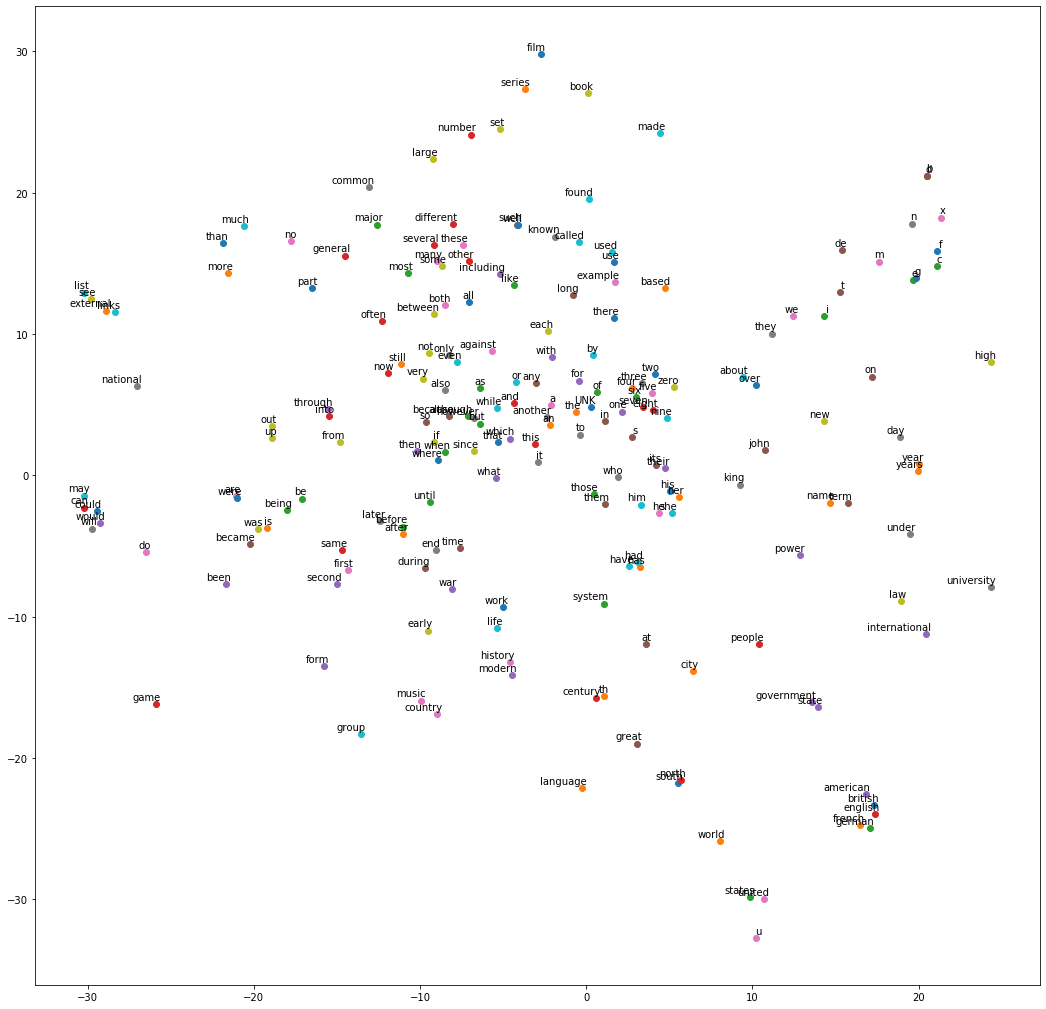

In [104]:
plt.figure(figsize=(18, 18))  #in inches
for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')